In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import copy
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
data = pd.read_csv('Dataset/TC3/train.csv')

In [4]:
data

,down_m_s2,right_m_s2,forward_m_s2
0,-9.827705,-0.002695,-0.146190
1,-9.799362,0.044593,-0.128741
2,-9.793747,0.016577,-0.117054
3,-9.787281,-0.003876,-0.142800
4,-9.818456,-0.033057,-0.093290
...,...,...,...
43542,-9.739140,-0.045190,-1.426029
43543,-9.676372,0.021534,-1.440146
43544,-9.683149,0.007309,-1.399659
43545,-9.682378,0.011090,-1.445912


In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

df_max_scaled = data.copy()
columns_to_scale = ['down_m_s2', 'right_m_s2', 'forward_m_s2']

scaler = MinMaxScaler()
for column in columns_to_scale:
    df_max_scaled[column] = scaler.fit_transform(np.array(df_max_scaled[column]).reshape(-1, 1) )
    
df_max_scaled

,down_m_s2,right_m_s2,forward_m_s2
0,0.605132,0.575266,0.754676
1,0.609411,0.592876,0.762363
2,0.610259,0.582443,0.767512
3,0.611236,0.574826,0.756169
4,0.606528,0.563959,0.777981
...,...,...,...
43542,0.618505,0.559441,0.190832
43543,0.627982,0.584288,0.184613
43544,0.626959,0.578991,0.202450
43545,0.627075,0.580399,0.182073


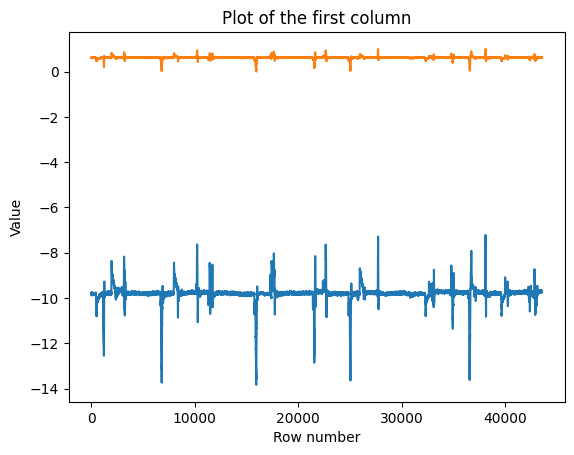

In [6]:
plt.plot(data['down_m_s2'])
plt.plot(df_max_scaled['down_m_s2'])

# Set labels for the axes
plt.xlabel('Row number')
plt.ylabel('Value')

# Set title for the plot
plt.title('Plot of the first column')

# Show the plot
plt.show()

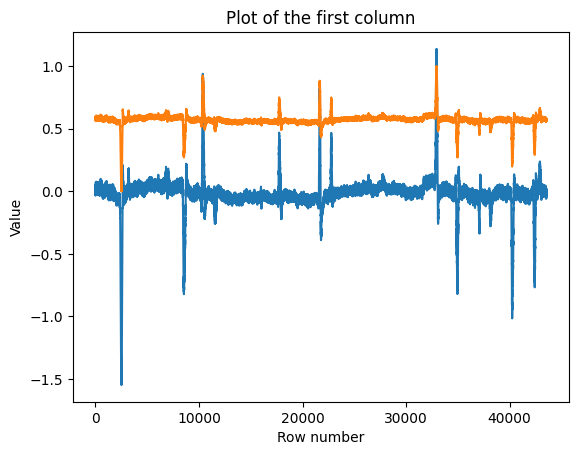

In [7]:
plt.plot(data['right_m_s2'])
plt.plot(df_max_scaled['right_m_s2'])

# Set labels for the axes
plt.xlabel('Row number')
plt.ylabel('Value')

# Set title for the plot
plt.title('Plot of the first column')

# Show the plot
plt.show()

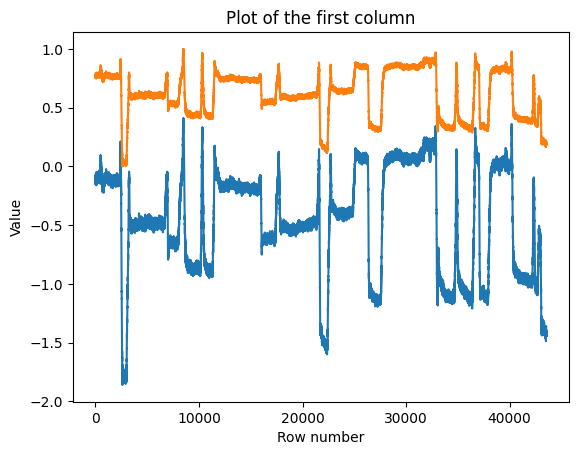

In [8]:
plt.plot(data['forward_m_s2'])
plt.plot(df_max_scaled['forward_m_s2'])

# Set labels for the axes
plt.xlabel('Row number')
plt.ylabel('Value')

# Set title for the plot
plt.title('Plot of the first column')

# Show the plot
plt.show()

In [9]:
sequence_size = 4
sequences = []

for i in range(len(data) - sequence_size + 1):
    sequence = data.iloc[i:i + sequence_size]
    sequences.append(sequence)

sequences_df = pd.concat(sequences, ignore_index=True)

sequences_df

,down_m_s2,right_m_s2,forward_m_s2
0,-9.827705,-0.002695,-0.146190
1,-9.799362,0.044593,-0.128741
2,-9.793747,0.016577,-0.117054
3,-9.787281,-0.003876,-0.142800
4,-9.799362,0.044593,-0.128741
...,...,...,...
174171,-9.682378,0.011090,-1.445912
174172,-9.676372,0.021534,-1.440146
174173,-9.683149,0.007309,-1.399659
174174,-9.682378,0.011090,-1.445912


In [10]:
x_train = sequences_df.values.tolist()
x_train

[[-9.82770538330078, -0.0026945807039737, -0.146190345287323],
 [-9.799362182617188, 0.0445928163826465, -0.128741443157196],
 [-9.793747425079346, 0.0165771730244159, -0.1170536987483501],
 [-9.787280559539797, -0.0038757030852139, -0.1428001224994659],
 [-9.799362182617188, 0.0445928163826465, -0.128741443157196],
 [-9.793747425079346, 0.0165771730244159, -0.1170536987483501],
 [-9.787280559539797, -0.0038757030852139, -0.1428001224994659],
 [-9.818455696105955, -0.0330570265650749, -0.0932901874184608],
 [-9.793747425079346, 0.0165771730244159, -0.1170536987483501],
 [-9.787280559539797, -0.0038757030852139, -0.1428001224994659],
 [-9.818455696105955, -0.0330570265650749, -0.0932901874184608],
 [-9.820038795471191, 0.0261377803981304, -0.1185307726264],
 [-9.787280559539797, -0.0038757030852139, -0.1428001224994659],
 [-9.818455696105955, -0.0330570265650749, -0.0932901874184608],
 [-9.820038795471191, 0.0261377803981304, -0.1185307726264],
 [-9.806636810302734, 0.0067134331911802, 

In [16]:
input_size = 3
dropout = 0.1
num_layers=1
hidden_size=64
num_epochs=20
learning_rate=0.01

class Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Determine device
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, bias=True, batch_first=True, dropout=dropout, bidirectional=True).to(self.device)  # Move LSTM to device
        self.fc_1 = nn.Linear(hidden_size * 2, 128).to(self.device)  # Move Linear layers to device
        self.relu1 = nn.ReLU()
        self.fc_2 = nn.Linear(128, input_size).to(self.device)
        self._init_weights()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, self.hidden_size).to(self.device)  # Move initial states to device
        c0 = torch.zeros(self.num_layers * 2, self.hidden_size).to(self.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc_1(out)
        out = self.relu1(out)
        out = self.fc_2(out)

        return out

    def _init_weights(self):
        for layer in [self.lstm, self.fc_1, self.fc_2]:
            if isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                nn.init.zeros_(layer.bias)
            elif isinstance(layer, nn.LSTM):
                for name, param in layer.named_parameters():
                    if 'weight_ih' in name or 'weight_hh' in name:
                        nn.init.kaiming_normal_(param.data, nonlinearity='relu')
                    elif 'bias' in name:
                        nn.init.zeros_(param.data)


In [17]:
model = Model(input_size, hidden_size, num_layers, dropout)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [18]:
model.to(device)
model.train()

Model(
  (lstm): LSTM(3, 64, batch_first=True, dropout=0.1, bidirectional=True)
  (fc_1): Linear(in_features=128, out_features=128, bias=True)
  (relu1): ReLU()
  (fc_2): Linear(in_features=128, out_features=3, bias=True)
)

In [19]:
predicted_vectors = []

last_index = len(x_train) - 4
num_sequences = last_index // 4

for epoch in range(num_epochs):
    predicted_vectors.clear()
    total_loss = 0
    
    for idx in range(0, last_index, 4):
        sequence = torch.tensor(x_train[idx: idx + 4]).to(device)  
        optimizer.zero_grad()

        out_forward = model(sequence)
        predicted_next_element_1 = out_forward[-1, :].view(-1, 3)
        target_next_element = torch.tensor(x_train[idx + 7]).view(-1, 3).to(device)

        loss_forward_1 = criterion(predicted_next_element_1, target_next_element)
        total_loss += loss_forward_1.item()
        
        loss_forward_1.backward()
        optimizer.step()

        if idx % 100 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Sequence {idx // 4 + 1}/{num_sequences}, Loss: {loss_forward_1.item()}")

        predicted_vectors.append(predicted_next_element_1.detach().cpu().numpy())

    # Calculate average loss for the epoch
    avg_loss = total_loss / num_sequences


Epoch 1/20, Sequence 1/43543, Loss: 34.99580001831055
Epoch 1/20, Sequence 26/43543, Loss: 6.556552886962891
Epoch 1/20, Sequence 51/43543, Loss: 0.0751095712184906
Epoch 1/20, Sequence 76/43543, Loss: 0.001106735784560442
Epoch 1/20, Sequence 101/43543, Loss: 0.0004917804035358131
Epoch 1/20, Sequence 126/43543, Loss: 0.0013631025794893503
Epoch 1/20, Sequence 151/43543, Loss: 0.0008178929565474391
Epoch 1/20, Sequence 176/43543, Loss: 0.0009936774149537086
Epoch 1/20, Sequence 201/43543, Loss: 0.0004808217054232955
Epoch 1/20, Sequence 226/43543, Loss: 0.0005375554319471121
Epoch 1/20, Sequence 251/43543, Loss: 0.0012238147901371121
Epoch 1/20, Sequence 276/43543, Loss: 0.0003321197291370481
Epoch 1/20, Sequence 301/43543, Loss: 2.4157590814866126e-05
Epoch 1/20, Sequence 326/43543, Loss: 0.0007314213435165584
Epoch 1/20, Sequence 351/43543, Loss: 0.00033818415249697864
Epoch 1/20, Sequence 376/43543, Loss: 0.0014528529718518257
Epoch 1/20, Sequence 401/43543, Loss: 0.001490560360252

Epoch 1/20, Sequence 3401/43543, Loss: 0.0023831557482481003
Epoch 1/20, Sequence 3426/43543, Loss: 0.0016908887773752213
Epoch 1/20, Sequence 3451/43543, Loss: 0.000789785641245544
Epoch 1/20, Sequence 3476/43543, Loss: 0.0010593181941658258
Epoch 1/20, Sequence 3501/43543, Loss: 0.001658215536735952
Epoch 1/20, Sequence 3526/43543, Loss: 0.0006341865519061685
Epoch 1/20, Sequence 3551/43543, Loss: 0.00013896966993343085
Epoch 1/20, Sequence 3576/43543, Loss: 0.0008520900155417621
Epoch 1/20, Sequence 3601/43543, Loss: 0.0019630328752100468
Epoch 1/20, Sequence 3626/43543, Loss: 0.0026223789900541306
Epoch 1/20, Sequence 3651/43543, Loss: 0.0005662267794832587
Epoch 1/20, Sequence 3676/43543, Loss: 4.607213122653775e-05
Epoch 1/20, Sequence 3701/43543, Loss: 0.00037803055602125823
Epoch 1/20, Sequence 3726/43543, Loss: 0.000940606405492872
Epoch 1/20, Sequence 3751/43543, Loss: 0.000957573065534234
Epoch 1/20, Sequence 3776/43543, Loss: 0.0006921700551174581
Epoch 1/20, Sequence 3801/

Epoch 1/20, Sequence 6801/43543, Loss: 0.016265444457530975
Epoch 1/20, Sequence 6826/43543, Loss: 0.004628419876098633
Epoch 1/20, Sequence 6851/43543, Loss: 0.0061998507007956505
Epoch 1/20, Sequence 6876/43543, Loss: 0.005410082638263702
Epoch 1/20, Sequence 6901/43543, Loss: 0.00933784618973732
Epoch 1/20, Sequence 6926/43543, Loss: 0.003793146461248398
Epoch 1/20, Sequence 6951/43543, Loss: 0.0008288544486276805
Epoch 1/20, Sequence 6976/43543, Loss: 0.0032994630746543407
Epoch 1/20, Sequence 7001/43543, Loss: 0.00027679826598614454
Epoch 1/20, Sequence 7026/43543, Loss: 0.003190118819475174
Epoch 1/20, Sequence 7051/43543, Loss: 0.006421483587473631
Epoch 1/20, Sequence 7076/43543, Loss: 0.0013448040699586272
Epoch 1/20, Sequence 7101/43543, Loss: 0.0044093080796301365
Epoch 1/20, Sequence 7126/43543, Loss: 0.000674570444971323
Epoch 1/20, Sequence 7151/43543, Loss: 0.002435544040054083
Epoch 1/20, Sequence 7176/43543, Loss: 0.0009321087272837758
Epoch 1/20, Sequence 7201/43543, 

Epoch 1/20, Sequence 10201/43543, Loss: 0.000563204288482666
Epoch 1/20, Sequence 10226/43543, Loss: 0.0027745766565203667
Epoch 1/20, Sequence 10251/43543, Loss: 0.00022918719332665205
Epoch 1/20, Sequence 10276/43543, Loss: 0.0037612752057611942
Epoch 1/20, Sequence 10301/43543, Loss: 0.0013286767061799765
Epoch 1/20, Sequence 10326/43543, Loss: 0.0016595161287114024
Epoch 1/20, Sequence 10351/43543, Loss: 0.00014090749027673155
Epoch 1/20, Sequence 10376/43543, Loss: 0.00042311340803280473
Epoch 1/20, Sequence 10401/43543, Loss: 0.0006496941205114126
Epoch 1/20, Sequence 10426/43543, Loss: 0.0013337827986106277
Epoch 1/20, Sequence 10451/43543, Loss: 0.003009307896718383
Epoch 1/20, Sequence 10476/43543, Loss: 0.0015777036314830184
Epoch 1/20, Sequence 10501/43543, Loss: 0.00014949848991818726
Epoch 1/20, Sequence 10526/43543, Loss: 0.0002649158122949302
Epoch 1/20, Sequence 10551/43543, Loss: 0.0004895470920018852
Epoch 1/20, Sequence 10576/43543, Loss: 0.002102562924847007
Epoch 1

Epoch 1/20, Sequence 13551/43543, Loss: 0.002464649733155966
Epoch 1/20, Sequence 13576/43543, Loss: 0.0009189713164232671
Epoch 1/20, Sequence 13601/43543, Loss: 1.4556018868461251e-05
Epoch 1/20, Sequence 13626/43543, Loss: 0.0003498138103168458
Epoch 1/20, Sequence 13651/43543, Loss: 0.0022202383261173964
Epoch 1/20, Sequence 13676/43543, Loss: 0.00015753653133288026
Epoch 1/20, Sequence 13701/43543, Loss: 0.00047709731734357774
Epoch 1/20, Sequence 13726/43543, Loss: 0.0010416936129331589
Epoch 1/20, Sequence 13751/43543, Loss: 0.00033292974694631994
Epoch 1/20, Sequence 13776/43543, Loss: 0.0015900915022939444
Epoch 1/20, Sequence 13801/43543, Loss: 0.002261709189042449
Epoch 1/20, Sequence 13826/43543, Loss: 0.001986225601285696
Epoch 1/20, Sequence 13851/43543, Loss: 0.0027709132991731167
Epoch 1/20, Sequence 13876/43543, Loss: 0.0007068987470120192
Epoch 1/20, Sequence 13901/43543, Loss: 0.000541561923455447
Epoch 1/20, Sequence 13926/43543, Loss: 0.0003920813906006515
Epoch 1/

Epoch 1/20, Sequence 16901/43543, Loss: 0.0006068900693207979
Epoch 1/20, Sequence 16926/43543, Loss: 0.0003054092812817544
Epoch 1/20, Sequence 16951/43543, Loss: 0.001172095537185669
Epoch 1/20, Sequence 16976/43543, Loss: 0.00026139101828448474
Epoch 1/20, Sequence 17001/43543, Loss: 0.0002299709594808519
Epoch 1/20, Sequence 17026/43543, Loss: 0.0013477187603712082
Epoch 1/20, Sequence 17051/43543, Loss: 0.0011578763369470835
Epoch 1/20, Sequence 17076/43543, Loss: 4.874195656157099e-05
Epoch 1/20, Sequence 17101/43543, Loss: 0.0011508539319038391
Epoch 1/20, Sequence 17126/43543, Loss: 0.0003796869423240423
Epoch 1/20, Sequence 17151/43543, Loss: 0.0013416021829470992
Epoch 1/20, Sequence 17176/43543, Loss: 0.002814777195453644
Epoch 1/20, Sequence 17201/43543, Loss: 0.0008649981464259326
Epoch 1/20, Sequence 17226/43543, Loss: 0.0007675430970266461
Epoch 1/20, Sequence 17251/43543, Loss: 0.000573516997974366
Epoch 1/20, Sequence 17276/43543, Loss: 0.003413217142224312
Epoch 1/20,

Epoch 1/20, Sequence 20251/43543, Loss: 0.0029769078828394413
Epoch 1/20, Sequence 20276/43543, Loss: 0.000548575771972537
Epoch 1/20, Sequence 20301/43543, Loss: 0.001832498935982585
Epoch 1/20, Sequence 20326/43543, Loss: 0.0007452491554431617
Epoch 1/20, Sequence 20351/43543, Loss: 0.0006455222028307617
Epoch 1/20, Sequence 20376/43543, Loss: 0.00044258087291382253
Epoch 1/20, Sequence 20401/43543, Loss: 0.0001104525217670016
Epoch 1/20, Sequence 20426/43543, Loss: 0.0023977882228791714
Epoch 1/20, Sequence 20451/43543, Loss: 0.002019330859184265
Epoch 1/20, Sequence 20476/43543, Loss: 0.0004316528211347759
Epoch 1/20, Sequence 20501/43543, Loss: 0.0011424497934058309
Epoch 1/20, Sequence 20526/43543, Loss: 0.0018089719815179706
Epoch 1/20, Sequence 20551/43543, Loss: 0.0005166102782823145
Epoch 1/20, Sequence 20576/43543, Loss: 0.0010825487552210689
Epoch 1/20, Sequence 20601/43543, Loss: 0.002979409648105502
Epoch 1/20, Sequence 20626/43543, Loss: 8.339126361534e-05
Epoch 1/20, Se

Epoch 1/20, Sequence 23601/43543, Loss: 0.000352472037775442
Epoch 1/20, Sequence 23626/43543, Loss: 0.00012599270849023014
Epoch 1/20, Sequence 23651/43543, Loss: 0.0025640027597546577
Epoch 1/20, Sequence 23676/43543, Loss: 5.880540265934542e-05
Epoch 1/20, Sequence 23701/43543, Loss: 0.0002244054776383564
Epoch 1/20, Sequence 23726/43543, Loss: 0.0016251374036073685
Epoch 1/20, Sequence 23751/43543, Loss: 0.00019800725567620248
Epoch 1/20, Sequence 23776/43543, Loss: 0.0010783083271235228
Epoch 1/20, Sequence 23801/43543, Loss: 0.00014770947746001184
Epoch 1/20, Sequence 23826/43543, Loss: 0.0009078267030417919
Epoch 1/20, Sequence 23851/43543, Loss: 0.0033473712392151356
Epoch 1/20, Sequence 23876/43543, Loss: 0.0024521779268980026
Epoch 1/20, Sequence 23901/43543, Loss: 0.0014679611194878817
Epoch 1/20, Sequence 23926/43543, Loss: 0.0014102545101195574
Epoch 1/20, Sequence 23951/43543, Loss: 0.000489878177177161
Epoch 1/20, Sequence 23976/43543, Loss: 0.0011183550814166665
Epoch 1

Epoch 1/20, Sequence 26951/43543, Loss: 0.0012745301937684417
Epoch 1/20, Sequence 26976/43543, Loss: 0.00187969661783427
Epoch 1/20, Sequence 27001/43543, Loss: 0.002656827215105295
Epoch 1/20, Sequence 27026/43543, Loss: 0.0010733496164903045
Epoch 1/20, Sequence 27051/43543, Loss: 0.0019107809057459235
Epoch 1/20, Sequence 27076/43543, Loss: 0.0008302449132315814
Epoch 1/20, Sequence 27101/43543, Loss: 0.0006195894675329328
Epoch 1/20, Sequence 27126/43543, Loss: 0.00014578377886209637
Epoch 1/20, Sequence 27151/43543, Loss: 0.0006153251742944121
Epoch 1/20, Sequence 27176/43543, Loss: 0.0004094222967978567
Epoch 1/20, Sequence 27201/43543, Loss: 0.0023592717479914427
Epoch 1/20, Sequence 27226/43543, Loss: 0.00036161462776362896
Epoch 1/20, Sequence 27251/43543, Loss: 0.002010476076975465
Epoch 1/20, Sequence 27276/43543, Loss: 0.0006381535204127431
Epoch 1/20, Sequence 27301/43543, Loss: 0.001785533269867301
Epoch 1/20, Sequence 27326/43543, Loss: 0.0004836497828364372
Epoch 1/20,

Epoch 1/20, Sequence 30276/43543, Loss: 0.0013113701716065407
Epoch 1/20, Sequence 30301/43543, Loss: 0.0004211679333820939
Epoch 1/20, Sequence 30326/43543, Loss: 0.0005326088867150247
Epoch 1/20, Sequence 30351/43543, Loss: 0.0016235476359724998
Epoch 1/20, Sequence 30376/43543, Loss: 0.0029474333859980106
Epoch 1/20, Sequence 30401/43543, Loss: 2.8446964279282838e-05
Epoch 1/20, Sequence 30426/43543, Loss: 0.002109791385009885
Epoch 1/20, Sequence 30451/43543, Loss: 9.077777940547094e-05
Epoch 1/20, Sequence 30476/43543, Loss: 0.0008051537442952394
Epoch 1/20, Sequence 30501/43543, Loss: 0.0004854099825024605
Epoch 1/20, Sequence 30526/43543, Loss: 0.0009727360447868705
Epoch 1/20, Sequence 30551/43543, Loss: 0.00095343281282112
Epoch 1/20, Sequence 30576/43543, Loss: 0.0007531751762144268
Epoch 1/20, Sequence 30601/43543, Loss: 0.00036387864383868873
Epoch 1/20, Sequence 30626/43543, Loss: 0.0020286869257688522
Epoch 1/20, Sequence 30651/43543, Loss: 0.0022154843900352716
Epoch 1/2

Epoch 1/20, Sequence 33626/43543, Loss: 0.0022924370132386684
Epoch 1/20, Sequence 33651/43543, Loss: 0.0006496672285720706
Epoch 1/20, Sequence 33676/43543, Loss: 0.0003965508076362312
Epoch 1/20, Sequence 33701/43543, Loss: 0.00023505461285822093
Epoch 1/20, Sequence 33726/43543, Loss: 0.0006253349129110575
Epoch 1/20, Sequence 33751/43543, Loss: 0.001131426659412682
Epoch 1/20, Sequence 33776/43543, Loss: 0.0004902180517092347
Epoch 1/20, Sequence 33801/43543, Loss: 0.0004412848502397537
Epoch 1/20, Sequence 33826/43543, Loss: 0.0005060678813606501
Epoch 1/20, Sequence 33851/43543, Loss: 0.0005095876986160874
Epoch 1/20, Sequence 33876/43543, Loss: 0.0023905765265226364
Epoch 1/20, Sequence 33901/43543, Loss: 0.0012105666100978851
Epoch 1/20, Sequence 33926/43543, Loss: 0.0006632962031289935
Epoch 1/20, Sequence 33951/43543, Loss: 7.431271660607308e-05
Epoch 1/20, Sequence 33976/43543, Loss: 0.00017948987078852952
Epoch 1/20, Sequence 34001/43543, Loss: 0.0004896856844425201
Epoch 1

Epoch 1/20, Sequence 36976/43543, Loss: 0.00038835196755826473
Epoch 1/20, Sequence 37001/43543, Loss: 0.0018461317522451282
Epoch 1/20, Sequence 37026/43543, Loss: 0.008938542567193508
Epoch 1/20, Sequence 37051/43543, Loss: 0.0003090867539867759
Epoch 1/20, Sequence 37076/43543, Loss: 0.0007758797146379948
Epoch 1/20, Sequence 37101/43543, Loss: 0.0013674849178642035
Epoch 1/20, Sequence 37126/43543, Loss: 0.003775686491280794
Epoch 1/20, Sequence 37151/43543, Loss: 0.007245825137943029
Epoch 1/20, Sequence 37176/43543, Loss: 0.006763119250535965
Epoch 1/20, Sequence 37201/43543, Loss: 0.0007939084898680449
Epoch 1/20, Sequence 37226/43543, Loss: 5.434249032987282e-05
Epoch 1/20, Sequence 37251/43543, Loss: 0.0005738371983170509
Epoch 1/20, Sequence 37276/43543, Loss: 0.0001838286261772737
Epoch 1/20, Sequence 37301/43543, Loss: 0.0001201277191285044
Epoch 1/20, Sequence 37326/43543, Loss: 0.0005494073266163468
Epoch 1/20, Sequence 37351/43543, Loss: 0.0004841092159040272
Epoch 1/20,

Epoch 1/20, Sequence 40326/43543, Loss: 0.0005862199468538165
Epoch 1/20, Sequence 40351/43543, Loss: 0.000616194331087172
Epoch 1/20, Sequence 40376/43543, Loss: 0.00043082149932160974
Epoch 1/20, Sequence 40401/43543, Loss: 0.00014708965318277478
Epoch 1/20, Sequence 40426/43543, Loss: 0.0008388093556277454
Epoch 1/20, Sequence 40451/43543, Loss: 0.0016985917463898659
Epoch 1/20, Sequence 40476/43543, Loss: 0.0006065125344321132
Epoch 1/20, Sequence 40501/43543, Loss: 0.0010479463962838054
Epoch 1/20, Sequence 40526/43543, Loss: 0.000168026119354181
Epoch 1/20, Sequence 40551/43543, Loss: 0.0001494374155299738
Epoch 1/20, Sequence 40576/43543, Loss: 0.0017044467385858297
Epoch 1/20, Sequence 40601/43543, Loss: 0.0025086759123951197
Epoch 1/20, Sequence 40626/43543, Loss: 0.0013577097561210394
Epoch 1/20, Sequence 40651/43543, Loss: 0.0019417796283960342
Epoch 1/20, Sequence 40676/43543, Loss: 0.0004736002301797271
Epoch 1/20, Sequence 40701/43543, Loss: 0.0003227312699891627
Epoch 1/

Epoch 2/20, Sequence 126/43543, Loss: 0.001199922407977283
Epoch 2/20, Sequence 151/43543, Loss: 0.0008738458855077624
Epoch 2/20, Sequence 176/43543, Loss: 0.00030131771927699447
Epoch 2/20, Sequence 201/43543, Loss: 0.0004122932441532612
Epoch 2/20, Sequence 226/43543, Loss: 0.0007258839323185384
Epoch 2/20, Sequence 251/43543, Loss: 0.0014752584975212812
Epoch 2/20, Sequence 276/43543, Loss: 0.00014258686860557646
Epoch 2/20, Sequence 301/43543, Loss: 4.3603544327197596e-05
Epoch 2/20, Sequence 326/43543, Loss: 0.0007778622093610466
Epoch 2/20, Sequence 351/43543, Loss: 0.0004093335010111332
Epoch 2/20, Sequence 376/43543, Loss: 0.0015102180186659098
Epoch 2/20, Sequence 401/43543, Loss: 0.0011041363468393683
Epoch 2/20, Sequence 426/43543, Loss: 0.0015971120446920395
Epoch 2/20, Sequence 451/43543, Loss: 0.00200130557641387
Epoch 2/20, Sequence 476/43543, Loss: 0.008038138970732689
Epoch 2/20, Sequence 501/43543, Loss: 0.005483583547174931
Epoch 2/20, Sequence 526/43543, Loss: 0.00

Epoch 2/20, Sequence 3526/43543, Loss: 0.00015172104758676142
Epoch 2/20, Sequence 3551/43543, Loss: 0.0008348179399035871
Epoch 2/20, Sequence 3576/43543, Loss: 0.0005703656934201717
Epoch 2/20, Sequence 3601/43543, Loss: 0.0004735516558866948
Epoch 2/20, Sequence 3626/43543, Loss: 0.0009173454600386322
Epoch 2/20, Sequence 3651/43543, Loss: 0.0007519795326516032
Epoch 2/20, Sequence 3676/43543, Loss: 0.0004868382529821247
Epoch 2/20, Sequence 3701/43543, Loss: 0.0001780276361387223
Epoch 2/20, Sequence 3726/43543, Loss: 0.000377046613721177
Epoch 2/20, Sequence 3751/43543, Loss: 0.0011829733848571777
Epoch 2/20, Sequence 3776/43543, Loss: 0.0013090197462588549
Epoch 2/20, Sequence 3801/43543, Loss: 0.00015531409007962793
Epoch 2/20, Sequence 3826/43543, Loss: 0.003007345600053668
Epoch 2/20, Sequence 3851/43543, Loss: 0.000819841050542891
Epoch 2/20, Sequence 3876/43543, Loss: 0.0025265286676585674
Epoch 2/20, Sequence 3901/43543, Loss: 0.0010894353035837412
Epoch 2/20, Sequence 3926

Epoch 2/20, Sequence 6926/43543, Loss: 0.003493126016110182
Epoch 2/20, Sequence 6951/43543, Loss: 0.0005762483924627304
Epoch 2/20, Sequence 6976/43543, Loss: 0.0008028848096728325
Epoch 2/20, Sequence 7001/43543, Loss: 0.0007131723104976118
Epoch 2/20, Sequence 7026/43543, Loss: 0.002003899309784174
Epoch 2/20, Sequence 7051/43543, Loss: 0.0026144690345972776
Epoch 2/20, Sequence 7076/43543, Loss: 0.0014053755439817905
Epoch 2/20, Sequence 7101/43543, Loss: 0.004970224108546972
Epoch 2/20, Sequence 7126/43543, Loss: 0.00023729643726255745
Epoch 2/20, Sequence 7151/43543, Loss: 0.0012448623310774565
Epoch 2/20, Sequence 7176/43543, Loss: 0.0002499280381016433
Epoch 2/20, Sequence 7201/43543, Loss: 0.003461389569565654
Epoch 2/20, Sequence 7226/43543, Loss: 0.0022497051395475864
Epoch 2/20, Sequence 7251/43543, Loss: 0.00015073921531438828
Epoch 2/20, Sequence 7276/43543, Loss: 0.0006272360915318131
Epoch 2/20, Sequence 7301/43543, Loss: 0.006910999771207571
Epoch 2/20, Sequence 7326/4

Epoch 2/20, Sequence 10326/43543, Loss: 0.0022537540644407272
Epoch 2/20, Sequence 10351/43543, Loss: 0.0011515563819557428
Epoch 2/20, Sequence 10376/43543, Loss: 0.0008382521918974817
Epoch 2/20, Sequence 10401/43543, Loss: 0.001114429091103375
Epoch 2/20, Sequence 10426/43543, Loss: 0.00033682744833640754
Epoch 2/20, Sequence 10451/43543, Loss: 0.0006640860810875893
Epoch 2/20, Sequence 10476/43543, Loss: 0.00014147681940812618
Epoch 2/20, Sequence 10501/43543, Loss: 0.0005055268993601203
Epoch 2/20, Sequence 10526/43543, Loss: 0.0012923118192702532
Epoch 2/20, Sequence 10551/43543, Loss: 0.006107880733907223
Epoch 2/20, Sequence 10576/43543, Loss: 0.0001773991680238396
Epoch 2/20, Sequence 10601/43543, Loss: 0.00042747572297230363
Epoch 2/20, Sequence 10626/43543, Loss: 0.000719875271897763
Epoch 2/20, Sequence 10651/43543, Loss: 0.0025443551130592823
Epoch 2/20, Sequence 10676/43543, Loss: 0.0001077702472684905
Epoch 2/20, Sequence 10701/43543, Loss: 0.0012048801872879267
Epoch 2/

Epoch 2/20, Sequence 13676/43543, Loss: 0.0011972778011113405
Epoch 2/20, Sequence 13701/43543, Loss: 0.0031524915248155594
Epoch 2/20, Sequence 13726/43543, Loss: 0.0020398946944624186
Epoch 2/20, Sequence 13751/43543, Loss: 0.007105065509676933
Epoch 2/20, Sequence 13776/43543, Loss: 0.0009890692308545113
Epoch 2/20, Sequence 13801/43543, Loss: 0.0013816971331834793
Epoch 2/20, Sequence 13826/43543, Loss: 0.0006604591617360711
Epoch 2/20, Sequence 13851/43543, Loss: 0.001940342364832759
Epoch 2/20, Sequence 13876/43543, Loss: 0.0009020947618409991
Epoch 2/20, Sequence 13901/43543, Loss: 0.0029209440108388662
Epoch 2/20, Sequence 13926/43543, Loss: 0.0004228579346090555
Epoch 2/20, Sequence 13951/43543, Loss: 0.0006861022557131946
Epoch 2/20, Sequence 13976/43543, Loss: 0.0010769738582894206
Epoch 2/20, Sequence 14001/43543, Loss: 0.00036768155405297875
Epoch 2/20, Sequence 14026/43543, Loss: 0.002891186159104109
Epoch 2/20, Sequence 14051/43543, Loss: 0.00022160023218020797
Epoch 2/2

Epoch 2/20, Sequence 17026/43543, Loss: 0.0007781348540447652
Epoch 2/20, Sequence 17051/43543, Loss: 9.49268214753829e-05
Epoch 2/20, Sequence 17076/43543, Loss: 0.00045475520892068744
Epoch 2/20, Sequence 17101/43543, Loss: 0.0005049511091783643
Epoch 2/20, Sequence 17126/43543, Loss: 0.0016134371981024742
Epoch 2/20, Sequence 17151/43543, Loss: 0.0006138535682111979
Epoch 2/20, Sequence 17176/43543, Loss: 0.0005350610008463264
Epoch 2/20, Sequence 17201/43543, Loss: 4.993665061192587e-05
Epoch 2/20, Sequence 17226/43543, Loss: 0.0007772624958306551
Epoch 2/20, Sequence 17251/43543, Loss: 0.0011109084589406848
Epoch 2/20, Sequence 17276/43543, Loss: 0.0005580304423347116
Epoch 2/20, Sequence 17301/43543, Loss: 0.0005275890580378473
Epoch 2/20, Sequence 17326/43543, Loss: 0.000280537991784513
Epoch 2/20, Sequence 17351/43543, Loss: 0.006441555451601744
Epoch 2/20, Sequence 17376/43543, Loss: 0.0029705993365496397
Epoch 2/20, Sequence 17401/43543, Loss: 0.0005699003813788295
Epoch 2/20

Epoch 2/20, Sequence 20376/43543, Loss: 0.002845024224370718
Epoch 2/20, Sequence 20401/43543, Loss: 0.0006646773545071483
Epoch 2/20, Sequence 20426/43543, Loss: 0.0007999979425221682
Epoch 2/20, Sequence 20451/43543, Loss: 0.00014218146679922938
Epoch 2/20, Sequence 20476/43543, Loss: 0.0009285311680287123
Epoch 2/20, Sequence 20501/43543, Loss: 0.0006609853589907289
Epoch 2/20, Sequence 20526/43543, Loss: 0.0010407485533505678
Epoch 2/20, Sequence 20551/43543, Loss: 0.0008903898997232318
Epoch 2/20, Sequence 20576/43543, Loss: 0.0015682706143707037
Epoch 2/20, Sequence 20601/43543, Loss: 0.0006774266948923469
Epoch 2/20, Sequence 20626/43543, Loss: 0.001305241952650249
Epoch 2/20, Sequence 20651/43543, Loss: 0.00021960210870020092
Epoch 2/20, Sequence 20676/43543, Loss: 0.0012827281607314944
Epoch 2/20, Sequence 20701/43543, Loss: 0.0016535146860405803
Epoch 2/20, Sequence 20726/43543, Loss: 0.001758761703968048
Epoch 2/20, Sequence 20751/43543, Loss: 0.0037196329794824123
Epoch 2/2

Epoch 2/20, Sequence 23726/43543, Loss: 0.0013338088756427169
Epoch 2/20, Sequence 23751/43543, Loss: 0.0004971587331965566
Epoch 2/20, Sequence 23776/43543, Loss: 0.002653731731697917
Epoch 2/20, Sequence 23801/43543, Loss: 0.0011237449944019318
Epoch 2/20, Sequence 23826/43543, Loss: 0.001020821975544095
Epoch 2/20, Sequence 23851/43543, Loss: 0.0008512040949426591
Epoch 2/20, Sequence 23876/43543, Loss: 0.000492069695610553
Epoch 2/20, Sequence 23901/43543, Loss: 0.001755086937919259
Epoch 2/20, Sequence 23926/43543, Loss: 0.0010814109118655324
Epoch 2/20, Sequence 23951/43543, Loss: 0.0004586181021295488
Epoch 2/20, Sequence 23976/43543, Loss: 0.00027785543352365494
Epoch 2/20, Sequence 24001/43543, Loss: 0.0003542195481713861
Epoch 2/20, Sequence 24026/43543, Loss: 0.0012185953091830015
Epoch 2/20, Sequence 24051/43543, Loss: 0.001388130127452314
Epoch 2/20, Sequence 24076/43543, Loss: 0.00018558776355348527
Epoch 2/20, Sequence 24101/43543, Loss: 0.0004931539879180491
Epoch 2/20,

Epoch 2/20, Sequence 27051/43543, Loss: 0.0014037562068551779
Epoch 2/20, Sequence 27076/43543, Loss: 0.0013812290271744132
Epoch 2/20, Sequence 27101/43543, Loss: 0.0012746918946504593
Epoch 2/20, Sequence 27126/43543, Loss: 0.0030143519397825003
Epoch 2/20, Sequence 27151/43543, Loss: 0.0008221416501328349
Epoch 2/20, Sequence 27176/43543, Loss: 0.0006686502601951361
Epoch 2/20, Sequence 27201/43543, Loss: 0.0007384405471384525
Epoch 2/20, Sequence 27226/43543, Loss: 0.0009068834478966892
Epoch 2/20, Sequence 27251/43543, Loss: 0.00044659324339590967
Epoch 2/20, Sequence 27276/43543, Loss: 0.00026128432364203036
Epoch 2/20, Sequence 27301/43543, Loss: 0.0013372203102335334
Epoch 2/20, Sequence 27326/43543, Loss: 0.00025830426602624357
Epoch 2/20, Sequence 27351/43543, Loss: 0.0003235477488487959
Epoch 2/20, Sequence 27376/43543, Loss: 0.00022788936621509492
Epoch 2/20, Sequence 27401/43543, Loss: 0.001773988245986402
Epoch 2/20, Sequence 27426/43543, Loss: 0.001929664984345436
Epoch 

Epoch 2/20, Sequence 30376/43543, Loss: 0.0016788116190582514
Epoch 2/20, Sequence 30401/43543, Loss: 0.0006867185002192855
Epoch 2/20, Sequence 30426/43543, Loss: 0.0007049463456496596
Epoch 2/20, Sequence 30451/43543, Loss: 0.00013763636525254697
Epoch 2/20, Sequence 30476/43543, Loss: 0.0029405083041638136
Epoch 2/20, Sequence 30501/43543, Loss: 0.0008536306559108198
Epoch 2/20, Sequence 30526/43543, Loss: 0.000842677429318428
Epoch 2/20, Sequence 30551/43543, Loss: 0.0004592608893290162
Epoch 2/20, Sequence 30576/43543, Loss: 0.00013370148371905088
Epoch 2/20, Sequence 30601/43543, Loss: 0.00030865235021337867
Epoch 2/20, Sequence 30626/43543, Loss: 0.0007279239362105727
Epoch 2/20, Sequence 30651/43543, Loss: 0.0011463681003078818
Epoch 2/20, Sequence 30676/43543, Loss: 0.0011021362151950598
Epoch 2/20, Sequence 30701/43543, Loss: 0.000481144932564348
Epoch 2/20, Sequence 30726/43543, Loss: 0.0005705112125724554
Epoch 2/20, Sequence 30751/43543, Loss: 0.00161035917699337
Epoch 2/2

Epoch 2/20, Sequence 33726/43543, Loss: 0.0011322499485686421
Epoch 2/20, Sequence 33751/43543, Loss: 0.0010202138219028711
Epoch 2/20, Sequence 33776/43543, Loss: 0.0009653877350501716
Epoch 2/20, Sequence 33801/43543, Loss: 0.00045720915659330785
Epoch 2/20, Sequence 33826/43543, Loss: 0.0021377834491431713
Epoch 2/20, Sequence 33851/43543, Loss: 0.0006637286860495806
Epoch 2/20, Sequence 33876/43543, Loss: 0.0002474868088029325
Epoch 2/20, Sequence 33901/43543, Loss: 0.0011861242819577456
Epoch 2/20, Sequence 33926/43543, Loss: 0.0002585602051112801
Epoch 2/20, Sequence 33951/43543, Loss: 0.00018257551710121334
Epoch 2/20, Sequence 33976/43543, Loss: 0.00044786446960642934
Epoch 2/20, Sequence 34001/43543, Loss: 0.00015374188660643995
Epoch 2/20, Sequence 34026/43543, Loss: 0.0008385779219679534
Epoch 2/20, Sequence 34051/43543, Loss: 0.00042108059278689325
Epoch 2/20, Sequence 34076/43543, Loss: 0.00020909481099806726
Epoch 2/20, Sequence 34101/43543, Loss: 0.00039624766213819385
E

Epoch 2/20, Sequence 37076/43543, Loss: 0.003992539830505848
Epoch 2/20, Sequence 37101/43543, Loss: 0.001236590789631009
Epoch 2/20, Sequence 37126/43543, Loss: 0.0017466412391513586
Epoch 2/20, Sequence 37151/43543, Loss: 0.006217392161488533
Epoch 2/20, Sequence 37176/43543, Loss: 0.0010895031737163663
Epoch 2/20, Sequence 37201/43543, Loss: 0.00011313329741824418
Epoch 2/20, Sequence 37226/43543, Loss: 7.538100908277556e-05
Epoch 2/20, Sequence 37251/43543, Loss: 0.000588240276556462
Epoch 2/20, Sequence 37276/43543, Loss: 0.0013775017578154802
Epoch 2/20, Sequence 37301/43543, Loss: 0.00037602760130539536
Epoch 2/20, Sequence 37326/43543, Loss: 0.00039145571645349264
Epoch 2/20, Sequence 37351/43543, Loss: 0.0006601579952985048
Epoch 2/20, Sequence 37376/43543, Loss: 0.00010626557923387736
Epoch 2/20, Sequence 37401/43543, Loss: 0.00057845504488796
Epoch 2/20, Sequence 37426/43543, Loss: 0.0009341947734355927
Epoch 2/20, Sequence 37451/43543, Loss: 0.0018829538021236658
Epoch 2/20

Epoch 2/20, Sequence 40401/43543, Loss: 0.0010958111379295588
Epoch 2/20, Sequence 40426/43543, Loss: 0.0020066711585968733
Epoch 2/20, Sequence 40451/43543, Loss: 0.00021649169502779841
Epoch 2/20, Sequence 40476/43543, Loss: 0.00036152463871985674
Epoch 2/20, Sequence 40501/43543, Loss: 0.0019085332751274109
Epoch 2/20, Sequence 40526/43543, Loss: 8.202387834899127e-05
Epoch 2/20, Sequence 40551/43543, Loss: 0.0017824394162744284
Epoch 2/20, Sequence 40576/43543, Loss: 0.00197273725643754
Epoch 2/20, Sequence 40601/43543, Loss: 0.0014669988304376602
Epoch 2/20, Sequence 40626/43543, Loss: 0.0013150256127119064
Epoch 2/20, Sequence 40651/43543, Loss: 0.0006536119617521763
Epoch 2/20, Sequence 40676/43543, Loss: 0.0003435122489463538
Epoch 2/20, Sequence 40701/43543, Loss: 0.0005705223302356899
Epoch 2/20, Sequence 40726/43543, Loss: 0.00011740085756173357
Epoch 2/20, Sequence 40751/43543, Loss: 0.0015468231867998838
Epoch 2/20, Sequence 40776/43543, Loss: 0.0005388470599427819
Epoch 2

Epoch 3/20, Sequence 176/43543, Loss: 0.00035043933894485235
Epoch 3/20, Sequence 201/43543, Loss: 0.001240438548848033
Epoch 3/20, Sequence 226/43543, Loss: 0.0006882119923830032
Epoch 3/20, Sequence 251/43543, Loss: 0.002786548575386405
Epoch 3/20, Sequence 276/43543, Loss: 0.0008746456587687135
Epoch 3/20, Sequence 301/43543, Loss: 0.0001841984922066331
Epoch 3/20, Sequence 326/43543, Loss: 0.0013944287784397602
Epoch 3/20, Sequence 351/43543, Loss: 0.00016126186528708786
Epoch 3/20, Sequence 376/43543, Loss: 0.0003610946878325194
Epoch 3/20, Sequence 401/43543, Loss: 0.001149777788668871
Epoch 3/20, Sequence 426/43543, Loss: 0.001150231808423996
Epoch 3/20, Sequence 451/43543, Loss: 0.0002241616020910442
Epoch 3/20, Sequence 476/43543, Loss: 0.002822275273501873
Epoch 3/20, Sequence 501/43543, Loss: 0.011400893330574036
Epoch 3/20, Sequence 526/43543, Loss: 0.0027596838772296906
Epoch 3/20, Sequence 551/43543, Loss: 0.007474901154637337
Epoch 3/20, Sequence 576/43543, Loss: 0.00021

Epoch 3/20, Sequence 3601/43543, Loss: 0.0003273453039582819
Epoch 3/20, Sequence 3626/43543, Loss: 0.001054604072123766
Epoch 3/20, Sequence 3651/43543, Loss: 0.0010273366933688521
Epoch 3/20, Sequence 3676/43543, Loss: 0.0009560258476994932
Epoch 3/20, Sequence 3701/43543, Loss: 0.003855582792311907
Epoch 3/20, Sequence 3726/43543, Loss: 0.00012522321776486933
Epoch 3/20, Sequence 3751/43543, Loss: 0.000584262830670923
Epoch 3/20, Sequence 3776/43543, Loss: 0.001480442937463522
Epoch 3/20, Sequence 3801/43543, Loss: 0.00013453378051053733
Epoch 3/20, Sequence 3826/43543, Loss: 0.0030256598256528378
Epoch 3/20, Sequence 3851/43543, Loss: 0.00037036335561424494
Epoch 3/20, Sequence 3876/43543, Loss: 0.0026452280580997467
Epoch 3/20, Sequence 3901/43543, Loss: 0.0010606091236695647
Epoch 3/20, Sequence 3926/43543, Loss: 0.000692222616635263
Epoch 3/20, Sequence 3951/43543, Loss: 0.0013300096616148949
Epoch 3/20, Sequence 3976/43543, Loss: 0.00033170991810038686
Epoch 3/20, Sequence 4001

Epoch 3/20, Sequence 6976/43543, Loss: 0.00951224286109209
Epoch 3/20, Sequence 7001/43543, Loss: 0.00010227662278339267
Epoch 3/20, Sequence 7026/43543, Loss: 0.0010270067723467946
Epoch 3/20, Sequence 7051/43543, Loss: 0.0008541522547602654
Epoch 3/20, Sequence 7076/43543, Loss: 0.0012861452996730804
Epoch 3/20, Sequence 7101/43543, Loss: 0.014014450833201408
Epoch 3/20, Sequence 7126/43543, Loss: 0.00168616883456707
Epoch 3/20, Sequence 7151/43543, Loss: 0.001107443473301828
Epoch 3/20, Sequence 7176/43543, Loss: 0.00033238506875932217
Epoch 3/20, Sequence 7201/43543, Loss: 0.0007300483994185925
Epoch 3/20, Sequence 7226/43543, Loss: 0.002208417048677802
Epoch 3/20, Sequence 7251/43543, Loss: 7.250181079143658e-05
Epoch 3/20, Sequence 7276/43543, Loss: 0.0008478161762468517
Epoch 3/20, Sequence 7301/43543, Loss: 0.005970156751573086
Epoch 3/20, Sequence 7326/43543, Loss: 0.0004947201814502478
Epoch 3/20, Sequence 7351/43543, Loss: 0.0046945251524448395
Epoch 3/20, Sequence 7376/4354

Epoch 3/20, Sequence 10351/43543, Loss: 7.491295400541276e-05
Epoch 3/20, Sequence 10376/43543, Loss: 0.001135214464738965
Epoch 3/20, Sequence 10401/43543, Loss: 0.0025298066902905703
Epoch 3/20, Sequence 10426/43543, Loss: 0.0007576908683404326
Epoch 3/20, Sequence 10451/43543, Loss: 0.00048340531066060066
Epoch 3/20, Sequence 10476/43543, Loss: 0.0006935761775821447
Epoch 3/20, Sequence 10501/43543, Loss: 0.0003237017954234034
Epoch 3/20, Sequence 10526/43543, Loss: 0.0009170024422928691
Epoch 3/20, Sequence 10551/43543, Loss: 0.001127817900851369
Epoch 3/20, Sequence 10576/43543, Loss: 0.0006710844463668764
Epoch 3/20, Sequence 10601/43543, Loss: 0.000584277615416795
Epoch 3/20, Sequence 10626/43543, Loss: 0.000243161732214503
Epoch 3/20, Sequence 10651/43543, Loss: 0.00028957106405869126
Epoch 3/20, Sequence 10676/43543, Loss: 0.0001851885172072798
Epoch 3/20, Sequence 10701/43543, Loss: 0.0003809113404713571
Epoch 3/20, Sequence 10726/43543, Loss: 0.00010423161438666284
Epoch 3/2

Epoch 3/20, Sequence 13676/43543, Loss: 0.004023802932351828
Epoch 3/20, Sequence 13701/43543, Loss: 0.0025088118854910135
Epoch 3/20, Sequence 13726/43543, Loss: 0.0019013764103874564
Epoch 3/20, Sequence 13751/43543, Loss: 0.0021284192334860563
Epoch 3/20, Sequence 13776/43543, Loss: 0.0011007278226315975
Epoch 3/20, Sequence 13801/43543, Loss: 0.0020490200258791447
Epoch 3/20, Sequence 13826/43543, Loss: 0.00023550544574391097
Epoch 3/20, Sequence 13851/43543, Loss: 0.0008984953165054321
Epoch 3/20, Sequence 13876/43543, Loss: 0.00011654268018901348
Epoch 3/20, Sequence 13901/43543, Loss: 0.00033298772177658975
Epoch 3/20, Sequence 13926/43543, Loss: 0.00011893737246282399
Epoch 3/20, Sequence 13951/43543, Loss: 0.0003529498353600502
Epoch 3/20, Sequence 13976/43543, Loss: 0.00021072023082524538
Epoch 3/20, Sequence 14001/43543, Loss: 0.000702426303178072
Epoch 3/20, Sequence 14026/43543, Loss: 0.00026522294501774013
Epoch 3/20, Sequence 14051/43543, Loss: 0.0004396134172566235
Epoc

Epoch 3/20, Sequence 17001/43543, Loss: 8.571802027290687e-05
Epoch 3/20, Sequence 17026/43543, Loss: 7.154366903705522e-05
Epoch 3/20, Sequence 17051/43543, Loss: 0.00013178715016692877
Epoch 3/20, Sequence 17076/43543, Loss: 0.0007588445441797376
Epoch 3/20, Sequence 17101/43543, Loss: 0.0006508619408123195
Epoch 3/20, Sequence 17126/43543, Loss: 0.0010029578115791082
Epoch 3/20, Sequence 17151/43543, Loss: 0.00011322183854645118
Epoch 3/20, Sequence 17176/43543, Loss: 9.031018998939544e-05
Epoch 3/20, Sequence 17201/43543, Loss: 0.00040748436003923416
Epoch 3/20, Sequence 17226/43543, Loss: 0.0004755300178658217
Epoch 3/20, Sequence 17251/43543, Loss: 0.00024703293456695974
Epoch 3/20, Sequence 17276/43543, Loss: 6.224915705388412e-05
Epoch 3/20, Sequence 17301/43543, Loss: 0.00034408897045068443
Epoch 3/20, Sequence 17326/43543, Loss: 0.0013552721356973052
Epoch 3/20, Sequence 17351/43543, Loss: 0.00033482894650660455
Epoch 3/20, Sequence 17376/43543, Loss: 0.0021574138663709164
Ep

Epoch 3/20, Sequence 20351/43543, Loss: 0.0010348261566832662
Epoch 3/20, Sequence 20376/43543, Loss: 0.0008074009092524648
Epoch 3/20, Sequence 20401/43543, Loss: 0.0005101060378365219
Epoch 3/20, Sequence 20426/43543, Loss: 0.00021471644868142903
Epoch 3/20, Sequence 20451/43543, Loss: 0.00020505777501966804
Epoch 3/20, Sequence 20476/43543, Loss: 0.00037674474879167974
Epoch 3/20, Sequence 20501/43543, Loss: 0.0004761926247738302
Epoch 3/20, Sequence 20526/43543, Loss: 0.0012098795268684626
Epoch 3/20, Sequence 20551/43543, Loss: 0.0008740611374378204
Epoch 3/20, Sequence 20576/43543, Loss: 0.0013827509246766567
Epoch 3/20, Sequence 20601/43543, Loss: 8.705210348125547e-05
Epoch 3/20, Sequence 20626/43543, Loss: 0.0004463571240194142
Epoch 3/20, Sequence 20651/43543, Loss: 0.0006215473986230791
Epoch 3/20, Sequence 20676/43543, Loss: 0.00045513114309869707
Epoch 3/20, Sequence 20701/43543, Loss: 0.0024781713727861643
Epoch 3/20, Sequence 20726/43543, Loss: 8.575663377996534e-05
Epoc

Epoch 3/20, Sequence 23676/43543, Loss: 0.00012951555254403502
Epoch 3/20, Sequence 23701/43543, Loss: 0.000913370109628886
Epoch 3/20, Sequence 23726/43543, Loss: 0.0007509010611101985
Epoch 3/20, Sequence 23751/43543, Loss: 0.00150899903383106
Epoch 3/20, Sequence 23776/43543, Loss: 0.0004426878585945815
Epoch 3/20, Sequence 23801/43543, Loss: 0.00013840604515280575
Epoch 3/20, Sequence 23826/43543, Loss: 0.0017816604813560843
Epoch 3/20, Sequence 23851/43543, Loss: 0.00028568721609190106
Epoch 3/20, Sequence 23876/43543, Loss: 0.0007877001771703362
Epoch 3/20, Sequence 23901/43543, Loss: 0.0015496870037168264
Epoch 3/20, Sequence 23926/43543, Loss: 0.0010451957350596786
Epoch 3/20, Sequence 23951/43543, Loss: 0.00026637077098712325
Epoch 3/20, Sequence 23976/43543, Loss: 0.0004531973972916603
Epoch 3/20, Sequence 24001/43543, Loss: 0.0006547895609401166
Epoch 3/20, Sequence 24026/43543, Loss: 0.0014337956672534347
Epoch 3/20, Sequence 24051/43543, Loss: 4.18292147514876e-05
Epoch 3/

Epoch 3/20, Sequence 27001/43543, Loss: 0.0014123459113761783
Epoch 3/20, Sequence 27026/43543, Loss: 0.0010743406601250172
Epoch 3/20, Sequence 27051/43543, Loss: 0.0013741052243858576
Epoch 3/20, Sequence 27076/43543, Loss: 0.000567744835279882
Epoch 3/20, Sequence 27101/43543, Loss: 0.00022129259014036506
Epoch 3/20, Sequence 27126/43543, Loss: 0.001315689878538251
Epoch 3/20, Sequence 27151/43543, Loss: 0.00013689036131836474
Epoch 3/20, Sequence 27176/43543, Loss: 0.00029683212051168084
Epoch 3/20, Sequence 27201/43543, Loss: 0.00017702113837003708
Epoch 3/20, Sequence 27226/43543, Loss: 0.000704882200807333
Epoch 3/20, Sequence 27251/43543, Loss: 0.0010953184682875872
Epoch 3/20, Sequence 27276/43543, Loss: 0.0005618466529995203
Epoch 3/20, Sequence 27301/43543, Loss: 0.001581263728439808
Epoch 3/20, Sequence 27326/43543, Loss: 0.000145256650284864
Epoch 3/20, Sequence 27351/43543, Loss: 0.0004807421355508268
Epoch 3/20, Sequence 27376/43543, Loss: 0.0003536144213285297
Epoch 3/2

Epoch 3/20, Sequence 30301/43543, Loss: 0.0004408551612868905
Epoch 3/20, Sequence 30326/43543, Loss: 0.0003137909807264805
Epoch 3/20, Sequence 30351/43543, Loss: 0.0004780952585861087
Epoch 3/20, Sequence 30376/43543, Loss: 0.00013478110486175865
Epoch 3/20, Sequence 30401/43543, Loss: 0.002976033603772521
Epoch 3/20, Sequence 30426/43543, Loss: 0.0006783913704566658
Epoch 3/20, Sequence 30451/43543, Loss: 0.000360615027602762
Epoch 3/20, Sequence 30476/43543, Loss: 0.000987717416137457
Epoch 3/20, Sequence 30501/43543, Loss: 0.00023509893799200654
Epoch 3/20, Sequence 30526/43543, Loss: 0.00036282039945945144
Epoch 3/20, Sequence 30551/43543, Loss: 0.0017114197835326195
Epoch 3/20, Sequence 30576/43543, Loss: 0.00035597983514890075
Epoch 3/20, Sequence 30601/43543, Loss: 7.137493867048761e-06
Epoch 3/20, Sequence 30626/43543, Loss: 1.815512587199919e-05
Epoch 3/20, Sequence 30651/43543, Loss: 0.000845536298584193
Epoch 3/20, Sequence 30676/43543, Loss: 0.0005134601378813386
Epoch 3/

Epoch 3/20, Sequence 33626/43543, Loss: 0.0006099501624703407
Epoch 3/20, Sequence 33651/43543, Loss: 6.058229337213561e-05
Epoch 3/20, Sequence 33676/43543, Loss: 0.0005156355910003185
Epoch 3/20, Sequence 33701/43543, Loss: 0.000391949201002717
Epoch 3/20, Sequence 33726/43543, Loss: 0.0002607569913379848
Epoch 3/20, Sequence 33751/43543, Loss: 0.0009091441752389073
Epoch 3/20, Sequence 33776/43543, Loss: 0.00036791019374504685
Epoch 3/20, Sequence 33801/43543, Loss: 0.00037864712066948414
Epoch 3/20, Sequence 33826/43543, Loss: 0.0010223345598205924
Epoch 3/20, Sequence 33851/43543, Loss: 0.0006811959901824594
Epoch 3/20, Sequence 33876/43543, Loss: 0.0007286783657036722
Epoch 3/20, Sequence 33901/43543, Loss: 0.0017118016257882118
Epoch 3/20, Sequence 33926/43543, Loss: 0.0006761321565136313
Epoch 3/20, Sequence 33951/43543, Loss: 0.00014893774641677737
Epoch 3/20, Sequence 33976/43543, Loss: 0.0003138433676213026
Epoch 3/20, Sequence 34001/43543, Loss: 0.00012928976502735168
Epoch

Epoch 3/20, Sequence 36976/43543, Loss: 0.0004290103097446263
Epoch 3/20, Sequence 37001/43543, Loss: 0.002865734277293086
Epoch 3/20, Sequence 37026/43543, Loss: 0.0008064070716500282
Epoch 3/20, Sequence 37051/43543, Loss: 0.012339680455625057
Epoch 3/20, Sequence 37076/43543, Loss: 0.0016492524882778525
Epoch 3/20, Sequence 37101/43543, Loss: 0.0005224025226198137
Epoch 3/20, Sequence 37126/43543, Loss: 0.0015462966402992606
Epoch 3/20, Sequence 37151/43543, Loss: 0.03658244013786316
Epoch 3/20, Sequence 37176/43543, Loss: 0.00504526449367404
Epoch 3/20, Sequence 37201/43543, Loss: 0.0011009860318154097
Epoch 3/20, Sequence 37226/43543, Loss: 0.0004996151546947658
Epoch 3/20, Sequence 37251/43543, Loss: 0.0001502764644101262
Epoch 3/20, Sequence 37276/43543, Loss: 0.0010312480153515935
Epoch 3/20, Sequence 37301/43543, Loss: 5.670172686222941e-05
Epoch 3/20, Sequence 37326/43543, Loss: 9.731682803248987e-05
Epoch 3/20, Sequence 37351/43543, Loss: 0.000530674122273922
Epoch 3/20, Seq

Epoch 3/20, Sequence 40326/43543, Loss: 0.0017749260878190398
Epoch 3/20, Sequence 40351/43543, Loss: 0.00021500614820979536
Epoch 3/20, Sequence 40376/43543, Loss: 0.0009554577991366386
Epoch 3/20, Sequence 40401/43543, Loss: 0.0021365308202803135
Epoch 3/20, Sequence 40426/43543, Loss: 0.003125299233943224
Epoch 3/20, Sequence 40451/43543, Loss: 6.956323341000825e-05
Epoch 3/20, Sequence 40476/43543, Loss: 0.00036890822229906917
Epoch 3/20, Sequence 40501/43543, Loss: 0.00011702968913596123
Epoch 3/20, Sequence 40526/43543, Loss: 4.71726743853651e-05
Epoch 3/20, Sequence 40551/43543, Loss: 0.0005700415349565446
Epoch 3/20, Sequence 40576/43543, Loss: 0.0018704079557210207
Epoch 3/20, Sequence 40601/43543, Loss: 0.002388169290497899
Epoch 3/20, Sequence 40626/43543, Loss: 0.0009286388522014022
Epoch 3/20, Sequence 40651/43543, Loss: 0.0005117698456160724
Epoch 3/20, Sequence 40676/43543, Loss: 0.0012458934215828776
Epoch 3/20, Sequence 40701/43543, Loss: 0.00023597896506544203
Epoch 3

Epoch 4/20, Sequence 101/43543, Loss: 0.0008603892638348043
Epoch 4/20, Sequence 126/43543, Loss: 0.0003701516834553331
Epoch 4/20, Sequence 151/43543, Loss: 0.000713858928065747
Epoch 4/20, Sequence 176/43543, Loss: 0.000660180754493922
Epoch 4/20, Sequence 201/43543, Loss: 0.0008531544590368867
Epoch 4/20, Sequence 226/43543, Loss: 0.0004479210765566677
Epoch 4/20, Sequence 251/43543, Loss: 0.0008667245274409652
Epoch 4/20, Sequence 276/43543, Loss: 0.001211534719914198
Epoch 4/20, Sequence 301/43543, Loss: 0.00018146465299651027
Epoch 4/20, Sequence 326/43543, Loss: 0.0013422879856079817
Epoch 4/20, Sequence 351/43543, Loss: 0.00020114381914027035
Epoch 4/20, Sequence 376/43543, Loss: 0.00017268193187192082
Epoch 4/20, Sequence 401/43543, Loss: 0.0006890273652970791
Epoch 4/20, Sequence 426/43543, Loss: 0.0014545669546350837
Epoch 4/20, Sequence 451/43543, Loss: 0.00031803076853975654
Epoch 4/20, Sequence 476/43543, Loss: 0.0004562044923659414
Epoch 4/20, Sequence 501/43543, Loss: 0

Epoch 4/20, Sequence 3501/43543, Loss: 0.00040323135908693075
Epoch 4/20, Sequence 3526/43543, Loss: 4.7556968638673425e-05
Epoch 4/20, Sequence 3551/43543, Loss: 0.0022952724248170853
Epoch 4/20, Sequence 3576/43543, Loss: 0.0006110708927735686
Epoch 4/20, Sequence 3601/43543, Loss: 0.00022819409787189215
Epoch 4/20, Sequence 3626/43543, Loss: 0.00045469397446140647
Epoch 4/20, Sequence 3651/43543, Loss: 0.0009054495021700859
Epoch 4/20, Sequence 3676/43543, Loss: 0.00020491592295002192
Epoch 4/20, Sequence 3701/43543, Loss: 0.0017187208868563175
Epoch 4/20, Sequence 3726/43543, Loss: 2.9040918889222667e-05
Epoch 4/20, Sequence 3751/43543, Loss: 0.000261034001596272
Epoch 4/20, Sequence 3776/43543, Loss: 0.0016378749860450625
Epoch 4/20, Sequence 3801/43543, Loss: 0.0006836409447714686
Epoch 4/20, Sequence 3826/43543, Loss: 0.0032105608843266964
Epoch 4/20, Sequence 3851/43543, Loss: 0.0006882051238790154
Epoch 4/20, Sequence 3876/43543, Loss: 0.0012816127855330706
Epoch 4/20, Sequenc

Epoch 4/20, Sequence 6901/43543, Loss: 0.0006977773155085742
Epoch 4/20, Sequence 6926/43543, Loss: 0.002244375180453062
Epoch 4/20, Sequence 6951/43543, Loss: 0.0005908150924369693
Epoch 4/20, Sequence 6976/43543, Loss: 0.004263613373041153
Epoch 4/20, Sequence 7001/43543, Loss: 0.00011426995479268953
Epoch 4/20, Sequence 7026/43543, Loss: 0.001448755618184805
Epoch 4/20, Sequence 7051/43543, Loss: 0.003165603382512927
Epoch 4/20, Sequence 7076/43543, Loss: 0.0009484000038355589
Epoch 4/20, Sequence 7101/43543, Loss: 0.008840404450893402
Epoch 4/20, Sequence 7126/43543, Loss: 0.0011482370318844914
Epoch 4/20, Sequence 7151/43543, Loss: 0.001438261242583394
Epoch 4/20, Sequence 7176/43543, Loss: 0.0012412195792421699
Epoch 4/20, Sequence 7201/43543, Loss: 0.002431689528748393
Epoch 4/20, Sequence 7226/43543, Loss: 0.0022538863122463226
Epoch 4/20, Sequence 7251/43543, Loss: 0.00040407339110970497
Epoch 4/20, Sequence 7276/43543, Loss: 0.000991713721305132
Epoch 4/20, Sequence 7301/4354

Epoch 4/20, Sequence 10301/43543, Loss: 0.0007267616456374526
Epoch 4/20, Sequence 10326/43543, Loss: 0.0013148251455277205
Epoch 4/20, Sequence 10351/43543, Loss: 0.00014445246779359877
Epoch 4/20, Sequence 10376/43543, Loss: 0.0017638953868299723
Epoch 4/20, Sequence 10401/43543, Loss: 0.0021750268060714006
Epoch 4/20, Sequence 10426/43543, Loss: 0.0007984875119291246
Epoch 4/20, Sequence 10451/43543, Loss: 0.00031937958556227386
Epoch 4/20, Sequence 10476/43543, Loss: 0.0009565778891555965
Epoch 4/20, Sequence 10501/43543, Loss: 0.00044857917237095535
Epoch 4/20, Sequence 10526/43543, Loss: 0.0008244906784966588
Epoch 4/20, Sequence 10551/43543, Loss: 0.0011506290175020695
Epoch 4/20, Sequence 10576/43543, Loss: 0.0007006960222497582
Epoch 4/20, Sequence 10601/43543, Loss: 0.0007637838134542108
Epoch 4/20, Sequence 10626/43543, Loss: 0.00012856576358899474
Epoch 4/20, Sequence 10651/43543, Loss: 0.0002346627152292058
Epoch 4/20, Sequence 10676/43543, Loss: 0.00024330976884812117
Epo

Epoch 4/20, Sequence 13651/43543, Loss: 4.992906906409189e-05
Epoch 4/20, Sequence 13676/43543, Loss: 0.0032596783712506294
Epoch 4/20, Sequence 13701/43543, Loss: 0.0012808394385501742
Epoch 4/20, Sequence 13726/43543, Loss: 0.0017179264687001705
Epoch 4/20, Sequence 13751/43543, Loss: 8.901994442567229e-05
Epoch 4/20, Sequence 13776/43543, Loss: 0.0013430886901915073
Epoch 4/20, Sequence 13801/43543, Loss: 0.0007343224133364856
Epoch 4/20, Sequence 13826/43543, Loss: 0.0002553375961724669
Epoch 4/20, Sequence 13851/43543, Loss: 0.0008816045592539012
Epoch 4/20, Sequence 13876/43543, Loss: 0.00011694408021867275
Epoch 4/20, Sequence 13901/43543, Loss: 0.00030225218506529927
Epoch 4/20, Sequence 13926/43543, Loss: 0.00032753462437540293
Epoch 4/20, Sequence 13951/43543, Loss: 0.00040277669904753566
Epoch 4/20, Sequence 13976/43543, Loss: 0.0003000457363668829
Epoch 4/20, Sequence 14001/43543, Loss: 0.0008026048308238387
Epoch 4/20, Sequence 14026/43543, Loss: 0.0004766042984556407
Epoc

Epoch 4/20, Sequence 17001/43543, Loss: 0.00019593100296333432
Epoch 4/20, Sequence 17026/43543, Loss: 7.150463352445513e-05
Epoch 4/20, Sequence 17051/43543, Loss: 0.00040957724559120834
Epoch 4/20, Sequence 17076/43543, Loss: 0.0011228324146941304
Epoch 4/20, Sequence 17101/43543, Loss: 0.0006625289097428322
Epoch 4/20, Sequence 17126/43543, Loss: 0.001337690744549036
Epoch 4/20, Sequence 17151/43543, Loss: 8.407545101363212e-05
Epoch 4/20, Sequence 17176/43543, Loss: 0.0001070427824743092
Epoch 4/20, Sequence 17201/43543, Loss: 0.000245003669988364
Epoch 4/20, Sequence 17226/43543, Loss: 0.00029701387393288314
Epoch 4/20, Sequence 17251/43543, Loss: 0.00028438412118703127
Epoch 4/20, Sequence 17276/43543, Loss: 1.9835544662782922e-05
Epoch 4/20, Sequence 17301/43543, Loss: 0.0004508989513851702
Epoch 4/20, Sequence 17326/43543, Loss: 0.0033304011449217796
Epoch 4/20, Sequence 17351/43543, Loss: 0.0012674586614593863
Epoch 4/20, Sequence 17376/43543, Loss: 0.0019556693732738495
Epoch

Epoch 4/20, Sequence 20351/43543, Loss: 0.0006494148983620107
Epoch 4/20, Sequence 20376/43543, Loss: 0.0008130458882078528
Epoch 4/20, Sequence 20401/43543, Loss: 0.00012720830272883177
Epoch 4/20, Sequence 20426/43543, Loss: 0.00016692110511939973
Epoch 4/20, Sequence 20451/43543, Loss: 0.00014055774954613298
Epoch 4/20, Sequence 20476/43543, Loss: 0.0003966057556681335
Epoch 4/20, Sequence 20501/43543, Loss: 0.0006598063046112657
Epoch 4/20, Sequence 20526/43543, Loss: 0.0008479626849293709
Epoch 4/20, Sequence 20551/43543, Loss: 0.0006690087611787021
Epoch 4/20, Sequence 20576/43543, Loss: 0.0013011281844228506
Epoch 4/20, Sequence 20601/43543, Loss: 0.00015660177450627089
Epoch 4/20, Sequence 20626/43543, Loss: 0.0003891888482030481
Epoch 4/20, Sequence 20651/43543, Loss: 0.0006097216391935945
Epoch 4/20, Sequence 20676/43543, Loss: 0.00041035900358110666
Epoch 4/20, Sequence 20701/43543, Loss: 0.001686047064140439
Epoch 4/20, Sequence 20726/43543, Loss: 8.919771062210202e-05
Epoc

Epoch 4/20, Sequence 23701/43543, Loss: 0.0008532633073627949
Epoch 4/20, Sequence 23726/43543, Loss: 0.0005815146723762155
Epoch 4/20, Sequence 23751/43543, Loss: 0.0015641271602362394
Epoch 4/20, Sequence 23776/43543, Loss: 0.0005480349063873291
Epoch 4/20, Sequence 23801/43543, Loss: 0.00010462031787028536
Epoch 4/20, Sequence 23826/43543, Loss: 0.0019413272384554148
Epoch 4/20, Sequence 23851/43543, Loss: 0.00025266449665650725
Epoch 4/20, Sequence 23876/43543, Loss: 0.0007054421585053205
Epoch 4/20, Sequence 23901/43543, Loss: 0.0012448854977265
Epoch 4/20, Sequence 23926/43543, Loss: 0.0009263148531317711
Epoch 4/20, Sequence 23951/43543, Loss: 0.0003528847300913185
Epoch 4/20, Sequence 23976/43543, Loss: 0.00045058748219162226
Epoch 4/20, Sequence 24001/43543, Loss: 0.0007604042766615748
Epoch 4/20, Sequence 24026/43543, Loss: 0.0011417127680033445
Epoch 4/20, Sequence 24051/43543, Loss: 6.849637429695576e-05
Epoch 4/20, Sequence 24076/43543, Loss: 0.00027497310657054186
Epoch 4

Epoch 4/20, Sequence 27051/43543, Loss: 0.0011867667781189084
Epoch 4/20, Sequence 27076/43543, Loss: 0.00035108145675621927
Epoch 4/20, Sequence 27101/43543, Loss: 0.00027893000515177846
Epoch 4/20, Sequence 27126/43543, Loss: 0.0010941601358354092
Epoch 4/20, Sequence 27151/43543, Loss: 8.864266419550404e-05
Epoch 4/20, Sequence 27176/43543, Loss: 0.00025450627435930073
Epoch 4/20, Sequence 27201/43543, Loss: 0.00013619483797810972
Epoch 4/20, Sequence 27226/43543, Loss: 0.0006425356259569526
Epoch 4/20, Sequence 27251/43543, Loss: 0.0016198514495044947
Epoch 4/20, Sequence 27276/43543, Loss: 0.0006439745775423944
Epoch 4/20, Sequence 27301/43543, Loss: 0.0014514917274937034
Epoch 4/20, Sequence 27326/43543, Loss: 0.0001259273267351091
Epoch 4/20, Sequence 27351/43543, Loss: 0.0005852306494489312
Epoch 4/20, Sequence 27376/43543, Loss: 0.00032910628942772746
Epoch 4/20, Sequence 27401/43543, Loss: 0.001055138185620308
Epoch 4/20, Sequence 27426/43543, Loss: 0.0006923917680978775
Epoc

Epoch 4/20, Sequence 30401/43543, Loss: 0.003143755719065666
Epoch 4/20, Sequence 30426/43543, Loss: 0.0005932502099312842
Epoch 4/20, Sequence 30451/43543, Loss: 0.0004534391628112644
Epoch 4/20, Sequence 30476/43543, Loss: 0.0006909618969075382
Epoch 4/20, Sequence 30501/43543, Loss: 0.00017384786042384803
Epoch 4/20, Sequence 30526/43543, Loss: 0.0002082567662000656
Epoch 4/20, Sequence 30551/43543, Loss: 0.0015861457213759422
Epoch 4/20, Sequence 30576/43543, Loss: 0.0002512888750061393
Epoch 4/20, Sequence 30601/43543, Loss: 2.157617564080283e-05
Epoch 4/20, Sequence 30626/43543, Loss: 8.983469888335094e-05
Epoch 4/20, Sequence 30651/43543, Loss: 0.0010287275072187185
Epoch 4/20, Sequence 30676/43543, Loss: 0.0004923618980683386
Epoch 4/20, Sequence 30701/43543, Loss: 0.00014502412523142993
Epoch 4/20, Sequence 30726/43543, Loss: 0.00020213983952999115
Epoch 4/20, Sequence 30751/43543, Loss: 0.0007316279225051403
Epoch 4/20, Sequence 30776/43543, Loss: 9.230466093868017e-05
Epoch 

Epoch 4/20, Sequence 33751/43543, Loss: 0.0008087166352197528
Epoch 4/20, Sequence 33776/43543, Loss: 0.00029305246425792575
Epoch 4/20, Sequence 33801/43543, Loss: 0.0002716854796744883
Epoch 4/20, Sequence 33826/43543, Loss: 0.0009136884473264217
Epoch 4/20, Sequence 33851/43543, Loss: 0.0006741506513208151
Epoch 4/20, Sequence 33876/43543, Loss: 0.0007267268374562263
Epoch 4/20, Sequence 33901/43543, Loss: 0.0016565867699682713
Epoch 4/20, Sequence 33926/43543, Loss: 0.000554628495592624
Epoch 4/20, Sequence 33951/43543, Loss: 0.00016132803284563124
Epoch 4/20, Sequence 33976/43543, Loss: 0.0002709651307668537
Epoch 4/20, Sequence 34001/43543, Loss: 7.964421820361167e-05
Epoch 4/20, Sequence 34026/43543, Loss: 7.214288780232891e-05
Epoch 4/20, Sequence 34051/43543, Loss: 0.0012977994047105312
Epoch 4/20, Sequence 34076/43543, Loss: 0.00024930923245847225
Epoch 4/20, Sequence 34101/43543, Loss: 0.0003401620197109878
Epoch 4/20, Sequence 34126/43543, Loss: 0.00024897008552215993
Epoch

Epoch 4/20, Sequence 37101/43543, Loss: 0.0006541441543959081
Epoch 4/20, Sequence 37126/43543, Loss: 0.0013510116841644049
Epoch 4/20, Sequence 37151/43543, Loss: 0.045167647302150726
Epoch 4/20, Sequence 37176/43543, Loss: 0.00256174523383379
Epoch 4/20, Sequence 37201/43543, Loss: 0.00013704164302907884
Epoch 4/20, Sequence 37226/43543, Loss: 0.0003006705373991281
Epoch 4/20, Sequence 37251/43543, Loss: 0.00017827526608016342
Epoch 4/20, Sequence 37276/43543, Loss: 0.0009555576834827662
Epoch 4/20, Sequence 37301/43543, Loss: 0.00010824164201039821
Epoch 4/20, Sequence 37326/43543, Loss: 0.00010520277282921597
Epoch 4/20, Sequence 37351/43543, Loss: 0.0005219536833465099
Epoch 4/20, Sequence 37376/43543, Loss: 0.00027631042758002877
Epoch 4/20, Sequence 37401/43543, Loss: 0.0005567783955484629
Epoch 4/20, Sequence 37426/43543, Loss: 0.0008709607645869255
Epoch 4/20, Sequence 37451/43543, Loss: 0.0017706830985844135
Epoch 4/20, Sequence 37476/43543, Loss: 0.0006679377402178943
Epoch 

Epoch 4/20, Sequence 40451/43543, Loss: 6.25423199380748e-05
Epoch 4/20, Sequence 40476/43543, Loss: 0.0003928624792024493
Epoch 4/20, Sequence 40501/43543, Loss: 0.0001794077397789806
Epoch 4/20, Sequence 40526/43543, Loss: 0.00011149859346915036
Epoch 4/20, Sequence 40551/43543, Loss: 0.00041190884076058865
Epoch 4/20, Sequence 40576/43543, Loss: 0.0017618422862142324
Epoch 4/20, Sequence 40601/43543, Loss: 0.0023295956198126078
Epoch 4/20, Sequence 40626/43543, Loss: 0.0012964456109330058
Epoch 4/20, Sequence 40651/43543, Loss: 0.0007222529966384172
Epoch 4/20, Sequence 40676/43543, Loss: 0.0013150026788935065
Epoch 4/20, Sequence 40701/43543, Loss: 0.00027418448007665575
Epoch 4/20, Sequence 40726/43543, Loss: 0.0003060956369154155
Epoch 4/20, Sequence 40751/43543, Loss: 0.0006429542554542422
Epoch 4/20, Sequence 40776/43543, Loss: 0.0003089947858825326
Epoch 4/20, Sequence 40801/43543, Loss: 0.0016865225043147802
Epoch 4/20, Sequence 40826/43543, Loss: 0.0006682348321191967
Epoch 

Epoch 5/20, Sequence 251/43543, Loss: 0.000753727974370122
Epoch 5/20, Sequence 276/43543, Loss: 0.0012049565557390451
Epoch 5/20, Sequence 301/43543, Loss: 0.0001524182443972677
Epoch 5/20, Sequence 326/43543, Loss: 0.0011262823827564716
Epoch 5/20, Sequence 351/43543, Loss: 0.00023222736490424722
Epoch 5/20, Sequence 376/43543, Loss: 0.0001771086099324748
Epoch 5/20, Sequence 401/43543, Loss: 0.0005574335809797049
Epoch 5/20, Sequence 426/43543, Loss: 0.0018582406919449568
Epoch 5/20, Sequence 451/43543, Loss: 0.0003051779349334538
Epoch 5/20, Sequence 476/43543, Loss: 0.0006086403736844659
Epoch 5/20, Sequence 501/43543, Loss: 0.010708486661314964
Epoch 5/20, Sequence 526/43543, Loss: 0.002433961257338524
Epoch 5/20, Sequence 551/43543, Loss: 0.009832730516791344
Epoch 5/20, Sequence 576/43543, Loss: 0.009519582614302635
Epoch 5/20, Sequence 601/43543, Loss: 0.00042772965389303863
Epoch 5/20, Sequence 626/43543, Loss: 0.00015233512385748327
Epoch 5/20, Sequence 651/43543, Loss: 0.00

Epoch 5/20, Sequence 3651/43543, Loss: 0.0006085314089432359
Epoch 5/20, Sequence 3676/43543, Loss: 0.0001424694200977683
Epoch 5/20, Sequence 3701/43543, Loss: 0.0011876648059114814
Epoch 5/20, Sequence 3726/43543, Loss: 6.946852954570204e-05
Epoch 5/20, Sequence 3751/43543, Loss: 0.00021240554633550346
Epoch 5/20, Sequence 3776/43543, Loss: 0.0015164872165769339
Epoch 5/20, Sequence 3801/43543, Loss: 0.0008668326772749424
Epoch 5/20, Sequence 3826/43543, Loss: 0.0032549123279750347
Epoch 5/20, Sequence 3851/43543, Loss: 0.0006638640770688653
Epoch 5/20, Sequence 3876/43543, Loss: 0.0012041872832924128
Epoch 5/20, Sequence 3901/43543, Loss: 0.0006629155832342803
Epoch 5/20, Sequence 3926/43543, Loss: 0.0003709842567332089
Epoch 5/20, Sequence 3951/43543, Loss: 0.0009571415721438825
Epoch 5/20, Sequence 3976/43543, Loss: 0.00012947202776558697
Epoch 5/20, Sequence 4001/43543, Loss: 0.0018890250939875841
Epoch 5/20, Sequence 4026/43543, Loss: 0.0007549127913080156
Epoch 5/20, Sequence 4

Epoch 5/20, Sequence 7051/43543, Loss: 0.0044218553230166435
Epoch 5/20, Sequence 7076/43543, Loss: 0.0011101949494332075
Epoch 5/20, Sequence 7101/43543, Loss: 0.007101409137248993
Epoch 5/20, Sequence 7126/43543, Loss: 0.0008429508889093995
Epoch 5/20, Sequence 7151/43543, Loss: 0.0016924887895584106
Epoch 5/20, Sequence 7176/43543, Loss: 0.0015349886380136013
Epoch 5/20, Sequence 7201/43543, Loss: 0.0023230949882417917
Epoch 5/20, Sequence 7226/43543, Loss: 0.0021327431313693523
Epoch 5/20, Sequence 7251/43543, Loss: 0.0008663529879413545
Epoch 5/20, Sequence 7276/43543, Loss: 0.000681994657497853
Epoch 5/20, Sequence 7301/43543, Loss: 0.00039785163244232535
Epoch 5/20, Sequence 7326/43543, Loss: 0.0026563534047454596
Epoch 5/20, Sequence 7351/43543, Loss: 0.0025006455834954977
Epoch 5/20, Sequence 7376/43543, Loss: 0.0011003577383235097
Epoch 5/20, Sequence 7401/43543, Loss: 0.0012212460860610008
Epoch 5/20, Sequence 7426/43543, Loss: 0.0021988290827721357
Epoch 5/20, Sequence 7451

Epoch 5/20, Sequence 10451/43543, Loss: 0.0002130332140950486
Epoch 5/20, Sequence 10476/43543, Loss: 0.0007094308966770768
Epoch 5/20, Sequence 10501/43543, Loss: 0.0003814066876657307
Epoch 5/20, Sequence 10526/43543, Loss: 0.0009736336651258171
Epoch 5/20, Sequence 10551/43543, Loss: 0.0013919344637542963
Epoch 5/20, Sequence 10576/43543, Loss: 0.0004020489286631346
Epoch 5/20, Sequence 10601/43543, Loss: 0.000924997846595943
Epoch 5/20, Sequence 10626/43543, Loss: 0.00013229306205175817
Epoch 5/20, Sequence 10651/43543, Loss: 0.00036542266025207937
Epoch 5/20, Sequence 10676/43543, Loss: 0.00034278840757906437
Epoch 5/20, Sequence 10701/43543, Loss: 0.0007967361016198993
Epoch 5/20, Sequence 10726/43543, Loss: 0.00012943291221745312
Epoch 5/20, Sequence 10751/43543, Loss: 0.0005658981390297413
Epoch 5/20, Sequence 10776/43543, Loss: 0.0004886896349489689
Epoch 5/20, Sequence 10801/43543, Loss: 0.0006452480447478592
Epoch 5/20, Sequence 10826/43543, Loss: 0.00028061855118721724
Epoc

Epoch 5/20, Sequence 13801/43543, Loss: 0.000804127543233335
Epoch 5/20, Sequence 13826/43543, Loss: 0.00025003065820783377
Epoch 5/20, Sequence 13851/43543, Loss: 0.0008406954584643245
Epoch 5/20, Sequence 13876/43543, Loss: 0.0004468138504307717
Epoch 5/20, Sequence 13901/43543, Loss: 0.0005262624472379684
Epoch 5/20, Sequence 13926/43543, Loss: 0.0002183086471632123
Epoch 5/20, Sequence 13951/43543, Loss: 7.36429647076875e-05
Epoch 5/20, Sequence 13976/43543, Loss: 0.0008268026867881417
Epoch 5/20, Sequence 14001/43543, Loss: 0.0009548691450618207
Epoch 5/20, Sequence 14026/43543, Loss: 0.0012681109365075827
Epoch 5/20, Sequence 14051/43543, Loss: 0.0006354291690513492
Epoch 5/20, Sequence 14076/43543, Loss: 0.00014455322525463998
Epoch 5/20, Sequence 14101/43543, Loss: 0.00020723571651615202
Epoch 5/20, Sequence 14126/43543, Loss: 0.0003376848471816629
Epoch 5/20, Sequence 14151/43543, Loss: 0.0009397215908393264
Epoch 5/20, Sequence 14176/43543, Loss: 0.0008498968090862036
Epoch 5

Epoch 5/20, Sequence 17101/43543, Loss: 0.0003976323059760034
Epoch 5/20, Sequence 17126/43543, Loss: 0.0007104961550794542
Epoch 5/20, Sequence 17151/43543, Loss: 0.00016838882584124804
Epoch 5/20, Sequence 17176/43543, Loss: 0.0003538591554388404
Epoch 5/20, Sequence 17201/43543, Loss: 0.0002897630911320448
Epoch 5/20, Sequence 17226/43543, Loss: 0.00020056270295754075
Epoch 5/20, Sequence 17251/43543, Loss: 0.00038577598752453923
Epoch 5/20, Sequence 17276/43543, Loss: 7.954779721330851e-05
Epoch 5/20, Sequence 17301/43543, Loss: 0.0002645202912390232
Epoch 5/20, Sequence 17326/43543, Loss: 0.0024449964985251427
Epoch 5/20, Sequence 17351/43543, Loss: 4.678806726587936e-05
Epoch 5/20, Sequence 17376/43543, Loss: 0.001663956674747169
Epoch 5/20, Sequence 17401/43543, Loss: 0.0008603662136010826
Epoch 5/20, Sequence 17426/43543, Loss: 0.007662983611226082
Epoch 5/20, Sequence 17451/43543, Loss: 0.0029599773697555065
Epoch 5/20, Sequence 17476/43543, Loss: 0.0009357883827760816
Epoch 5

Epoch 5/20, Sequence 20451/43543, Loss: 4.069304122822359e-05
Epoch 5/20, Sequence 20476/43543, Loss: 0.00023411246365867555
Epoch 5/20, Sequence 20501/43543, Loss: 0.0005855123745277524
Epoch 5/20, Sequence 20526/43543, Loss: 0.0006453671958297491
Epoch 5/20, Sequence 20551/43543, Loss: 0.0003908734943252057
Epoch 5/20, Sequence 20576/43543, Loss: 0.0011320520425215364
Epoch 5/20, Sequence 20601/43543, Loss: 0.00013717645197175443
Epoch 5/20, Sequence 20626/43543, Loss: 0.00027675466844812036
Epoch 5/20, Sequence 20651/43543, Loss: 4.915876343147829e-05
Epoch 5/20, Sequence 20676/43543, Loss: 0.0001170938485302031
Epoch 5/20, Sequence 20701/43543, Loss: 0.00041374386637471616
Epoch 5/20, Sequence 20726/43543, Loss: 0.000260990927927196
Epoch 5/20, Sequence 20751/43543, Loss: 0.002989890519529581
Epoch 5/20, Sequence 20776/43543, Loss: 0.002074101474136114
Epoch 5/20, Sequence 20801/43543, Loss: 0.0006791974301449955
Epoch 5/20, Sequence 20826/43543, Loss: 0.0007879722397774458
Epoch 5

Epoch 5/20, Sequence 23801/43543, Loss: 2.351975126657635e-05
Epoch 5/20, Sequence 23826/43543, Loss: 0.0024770013988018036
Epoch 5/20, Sequence 23851/43543, Loss: 0.00033154638367705047
Epoch 5/20, Sequence 23876/43543, Loss: 0.0004098948556929827
Epoch 5/20, Sequence 23901/43543, Loss: 0.0009809306357055902
Epoch 5/20, Sequence 23926/43543, Loss: 0.0011457486543804407
Epoch 5/20, Sequence 23951/43543, Loss: 0.0004035557503812015
Epoch 5/20, Sequence 23976/43543, Loss: 0.00024801286053843796
Epoch 5/20, Sequence 24001/43543, Loss: 0.0005836226046085358
Epoch 5/20, Sequence 24026/43543, Loss: 0.0005119421402923763
Epoch 5/20, Sequence 24051/43543, Loss: 0.0004242347786203027
Epoch 5/20, Sequence 24076/43543, Loss: 0.00017710376414470375
Epoch 5/20, Sequence 24101/43543, Loss: 0.0003583728102967143
Epoch 5/20, Sequence 24126/43543, Loss: 0.00099077052436769
Epoch 5/20, Sequence 24151/43543, Loss: 0.00011116907990071923
Epoch 5/20, Sequence 24176/43543, Loss: 0.0008018211228772998
Epoch 

Epoch 5/20, Sequence 27151/43543, Loss: 4.2696919990703464e-05
Epoch 5/20, Sequence 27176/43543, Loss: 0.00014979401021264493
Epoch 5/20, Sequence 27201/43543, Loss: 0.00014805702085141093
Epoch 5/20, Sequence 27226/43543, Loss: 0.0004681306309066713
Epoch 5/20, Sequence 27251/43543, Loss: 0.002953002229332924
Epoch 5/20, Sequence 27276/43543, Loss: 6.504041084554046e-05
Epoch 5/20, Sequence 27301/43543, Loss: 0.0012093656696379185
Epoch 5/20, Sequence 27326/43543, Loss: 0.00023910279560368508
Epoch 5/20, Sequence 27351/43543, Loss: 0.0004629853356163949
Epoch 5/20, Sequence 27376/43543, Loss: 0.00031923639471642673
Epoch 5/20, Sequence 27401/43543, Loss: 0.0012329081073403358
Epoch 5/20, Sequence 27426/43543, Loss: 0.00024397455854341388
Epoch 5/20, Sequence 27451/43543, Loss: 0.0005673365667462349
Epoch 5/20, Sequence 27476/43543, Loss: 0.0007777024875395
Epoch 5/20, Sequence 27501/43543, Loss: 0.0005956365494057536
Epoch 5/20, Sequence 27526/43543, Loss: 0.0011954725487157702
Epoch 

Epoch 5/20, Sequence 30451/43543, Loss: 0.0005255038267932832
Epoch 5/20, Sequence 30476/43543, Loss: 0.00048517188406549394
Epoch 5/20, Sequence 30501/43543, Loss: 0.00019537913613021374
Epoch 5/20, Sequence 30526/43543, Loss: 0.000570792006328702
Epoch 5/20, Sequence 30551/43543, Loss: 0.0002816551714204252
Epoch 5/20, Sequence 30576/43543, Loss: 0.0004476149333640933
Epoch 5/20, Sequence 30601/43543, Loss: 2.519512599974405e-05
Epoch 5/20, Sequence 30626/43543, Loss: 0.0002833715407177806
Epoch 5/20, Sequence 30651/43543, Loss: 0.0004959024372510612
Epoch 5/20, Sequence 30676/43543, Loss: 0.0004918545018881559
Epoch 5/20, Sequence 30701/43543, Loss: 0.000290283584035933
Epoch 5/20, Sequence 30726/43543, Loss: 0.00014557020040228963
Epoch 5/20, Sequence 30751/43543, Loss: 0.0004724091268144548
Epoch 5/20, Sequence 30776/43543, Loss: 5.479462561197579e-05
Epoch 5/20, Sequence 30801/43543, Loss: 0.0010920949280261993
Epoch 5/20, Sequence 30826/43543, Loss: 0.0005800148937851191
Epoch 5

Epoch 5/20, Sequence 33801/43543, Loss: 0.00022165208065416664
Epoch 5/20, Sequence 33826/43543, Loss: 0.0008593185339123011
Epoch 5/20, Sequence 33851/43543, Loss: 0.0007942873053252697
Epoch 5/20, Sequence 33876/43543, Loss: 0.0008863885886967182
Epoch 5/20, Sequence 33901/43543, Loss: 0.001183749409392476
Epoch 5/20, Sequence 33926/43543, Loss: 0.0009536556899547577
Epoch 5/20, Sequence 33951/43543, Loss: 0.0005979591514915228
Epoch 5/20, Sequence 33976/43543, Loss: 0.00012810234329663217
Epoch 5/20, Sequence 34001/43543, Loss: 0.00010352268873248249
Epoch 5/20, Sequence 34026/43543, Loss: 0.0001485752291046083
Epoch 5/20, Sequence 34051/43543, Loss: 0.0010762743186205626
Epoch 5/20, Sequence 34076/43543, Loss: 6.614292215090245e-05
Epoch 5/20, Sequence 34101/43543, Loss: 9.958466398529708e-05
Epoch 5/20, Sequence 34126/43543, Loss: 4.408603854244575e-05
Epoch 5/20, Sequence 34151/43543, Loss: 0.00019053745199926198
Epoch 5/20, Sequence 34176/43543, Loss: 0.0009492593817412853
Epoch

Epoch 5/20, Sequence 37151/43543, Loss: 0.056963346898555756
Epoch 5/20, Sequence 37176/43543, Loss: 0.0133492611348629
Epoch 5/20, Sequence 37201/43543, Loss: 0.00036599006853066385
Epoch 5/20, Sequence 37226/43543, Loss: 4.6367385948542506e-05
Epoch 5/20, Sequence 37251/43543, Loss: 0.0005928959581069648
Epoch 5/20, Sequence 37276/43543, Loss: 0.0008431978058069944
Epoch 5/20, Sequence 37301/43543, Loss: 0.00033213698770850897
Epoch 5/20, Sequence 37326/43543, Loss: 4.32154702139087e-05
Epoch 5/20, Sequence 37351/43543, Loss: 0.0008387261768803
Epoch 5/20, Sequence 37376/43543, Loss: 0.0004186505393590778
Epoch 5/20, Sequence 37401/43543, Loss: 0.000914571457542479
Epoch 5/20, Sequence 37426/43543, Loss: 0.0004796941066160798
Epoch 5/20, Sequence 37451/43543, Loss: 0.001875544898211956
Epoch 5/20, Sequence 37476/43543, Loss: 0.00042906226008199155
Epoch 5/20, Sequence 37501/43543, Loss: 0.0003524990170262754
Epoch 5/20, Sequence 37526/43543, Loss: 0.00020784061052836478
Epoch 5/20, S

Epoch 5/20, Sequence 40501/43543, Loss: 0.00035039521753787994
Epoch 5/20, Sequence 40526/43543, Loss: 0.000267102790530771
Epoch 5/20, Sequence 40551/43543, Loss: 0.0003409923519939184
Epoch 5/20, Sequence 40576/43543, Loss: 0.0018288198625668883
Epoch 5/20, Sequence 40601/43543, Loss: 0.0014132712967693806
Epoch 5/20, Sequence 40626/43543, Loss: 0.000499847752507776
Epoch 5/20, Sequence 40651/43543, Loss: 0.0009265068802051246
Epoch 5/20, Sequence 40676/43543, Loss: 0.0008038590895012021
Epoch 5/20, Sequence 40701/43543, Loss: 0.00041391627746634185
Epoch 5/20, Sequence 40726/43543, Loss: 0.0002719131007324904
Epoch 5/20, Sequence 40751/43543, Loss: 0.0006745904101990163
Epoch 5/20, Sequence 40776/43543, Loss: 0.0001833392889238894
Epoch 5/20, Sequence 40801/43543, Loss: 0.0014976079110056162
Epoch 5/20, Sequence 40826/43543, Loss: 0.0004075189062859863
Epoch 5/20, Sequence 40851/43543, Loss: 0.0017371282447129488
Epoch 5/20, Sequence 40876/43543, Loss: 0.0018529912922531366
Epoch 5/

Epoch 6/20, Sequence 301/43543, Loss: 0.00012098380830138922
Epoch 6/20, Sequence 326/43543, Loss: 0.0007415997097268701
Epoch 6/20, Sequence 351/43543, Loss: 0.0003044460609089583
Epoch 6/20, Sequence 376/43543, Loss: 0.00033077620901167393
Epoch 6/20, Sequence 401/43543, Loss: 0.0003376903187017888
Epoch 6/20, Sequence 426/43543, Loss: 0.0010603865375742316
Epoch 6/20, Sequence 451/43543, Loss: 0.0004475350142456591
Epoch 6/20, Sequence 476/43543, Loss: 0.001742830267176032
Epoch 6/20, Sequence 501/43543, Loss: 0.011105543002486229
Epoch 6/20, Sequence 526/43543, Loss: 0.001552659785374999
Epoch 6/20, Sequence 551/43543, Loss: 0.008663726970553398
Epoch 6/20, Sequence 576/43543, Loss: 0.00012742681428790092
Epoch 6/20, Sequence 601/43543, Loss: 0.0008171875379048288
Epoch 6/20, Sequence 626/43543, Loss: 0.00011515721416799352
Epoch 6/20, Sequence 651/43543, Loss: 0.0003302559198345989
Epoch 6/20, Sequence 676/43543, Loss: 7.152059697546065e-05
Epoch 6/20, Sequence 701/43543, Loss: 0.

Epoch 6/20, Sequence 3701/43543, Loss: 0.0006083649932406843
Epoch 6/20, Sequence 3726/43543, Loss: 0.00021065259352326393
Epoch 6/20, Sequence 3751/43543, Loss: 0.00022866192739456892
Epoch 6/20, Sequence 3776/43543, Loss: 0.0010361092863604426
Epoch 6/20, Sequence 3801/43543, Loss: 0.0008956590900197625
Epoch 6/20, Sequence 3826/43543, Loss: 0.003176790429279208
Epoch 6/20, Sequence 3851/43543, Loss: 0.0005551783833652735
Epoch 6/20, Sequence 3876/43543, Loss: 0.001272153458558023
Epoch 6/20, Sequence 3901/43543, Loss: 0.000601273903157562
Epoch 6/20, Sequence 3926/43543, Loss: 0.00037322210846468806
Epoch 6/20, Sequence 3951/43543, Loss: 0.0010019398760050535
Epoch 6/20, Sequence 3976/43543, Loss: 8.744181832298636e-05
Epoch 6/20, Sequence 4001/43543, Loss: 0.0012416010722517967
Epoch 6/20, Sequence 4026/43543, Loss: 0.0005244967760518193
Epoch 6/20, Sequence 4051/43543, Loss: 0.0003377308021299541
Epoch 6/20, Sequence 4076/43543, Loss: 0.0005514035001397133
Epoch 6/20, Sequence 410

Epoch 6/20, Sequence 7101/43543, Loss: 0.006007285322993994
Epoch 6/20, Sequence 7126/43543, Loss: 0.001432068063877523
Epoch 6/20, Sequence 7151/43543, Loss: 0.0018687089905142784
Epoch 6/20, Sequence 7176/43543, Loss: 0.0027579159941524267
Epoch 6/20, Sequence 7201/43543, Loss: 0.0009006217587739229
Epoch 6/20, Sequence 7226/43543, Loss: 0.0017956997035071254
Epoch 6/20, Sequence 7251/43543, Loss: 0.0006976534496061504
Epoch 6/20, Sequence 7276/43543, Loss: 0.0003410604549571872
Epoch 6/20, Sequence 7301/43543, Loss: 0.0003529787645675242
Epoch 6/20, Sequence 7326/43543, Loss: 0.0026425509713590145
Epoch 6/20, Sequence 7351/43543, Loss: 0.002054160926491022
Epoch 6/20, Sequence 7376/43543, Loss: 0.0004764647164847702
Epoch 6/20, Sequence 7401/43543, Loss: 0.0013299238635227084
Epoch 6/20, Sequence 7426/43543, Loss: 0.0018375379731878638
Epoch 6/20, Sequence 7451/43543, Loss: 0.005668924655765295
Epoch 6/20, Sequence 7476/43543, Loss: 0.0011838822392746806
Epoch 6/20, Sequence 7501/43

Epoch 6/20, Sequence 10501/43543, Loss: 0.00030563605832867324
Epoch 6/20, Sequence 10526/43543, Loss: 0.0008569738711230457
Epoch 6/20, Sequence 10551/43543, Loss: 0.0023284554481506348
Epoch 6/20, Sequence 10576/43543, Loss: 0.00025299881235696375
Epoch 6/20, Sequence 10601/43543, Loss: 0.0004543100658338517
Epoch 6/20, Sequence 10626/43543, Loss: 3.1324903829954565e-05
Epoch 6/20, Sequence 10651/43543, Loss: 0.00042392461909912527
Epoch 6/20, Sequence 10676/43543, Loss: 0.00021072074014227837
Epoch 6/20, Sequence 10701/43543, Loss: 0.0008371401345357299
Epoch 6/20, Sequence 10726/43543, Loss: 4.8045745643321425e-05
Epoch 6/20, Sequence 10751/43543, Loss: 0.0007653972133994102
Epoch 6/20, Sequence 10776/43543, Loss: 0.0005508111789822578
Epoch 6/20, Sequence 10801/43543, Loss: 0.0004890896379947662
Epoch 6/20, Sequence 10826/43543, Loss: 0.00011028625158360228
Epoch 6/20, Sequence 10851/43543, Loss: 0.00019374207477085292
Epoch 6/20, Sequence 10876/43543, Loss: 0.00028113677399232984

Epoch 6/20, Sequence 13801/43543, Loss: 0.00070509611396119
Epoch 6/20, Sequence 13826/43543, Loss: 0.00011314482253510505
Epoch 6/20, Sequence 13851/43543, Loss: 0.0008519487455487251
Epoch 6/20, Sequence 13876/43543, Loss: 0.0004302554007153958
Epoch 6/20, Sequence 13901/43543, Loss: 0.0007544440450146794
Epoch 6/20, Sequence 13926/43543, Loss: 0.0002445888239890337
Epoch 6/20, Sequence 13951/43543, Loss: 7.351402746280655e-05
Epoch 6/20, Sequence 13976/43543, Loss: 0.000674495124258101
Epoch 6/20, Sequence 14001/43543, Loss: 0.0008593043312430382
Epoch 6/20, Sequence 14026/43543, Loss: 0.00158526876475662
Epoch 6/20, Sequence 14051/43543, Loss: 0.0006098925368860364
Epoch 6/20, Sequence 14076/43543, Loss: 0.00017028073489200324
Epoch 6/20, Sequence 14101/43543, Loss: 0.0003999288601335138
Epoch 6/20, Sequence 14126/43543, Loss: 0.0003458776045590639
Epoch 6/20, Sequence 14151/43543, Loss: 0.0010594597551971674
Epoch 6/20, Sequence 14176/43543, Loss: 0.0006182750221341848
Epoch 6/20,

Epoch 6/20, Sequence 17101/43543, Loss: 0.0003467299393378198
Epoch 6/20, Sequence 17126/43543, Loss: 0.00029783626087009907
Epoch 6/20, Sequence 17151/43543, Loss: 0.00014077499508857727
Epoch 6/20, Sequence 17176/43543, Loss: 0.00042827619472518563
Epoch 6/20, Sequence 17201/43543, Loss: 0.00029338744934648275
Epoch 6/20, Sequence 17226/43543, Loss: 0.0003208323905710131
Epoch 6/20, Sequence 17251/43543, Loss: 0.00029049263685010374
Epoch 6/20, Sequence 17276/43543, Loss: 8.806559344520792e-05
Epoch 6/20, Sequence 17301/43543, Loss: 0.00023039794177748263
Epoch 6/20, Sequence 17326/43543, Loss: 0.0015610599657520652
Epoch 6/20, Sequence 17351/43543, Loss: 0.0004927768604829907
Epoch 6/20, Sequence 17376/43543, Loss: 0.0015500192530453205
Epoch 6/20, Sequence 17401/43543, Loss: 0.0005026661092415452
Epoch 6/20, Sequence 17426/43543, Loss: 0.003246637526899576
Epoch 6/20, Sequence 17451/43543, Loss: 0.000533204642124474
Epoch 6/20, Sequence 17476/43543, Loss: 0.00041793586569838226
Epo

Epoch 6/20, Sequence 20451/43543, Loss: 4.6020097215659916e-05
Epoch 6/20, Sequence 20476/43543, Loss: 0.0001885879028122872
Epoch 6/20, Sequence 20501/43543, Loss: 0.000614588032476604
Epoch 6/20, Sequence 20526/43543, Loss: 0.0005180274602025747
Epoch 6/20, Sequence 20551/43543, Loss: 0.00038892330485396087
Epoch 6/20, Sequence 20576/43543, Loss: 0.0010839654132723808
Epoch 6/20, Sequence 20601/43543, Loss: 0.00015318585792556405
Epoch 6/20, Sequence 20626/43543, Loss: 0.0002609349030535668
Epoch 6/20, Sequence 20651/43543, Loss: 7.902181096142158e-05
Epoch 6/20, Sequence 20676/43543, Loss: 0.0001524130639154464
Epoch 6/20, Sequence 20701/43543, Loss: 0.00027506667538546026
Epoch 6/20, Sequence 20726/43543, Loss: 0.00026328727835789323
Epoch 6/20, Sequence 20751/43543, Loss: 0.003075479995459318
Epoch 6/20, Sequence 20776/43543, Loss: 0.0017844378016889095
Epoch 6/20, Sequence 20801/43543, Loss: 0.0005704797222279012
Epoch 6/20, Sequence 20826/43543, Loss: 0.0007256145472638309
Epoch

Epoch 6/20, Sequence 23801/43543, Loss: 4.729469583253376e-05
Epoch 6/20, Sequence 23826/43543, Loss: 0.0024360986426472664
Epoch 6/20, Sequence 23851/43543, Loss: 0.0004125354753341526
Epoch 6/20, Sequence 23876/43543, Loss: 0.0003665666445158422
Epoch 6/20, Sequence 23901/43543, Loss: 0.0009223840897902846
Epoch 6/20, Sequence 23926/43543, Loss: 0.00123980815988034
Epoch 6/20, Sequence 23951/43543, Loss: 0.0003444970934651792
Epoch 6/20, Sequence 23976/43543, Loss: 0.00020637986017391086
Epoch 6/20, Sequence 24001/43543, Loss: 0.0006046250928193331
Epoch 6/20, Sequence 24026/43543, Loss: 0.00046974141150712967
Epoch 6/20, Sequence 24051/43543, Loss: 0.000460946059320122
Epoch 6/20, Sequence 24076/43543, Loss: 0.00020237633725628257
Epoch 6/20, Sequence 24101/43543, Loss: 0.000494187930598855
Epoch 6/20, Sequence 24126/43543, Loss: 0.0009105169447138906
Epoch 6/20, Sequence 24151/43543, Loss: 0.0001860429474618286
Epoch 6/20, Sequence 24176/43543, Loss: 0.0007650074549019337
Epoch 6/2

Epoch 6/20, Sequence 27151/43543, Loss: 3.6632289265980944e-05
Epoch 6/20, Sequence 27176/43543, Loss: 0.00013746425975114107
Epoch 6/20, Sequence 27201/43543, Loss: 0.00017563169240020216
Epoch 6/20, Sequence 27226/43543, Loss: 0.0004292598459869623
Epoch 6/20, Sequence 27251/43543, Loss: 0.0029224311001598835
Epoch 6/20, Sequence 27276/43543, Loss: 0.00016509825945831835
Epoch 6/20, Sequence 27301/43543, Loss: 0.0008623583125881851
Epoch 6/20, Sequence 27326/43543, Loss: 0.00026820169296115637
Epoch 6/20, Sequence 27351/43543, Loss: 0.0003366759920027107
Epoch 6/20, Sequence 27376/43543, Loss: 0.000337004050379619
Epoch 6/20, Sequence 27401/43543, Loss: 0.001047666184604168
Epoch 6/20, Sequence 27426/43543, Loss: 0.00024097459390759468
Epoch 6/20, Sequence 27451/43543, Loss: 0.0005434313789010048
Epoch 6/20, Sequence 27476/43543, Loss: 0.0007486200192943215
Epoch 6/20, Sequence 27501/43543, Loss: 0.0007040530908852816
Epoch 6/20, Sequence 27526/43543, Loss: 0.001067491713911295
Epoch

Epoch 6/20, Sequence 30451/43543, Loss: 0.0004957342753186822
Epoch 6/20, Sequence 30476/43543, Loss: 0.0004554683982860297
Epoch 6/20, Sequence 30501/43543, Loss: 0.00018447675392962992
Epoch 6/20, Sequence 30526/43543, Loss: 0.0005108479526825249
Epoch 6/20, Sequence 30551/43543, Loss: 0.0002865954884327948
Epoch 6/20, Sequence 30576/43543, Loss: 0.000445419893367216
Epoch 6/20, Sequence 30601/43543, Loss: 2.844741175067611e-05
Epoch 6/20, Sequence 30626/43543, Loss: 0.00029102127882651985
Epoch 6/20, Sequence 30651/43543, Loss: 0.00044959489605389535
Epoch 6/20, Sequence 30676/43543, Loss: 0.0005057046073488891
Epoch 6/20, Sequence 30701/43543, Loss: 0.00028600048972293735
Epoch 6/20, Sequence 30726/43543, Loss: 0.00015833904035389423
Epoch 6/20, Sequence 30751/43543, Loss: 0.00042570356163196266
Epoch 6/20, Sequence 30776/43543, Loss: 4.716505281976424e-05
Epoch 6/20, Sequence 30801/43543, Loss: 0.001125398906879127
Epoch 6/20, Sequence 30826/43543, Loss: 0.00046016438864171505
Epo

Epoch 6/20, Sequence 33801/43543, Loss: 0.00020957435481250286
Epoch 6/20, Sequence 33826/43543, Loss: 0.0008499457035213709
Epoch 6/20, Sequence 33851/43543, Loss: 0.000754096545279026
Epoch 6/20, Sequence 33876/43543, Loss: 0.0008163945749402046
Epoch 6/20, Sequence 33901/43543, Loss: 0.001142045482993126
Epoch 6/20, Sequence 33926/43543, Loss: 0.0009268219000659883
Epoch 6/20, Sequence 33951/43543, Loss: 0.0005918360548093915
Epoch 6/20, Sequence 33976/43543, Loss: 0.00012971092655789107
Epoch 6/20, Sequence 34001/43543, Loss: 0.0001067944394890219
Epoch 6/20, Sequence 34026/43543, Loss: 0.00014651447418145835
Epoch 6/20, Sequence 34051/43543, Loss: 0.0010729803470894694
Epoch 6/20, Sequence 34076/43543, Loss: 5.773687007604167e-05
Epoch 6/20, Sequence 34101/43543, Loss: 0.00010353794641559944
Epoch 6/20, Sequence 34126/43543, Loss: 4.0223672840511426e-05
Epoch 6/20, Sequence 34151/43543, Loss: 0.00019893780699931085
Epoch 6/20, Sequence 34176/43543, Loss: 0.0009458851418457925
Epoc

Epoch 6/20, Sequence 37151/43543, Loss: 0.056490328162908554
Epoch 6/20, Sequence 37176/43543, Loss: 0.01333181094378233
Epoch 6/20, Sequence 37201/43543, Loss: 0.0003541046171449125
Epoch 6/20, Sequence 37226/43543, Loss: 5.4032683692639694e-05
Epoch 6/20, Sequence 37251/43543, Loss: 0.0005953733343631029
Epoch 6/20, Sequence 37276/43543, Loss: 0.0008347028633579612
Epoch 6/20, Sequence 37301/43543, Loss: 0.0003363631840329617
Epoch 6/20, Sequence 37326/43543, Loss: 3.913631371688098e-05
Epoch 6/20, Sequence 37351/43543, Loss: 0.0008161819423548877
Epoch 6/20, Sequence 37376/43543, Loss: 0.0004089954018127173
Epoch 6/20, Sequence 37401/43543, Loss: 0.000904224521946162
Epoch 6/20, Sequence 37426/43543, Loss: 0.0005025815917178988
Epoch 6/20, Sequence 37451/43543, Loss: 0.0018504115287214518
Epoch 6/20, Sequence 37476/43543, Loss: 0.00043861003359779716
Epoch 6/20, Sequence 37501/43543, Loss: 0.0003594492736738175
Epoch 6/20, Sequence 37526/43543, Loss: 0.00020404858514666557
Epoch 6/2

Epoch 6/20, Sequence 40501/43543, Loss: 0.00035306764766573906
Epoch 6/20, Sequence 40526/43543, Loss: 0.0002667979570105672
Epoch 6/20, Sequence 40551/43543, Loss: 0.0003372665378265083
Epoch 6/20, Sequence 40576/43543, Loss: 0.0017962980782613158
Epoch 6/20, Sequence 40601/43543, Loss: 0.0014526135055348277
Epoch 6/20, Sequence 40626/43543, Loss: 0.0005105035379528999
Epoch 6/20, Sequence 40651/43543, Loss: 0.0009628564002923667
Epoch 6/20, Sequence 40676/43543, Loss: 0.0008288883836939931
Epoch 6/20, Sequence 40701/43543, Loss: 0.0004175456124357879
Epoch 6/20, Sequence 40726/43543, Loss: 0.00031343812588602304
Epoch 6/20, Sequence 40751/43543, Loss: 0.0007017486495897174
Epoch 6/20, Sequence 40776/43543, Loss: 0.00018417176033835858
Epoch 6/20, Sequence 40801/43543, Loss: 0.0014813884627074003
Epoch 6/20, Sequence 40826/43543, Loss: 0.0004101574304513633
Epoch 6/20, Sequence 40851/43543, Loss: 0.0017231212696060538
Epoch 6/20, Sequence 40876/43543, Loss: 0.0019044949440285563
Epoch

Epoch 7/20, Sequence 301/43543, Loss: 0.00011780299246311188
Epoch 7/20, Sequence 326/43543, Loss: 0.0007333802059292793
Epoch 7/20, Sequence 351/43543, Loss: 0.0003226452972739935
Epoch 7/20, Sequence 376/43543, Loss: 0.00033895563683472574
Epoch 7/20, Sequence 401/43543, Loss: 0.0003364779695402831
Epoch 7/20, Sequence 426/43543, Loss: 0.0010721987346187234
Epoch 7/20, Sequence 451/43543, Loss: 0.00045611237874254584
Epoch 7/20, Sequence 476/43543, Loss: 0.0018177528399974108
Epoch 7/20, Sequence 501/43543, Loss: 0.010973602533340454
Epoch 7/20, Sequence 526/43543, Loss: 0.0015652670990675688
Epoch 7/20, Sequence 551/43543, Loss: 0.00872089434415102
Epoch 7/20, Sequence 576/43543, Loss: 7.652878412045538e-05
Epoch 7/20, Sequence 601/43543, Loss: 0.0009473738609813154
Epoch 7/20, Sequence 626/43543, Loss: 0.00011559368431335315
Epoch 7/20, Sequence 651/43543, Loss: 0.0003349177713971585
Epoch 7/20, Sequence 676/43543, Loss: 7.100295624695718e-05
Epoch 7/20, Sequence 701/43543, Loss: 0

Epoch 7/20, Sequence 3701/43543, Loss: 0.0005670106038451195
Epoch 7/20, Sequence 3726/43543, Loss: 0.0002234180283267051
Epoch 7/20, Sequence 3751/43543, Loss: 0.00023692887043580413
Epoch 7/20, Sequence 3776/43543, Loss: 0.00099755241535604
Epoch 7/20, Sequence 3801/43543, Loss: 0.0008946151356212795
Epoch 7/20, Sequence 3826/43543, Loss: 0.0032047878485172987
Epoch 7/20, Sequence 3851/43543, Loss: 0.000558731029741466
Epoch 7/20, Sequence 3876/43543, Loss: 0.001275698421522975
Epoch 7/20, Sequence 3901/43543, Loss: 0.0006202341755852103
Epoch 7/20, Sequence 3926/43543, Loss: 0.00036619039019569755
Epoch 7/20, Sequence 3951/43543, Loss: 0.0010058352490887046
Epoch 7/20, Sequence 3976/43543, Loss: 9.199183841701597e-05
Epoch 7/20, Sequence 4001/43543, Loss: 0.001200660364702344
Epoch 7/20, Sequence 4026/43543, Loss: 0.0005271739210002124
Epoch 7/20, Sequence 4051/43543, Loss: 0.0003290319291409105
Epoch 7/20, Sequence 4076/43543, Loss: 0.0005732262507081032
Epoch 7/20, Sequence 4101/4

Epoch 7/20, Sequence 7101/43543, Loss: 0.005722822621464729
Epoch 7/20, Sequence 7126/43543, Loss: 0.0015606287634000182
Epoch 7/20, Sequence 7151/43543, Loss: 0.001895802328363061
Epoch 7/20, Sequence 7176/43543, Loss: 0.002870880998671055
Epoch 7/20, Sequence 7201/43543, Loss: 0.0008604720933362842
Epoch 7/20, Sequence 7226/43543, Loss: 0.0018003014847636223
Epoch 7/20, Sequence 7251/43543, Loss: 0.0006805143202655017
Epoch 7/20, Sequence 7276/43543, Loss: 0.00034061173209920526
Epoch 7/20, Sequence 7301/43543, Loss: 0.0003376997774466872
Epoch 7/20, Sequence 7326/43543, Loss: 0.0026428918354213238
Epoch 7/20, Sequence 7351/43543, Loss: 0.0020848854910582304
Epoch 7/20, Sequence 7376/43543, Loss: 0.00046599036431871355
Epoch 7/20, Sequence 7401/43543, Loss: 0.0013418918242678046
Epoch 7/20, Sequence 7426/43543, Loss: 0.0018156336154788733
Epoch 7/20, Sequence 7451/43543, Loss: 0.00577017106115818
Epoch 7/20, Sequence 7476/43543, Loss: 0.0012134623248130083
Epoch 7/20, Sequence 7501/4

Epoch 7/20, Sequence 10501/43543, Loss: 0.0002986423787660897
Epoch 7/20, Sequence 10526/43543, Loss: 0.0008549873600713909
Epoch 7/20, Sequence 10551/43543, Loss: 0.0024649675469845533
Epoch 7/20, Sequence 10576/43543, Loss: 0.00025669962633401155
Epoch 7/20, Sequence 10601/43543, Loss: 0.0004354016564320773
Epoch 7/20, Sequence 10626/43543, Loss: 3.5781573387794197e-05
Epoch 7/20, Sequence 10651/43543, Loss: 0.00044053405872546136
Epoch 7/20, Sequence 10676/43543, Loss: 0.00019629228336270899
Epoch 7/20, Sequence 10701/43543, Loss: 0.0009263143874704838
Epoch 7/20, Sequence 10726/43543, Loss: 5.15973188157659e-05
Epoch 7/20, Sequence 10751/43543, Loss: 0.0007862122147344053
Epoch 7/20, Sequence 10776/43543, Loss: 0.000582763459533453
Epoch 7/20, Sequence 10801/43543, Loss: 0.0005016597569920123
Epoch 7/20, Sequence 10826/43543, Loss: 0.00010580249363556504
Epoch 7/20, Sequence 10851/43543, Loss: 0.00020410699653439224
Epoch 7/20, Sequence 10876/43543, Loss: 0.00031395783298648894
Epo

Epoch 7/20, Sequence 13801/43543, Loss: 0.0006936005083844066
Epoch 7/20, Sequence 13826/43543, Loss: 0.00010819833551067859
Epoch 7/20, Sequence 13851/43543, Loss: 0.0008279100875370204
Epoch 7/20, Sequence 13876/43543, Loss: 0.0004378313897177577
Epoch 7/20, Sequence 13901/43543, Loss: 0.0007848468376323581
Epoch 7/20, Sequence 13926/43543, Loss: 0.0002462616248521954
Epoch 7/20, Sequence 13951/43543, Loss: 7.51230982132256e-05
Epoch 7/20, Sequence 13976/43543, Loss: 0.0007108660647645593
Epoch 7/20, Sequence 14001/43543, Loss: 0.000876271165907383
Epoch 7/20, Sequence 14026/43543, Loss: 0.0016437580343335867
Epoch 7/20, Sequence 14051/43543, Loss: 0.0006229682476259768
Epoch 7/20, Sequence 14076/43543, Loss: 0.00017647907952778041
Epoch 7/20, Sequence 14101/43543, Loss: 0.00043240812374278903
Epoch 7/20, Sequence 14126/43543, Loss: 0.0003393972001504153
Epoch 7/20, Sequence 14151/43543, Loss: 0.0011331321438774467
Epoch 7/20, Sequence 14176/43543, Loss: 0.0005652802065014839
Epoch 7

Epoch 7/20, Sequence 17126/43543, Loss: 0.00026158595574088395
Epoch 7/20, Sequence 17151/43543, Loss: 0.0001300022704526782
Epoch 7/20, Sequence 17176/43543, Loss: 0.00040958283352665603
Epoch 7/20, Sequence 17201/43543, Loss: 0.00029742863262072206
Epoch 7/20, Sequence 17226/43543, Loss: 0.0003486969508230686
Epoch 7/20, Sequence 17251/43543, Loss: 0.0002774879685603082
Epoch 7/20, Sequence 17276/43543, Loss: 9.646202670410275e-05
Epoch 7/20, Sequence 17301/43543, Loss: 0.00022798747522756457
Epoch 7/20, Sequence 17326/43543, Loss: 0.0015579862520098686
Epoch 7/20, Sequence 17351/43543, Loss: 0.0006331615149974823
Epoch 7/20, Sequence 17376/43543, Loss: 0.0016059493646025658
Epoch 7/20, Sequence 17401/43543, Loss: 0.0005723819485865533
Epoch 7/20, Sequence 17426/43543, Loss: 0.002643866464495659
Epoch 7/20, Sequence 17451/43543, Loss: 0.0004019034677185118
Epoch 7/20, Sequence 17476/43543, Loss: 0.00037154494202695787
Epoch 7/20, Sequence 17501/43543, Loss: 0.00016678438987582922
Epo

Epoch 7/20, Sequence 20426/43543, Loss: 0.000297293474432081
Epoch 7/20, Sequence 20451/43543, Loss: 4.707345215138048e-05
Epoch 7/20, Sequence 20476/43543, Loss: 0.00019274574879091233
Epoch 7/20, Sequence 20501/43543, Loss: 0.0006082149920985103
Epoch 7/20, Sequence 20526/43543, Loss: 0.0005098010879009962
Epoch 7/20, Sequence 20551/43543, Loss: 0.0003995884908363223
Epoch 7/20, Sequence 20576/43543, Loss: 0.001111276913434267
Epoch 7/20, Sequence 20601/43543, Loss: 0.00018175129662267864
Epoch 7/20, Sequence 20626/43543, Loss: 0.00025280186673626304
Epoch 7/20, Sequence 20651/43543, Loss: 8.096483361441642e-05
Epoch 7/20, Sequence 20676/43543, Loss: 0.00016042636707425117
Epoch 7/20, Sequence 20701/43543, Loss: 0.0002648798399604857
Epoch 7/20, Sequence 20726/43543, Loss: 0.00025115188327617943
Epoch 7/20, Sequence 20751/43543, Loss: 0.0031374383252114058
Epoch 7/20, Sequence 20776/43543, Loss: 0.001797037897631526
Epoch 7/20, Sequence 20801/43543, Loss: 0.000613191572483629
Epoch 7

Epoch 7/20, Sequence 23776/43543, Loss: 0.0006933691329322755
Epoch 7/20, Sequence 23801/43543, Loss: 6.138628668850288e-05
Epoch 7/20, Sequence 23826/43543, Loss: 0.0024363647680729628
Epoch 7/20, Sequence 23851/43543, Loss: 0.0004570781602524221
Epoch 7/20, Sequence 23876/43543, Loss: 0.0003512840485200286
Epoch 7/20, Sequence 23901/43543, Loss: 0.0009079770534299314
Epoch 7/20, Sequence 23926/43543, Loss: 0.0012886603362858295
Epoch 7/20, Sequence 23951/43543, Loss: 0.0003341765550430864
Epoch 7/20, Sequence 23976/43543, Loss: 0.0002140543656423688
Epoch 7/20, Sequence 24001/43543, Loss: 0.0006203350494615734
Epoch 7/20, Sequence 24026/43543, Loss: 0.0004544093389995396
Epoch 7/20, Sequence 24051/43543, Loss: 0.00048531286302022636
Epoch 7/20, Sequence 24076/43543, Loss: 0.0002455516951158643
Epoch 7/20, Sequence 24101/43543, Loss: 0.0005096280947327614
Epoch 7/20, Sequence 24126/43543, Loss: 0.000889154034666717
Epoch 7/20, Sequence 24151/43543, Loss: 0.00021388669847510755
Epoch 7

Epoch 7/20, Sequence 27126/43543, Loss: 0.00029152139904908836
Epoch 7/20, Sequence 27151/43543, Loss: 3.650256257969886e-05
Epoch 7/20, Sequence 27176/43543, Loss: 0.0001368193479720503
Epoch 7/20, Sequence 27201/43543, Loss: 0.00016612802573945373
Epoch 7/20, Sequence 27226/43543, Loss: 0.00043518032180145383
Epoch 7/20, Sequence 27251/43543, Loss: 0.002921097446233034
Epoch 7/20, Sequence 27276/43543, Loss: 0.00019052757124882191
Epoch 7/20, Sequence 27301/43543, Loss: 0.00082814646884799
Epoch 7/20, Sequence 27326/43543, Loss: 0.0002643849002197385
Epoch 7/20, Sequence 27351/43543, Loss: 0.00031934274011291564
Epoch 7/20, Sequence 27376/43543, Loss: 0.00034355465322732925
Epoch 7/20, Sequence 27401/43543, Loss: 0.001012286520563066
Epoch 7/20, Sequence 27426/43543, Loss: 0.00023704013437964022
Epoch 7/20, Sequence 27451/43543, Loss: 0.0005400200607255101
Epoch 7/20, Sequence 27476/43543, Loss: 0.0007294235983863473
Epoch 7/20, Sequence 27501/43543, Loss: 0.0007217963575385511
Epoch

Epoch 7/20, Sequence 30476/43543, Loss: 0.0003829271881841123
Epoch 7/20, Sequence 30501/43543, Loss: 0.00017272541299462318
Epoch 7/20, Sequence 30526/43543, Loss: 0.000558042956981808
Epoch 7/20, Sequence 30551/43543, Loss: 0.00027271403814665973
Epoch 7/20, Sequence 30576/43543, Loss: 0.0004214501823298633
Epoch 7/20, Sequence 30601/43543, Loss: 3.021331940544769e-05
Epoch 7/20, Sequence 30626/43543, Loss: 0.00030527947819791734
Epoch 7/20, Sequence 30651/43543, Loss: 0.0004191905609332025
Epoch 7/20, Sequence 30676/43543, Loss: 0.0005166871123947203
Epoch 7/20, Sequence 30701/43543, Loss: 0.00029188109328970313
Epoch 7/20, Sequence 30726/43543, Loss: 0.00015869933122303337
Epoch 7/20, Sequence 30751/43543, Loss: 0.00043924106284976006
Epoch 7/20, Sequence 30776/43543, Loss: 5.221464016358368e-05
Epoch 7/20, Sequence 30801/43543, Loss: 0.0011886830907315016
Epoch 7/20, Sequence 30826/43543, Loss: 0.000430285872425884
Epoch 7/20, Sequence 30851/43543, Loss: 0.0010796434944495559
Epoc

Epoch 7/20, Sequence 33826/43543, Loss: 0.0008462996920570731
Epoch 7/20, Sequence 33851/43543, Loss: 0.0007463371730409563
Epoch 7/20, Sequence 33876/43543, Loss: 0.0008149337954819202
Epoch 7/20, Sequence 33901/43543, Loss: 0.0010677415411919355
Epoch 7/20, Sequence 33926/43543, Loss: 0.0008804242825135589
Epoch 7/20, Sequence 33951/43543, Loss: 0.0005543429288081825
Epoch 7/20, Sequence 33976/43543, Loss: 0.00013501886860467494
Epoch 7/20, Sequence 34001/43543, Loss: 0.00011974228254985064
Epoch 7/20, Sequence 34026/43543, Loss: 0.00015652112779207528
Epoch 7/20, Sequence 34051/43543, Loss: 0.0010485415114089847
Epoch 7/20, Sequence 34076/43543, Loss: 7.211247429950163e-05
Epoch 7/20, Sequence 34101/43543, Loss: 0.00010810013918671757
Epoch 7/20, Sequence 34126/43543, Loss: 3.737145380000584e-05
Epoch 7/20, Sequence 34151/43543, Loss: 0.0002134516107616946
Epoch 7/20, Sequence 34176/43543, Loss: 0.0009983449708670378
Epoch 7/20, Sequence 34201/43543, Loss: 0.0011724152136594057
Epoc

Epoch 7/20, Sequence 37176/43543, Loss: 0.01328331883996725
Epoch 7/20, Sequence 37201/43543, Loss: 0.000223775947233662
Epoch 7/20, Sequence 37226/43543, Loss: 7.070616993587464e-05
Epoch 7/20, Sequence 37251/43543, Loss: 0.0006185591919347644
Epoch 7/20, Sequence 37276/43543, Loss: 0.0008439082885161042
Epoch 7/20, Sequence 37301/43543, Loss: 0.0003556903393473476
Epoch 7/20, Sequence 37326/43543, Loss: 3.295085480203852e-05
Epoch 7/20, Sequence 37351/43543, Loss: 0.000802256865426898
Epoch 7/20, Sequence 37376/43543, Loss: 0.00038783549098297954
Epoch 7/20, Sequence 37401/43543, Loss: 0.0009007274056784809
Epoch 7/20, Sequence 37426/43543, Loss: 0.0005202132160775363
Epoch 7/20, Sequence 37451/43543, Loss: 0.0018044519238173962
Epoch 7/20, Sequence 37476/43543, Loss: 0.00046778720570728183
Epoch 7/20, Sequence 37501/43543, Loss: 0.000363843806553632
Epoch 7/20, Sequence 37526/43543, Loss: 0.00020120354020036757
Epoch 7/20, Sequence 37551/43543, Loss: 0.0014565959572792053
Epoch 7/20

Epoch 7/20, Sequence 40526/43543, Loss: 0.00026664810138754547
Epoch 7/20, Sequence 40551/43543, Loss: 0.0003322359989397228
Epoch 7/20, Sequence 40576/43543, Loss: 0.0017867101123556495
Epoch 7/20, Sequence 40601/43543, Loss: 0.0014681993052363396
Epoch 7/20, Sequence 40626/43543, Loss: 0.0004945647087879479
Epoch 7/20, Sequence 40651/43543, Loss: 0.0010086360853165388
Epoch 7/20, Sequence 40676/43543, Loss: 0.0008214416448026896
Epoch 7/20, Sequence 40701/43543, Loss: 0.0004260116838850081
Epoch 7/20, Sequence 40726/43543, Loss: 0.00035658362321555614
Epoch 7/20, Sequence 40751/43543, Loss: 0.000743947341106832
Epoch 7/20, Sequence 40776/43543, Loss: 0.0001787340734153986
Epoch 7/20, Sequence 40801/43543, Loss: 0.0014361643698066473
Epoch 7/20, Sequence 40826/43543, Loss: 0.00040468393126502633
Epoch 7/20, Sequence 40851/43543, Loss: 0.0017307251691818237
Epoch 7/20, Sequence 40876/43543, Loss: 0.001994890859350562
Epoch 7/20, Sequence 40901/43543, Loss: 0.00014695037680212408
Epoch 

Epoch 8/20, Sequence 326/43543, Loss: 0.0007161190151236951
Epoch 8/20, Sequence 351/43543, Loss: 0.00034764091833494604
Epoch 8/20, Sequence 376/43543, Loss: 0.0003484155749902129
Epoch 8/20, Sequence 401/43543, Loss: 0.00033987039932981133
Epoch 8/20, Sequence 426/43543, Loss: 0.0010747164487838745
Epoch 8/20, Sequence 451/43543, Loss: 0.0004726906481664628
Epoch 8/20, Sequence 476/43543, Loss: 0.002087042201310396
Epoch 8/20, Sequence 501/43543, Loss: 0.011049780994653702
Epoch 8/20, Sequence 526/43543, Loss: 0.0015706162666901946
Epoch 8/20, Sequence 551/43543, Loss: 0.00896306149661541
Epoch 8/20, Sequence 576/43543, Loss: 0.00018412369536235929
Epoch 8/20, Sequence 601/43543, Loss: 0.0012455725809559226
Epoch 8/20, Sequence 626/43543, Loss: 0.00011593555973377079
Epoch 8/20, Sequence 651/43543, Loss: 0.0003407010226510465
Epoch 8/20, Sequence 676/43543, Loss: 6.683383253403008e-05
Epoch 8/20, Sequence 701/43543, Loss: 0.0012726073618978262
Epoch 8/20, Sequence 726/43543, Loss: 4.

Epoch 8/20, Sequence 3726/43543, Loss: 0.00024085835320875049
Epoch 8/20, Sequence 3751/43543, Loss: 0.0002580384025350213
Epoch 8/20, Sequence 3776/43543, Loss: 0.0009626310202293098
Epoch 8/20, Sequence 3801/43543, Loss: 0.0008998216944746673
Epoch 8/20, Sequence 3826/43543, Loss: 0.003236518008634448
Epoch 8/20, Sequence 3851/43543, Loss: 0.000560242566280067
Epoch 8/20, Sequence 3876/43543, Loss: 0.0012930345255881548
Epoch 8/20, Sequence 3901/43543, Loss: 0.000648742716293782
Epoch 8/20, Sequence 3926/43543, Loss: 0.0003543856437318027
Epoch 8/20, Sequence 3951/43543, Loss: 0.0010086031397804618
Epoch 8/20, Sequence 3976/43543, Loss: 0.00010001920600188896
Epoch 8/20, Sequence 4001/43543, Loss: 0.0011256663128733635
Epoch 8/20, Sequence 4026/43543, Loss: 0.000527741969563067
Epoch 8/20, Sequence 4051/43543, Loss: 0.0003134331200271845
Epoch 8/20, Sequence 4076/43543, Loss: 0.0006066624191589653
Epoch 8/20, Sequence 4101/43543, Loss: 0.0011035436764359474
Epoch 8/20, Sequence 4126/

Epoch 8/20, Sequence 7126/43543, Loss: 0.001776537741534412
Epoch 8/20, Sequence 7151/43543, Loss: 0.001907171099446714
Epoch 8/20, Sequence 7176/43543, Loss: 0.003083106130361557
Epoch 8/20, Sequence 7201/43543, Loss: 0.000808279262855649
Epoch 8/20, Sequence 7226/43543, Loss: 0.0017973191570490599
Epoch 8/20, Sequence 7251/43543, Loss: 0.0006622889777645469
Epoch 8/20, Sequence 7276/43543, Loss: 0.0003479099541436881
Epoch 8/20, Sequence 7301/43543, Loss: 0.00031654778285883367
Epoch 8/20, Sequence 7326/43543, Loss: 0.002680879784747958
Epoch 8/20, Sequence 7351/43543, Loss: 0.002098785014823079
Epoch 8/20, Sequence 7376/43543, Loss: 0.0004558901418931782
Epoch 8/20, Sequence 7401/43543, Loss: 0.0013544459361582994
Epoch 8/20, Sequence 7426/43543, Loss: 0.001778760808520019
Epoch 8/20, Sequence 7451/43543, Loss: 0.005850644316524267
Epoch 8/20, Sequence 7476/43543, Loss: 0.0012399184051901102
Epoch 8/20, Sequence 7501/43543, Loss: 0.0009724622359499335
Epoch 8/20, Sequence 7526/43543

Epoch 8/20, Sequence 10526/43543, Loss: 0.0008509992621839046
Epoch 8/20, Sequence 10551/43543, Loss: 0.0026891508605331182
Epoch 8/20, Sequence 10576/43543, Loss: 0.00026022992096841335
Epoch 8/20, Sequence 10601/43543, Loss: 0.00041736243292689323
Epoch 8/20, Sequence 10626/43543, Loss: 4.253275619703345e-05
Epoch 8/20, Sequence 10651/43543, Loss: 0.0004605106951203197
Epoch 8/20, Sequence 10676/43543, Loss: 0.00018043418822344393
Epoch 8/20, Sequence 10701/43543, Loss: 0.0010277797700837255
Epoch 8/20, Sequence 10726/43543, Loss: 5.362892261473462e-05
Epoch 8/20, Sequence 10751/43543, Loss: 0.0008124768501147628
Epoch 8/20, Sequence 10776/43543, Loss: 0.0006237494526430964
Epoch 8/20, Sequence 10801/43543, Loss: 0.0005115655367262661
Epoch 8/20, Sequence 10826/43543, Loss: 0.00010227011807728559
Epoch 8/20, Sequence 10851/43543, Loss: 0.0002187162754125893
Epoch 8/20, Sequence 10876/43543, Loss: 0.0003593682195059955
Epoch 8/20, Sequence 10901/43543, Loss: 0.00205182284116745
Epoch 

Epoch 8/20, Sequence 13876/43543, Loss: 0.00042674498399719596
Epoch 8/20, Sequence 13901/43543, Loss: 0.0008056070655584335
Epoch 8/20, Sequence 13926/43543, Loss: 0.0002501831331755966
Epoch 8/20, Sequence 13951/43543, Loss: 7.391380495391786e-05
Epoch 8/20, Sequence 13976/43543, Loss: 0.0007547067361883819
Epoch 8/20, Sequence 14001/43543, Loss: 0.0008970314520411193
Epoch 8/20, Sequence 14026/43543, Loss: 0.0017029790906235576
Epoch 8/20, Sequence 14051/43543, Loss: 0.0006426075124181807
Epoch 8/20, Sequence 14076/43543, Loss: 0.00018423618166707456
Epoch 8/20, Sequence 14101/43543, Loss: 0.0004606128204613924
Epoch 8/20, Sequence 14126/43543, Loss: 0.0003364194999448955
Epoch 8/20, Sequence 14151/43543, Loss: 0.0012190720299258828
Epoch 8/20, Sequence 14176/43543, Loss: 0.0005037614610046148
Epoch 8/20, Sequence 14201/43543, Loss: 0.0003103409253526479
Epoch 8/20, Sequence 14226/43543, Loss: 0.00044102827087044716
Epoch 8/20, Sequence 14251/43543, Loss: 0.00019618842634372413
Epoc

Epoch 8/20, Sequence 17176/43543, Loss: 0.00038623096770606935
Epoch 8/20, Sequence 17201/43543, Loss: 0.00030100715230219066
Epoch 8/20, Sequence 17226/43543, Loss: 0.0003832771326415241
Epoch 8/20, Sequence 17251/43543, Loss: 0.0002605089102871716
Epoch 8/20, Sequence 17276/43543, Loss: 0.00010578962246654555
Epoch 8/20, Sequence 17301/43543, Loss: 0.0002229869132861495
Epoch 8/20, Sequence 17326/43543, Loss: 0.001570879016071558
Epoch 8/20, Sequence 17351/43543, Loss: 0.0008643234032206237
Epoch 8/20, Sequence 17376/43543, Loss: 0.001685906550846994
Epoch 8/20, Sequence 17401/43543, Loss: 0.0006654930184595287
Epoch 8/20, Sequence 17426/43543, Loss: 0.001990859629586339
Epoch 8/20, Sequence 17451/43543, Loss: 0.00025425446801818907
Epoch 8/20, Sequence 17476/43543, Loss: 0.0003251149319112301
Epoch 8/20, Sequence 17501/43543, Loss: 0.00016327094635926187
Epoch 8/20, Sequence 17526/43543, Loss: 0.00015114508278202266
Epoch 8/20, Sequence 17551/43543, Loss: 0.00046075423597358167
Epoc

Epoch 8/20, Sequence 20526/43543, Loss: 0.00048788991989567876
Epoch 8/20, Sequence 20551/43543, Loss: 0.0004173777997493744
Epoch 8/20, Sequence 20576/43543, Loss: 0.0011435281485319138
Epoch 8/20, Sequence 20601/43543, Loss: 0.0002201979368692264
Epoch 8/20, Sequence 20626/43543, Loss: 0.0002517396642360836
Epoch 8/20, Sequence 20651/43543, Loss: 8.390763832721859e-05
Epoch 8/20, Sequence 20676/43543, Loss: 0.0001649515179451555
Epoch 8/20, Sequence 20701/43543, Loss: 0.0002511864295229316
Epoch 8/20, Sequence 20726/43543, Loss: 0.0002388784196227789
Epoch 8/20, Sequence 20751/43543, Loss: 0.003200996434316039
Epoch 8/20, Sequence 20776/43543, Loss: 0.0017951715271919966
Epoch 8/20, Sequence 20801/43543, Loss: 0.0006495723500847816
Epoch 8/20, Sequence 20826/43543, Loss: 0.0007289103232324123
Epoch 8/20, Sequence 20851/43543, Loss: 0.00042549020145088434
Epoch 8/20, Sequence 20876/43543, Loss: 0.0005778528866358101
Epoch 8/20, Sequence 20901/43543, Loss: 0.00011957144306506962
Epoch 

Epoch 8/20, Sequence 23876/43543, Loss: 0.00033839637762866914
Epoch 8/20, Sequence 23901/43543, Loss: 0.0008765474776737392
Epoch 8/20, Sequence 23926/43543, Loss: 0.001346082892268896
Epoch 8/20, Sequence 23951/43543, Loss: 0.000316440942697227
Epoch 8/20, Sequence 23976/43543, Loss: 0.00022505497327074409
Epoch 8/20, Sequence 24001/43543, Loss: 0.0006288178847171366
Epoch 8/20, Sequence 24026/43543, Loss: 0.0004413730348460376
Epoch 8/20, Sequence 24051/43543, Loss: 0.0005069813341833651
Epoch 8/20, Sequence 24076/43543, Loss: 0.00030476946267299354
Epoch 8/20, Sequence 24101/43543, Loss: 0.0005406354903243482
Epoch 8/20, Sequence 24126/43543, Loss: 0.0008531316998414695
Epoch 8/20, Sequence 24151/43543, Loss: 0.0002521612332202494
Epoch 8/20, Sequence 24176/43543, Loss: 0.0007196448277682066
Epoch 8/20, Sequence 24201/43543, Loss: 0.0005475118523463607
Epoch 8/20, Sequence 24226/43543, Loss: 0.0007592434994876385
Epoch 8/20, Sequence 24251/43543, Loss: 0.001017400762066245
Epoch 8/

Epoch 8/20, Sequence 27226/43543, Loss: 0.0004324895271565765
Epoch 8/20, Sequence 27251/43543, Loss: 0.002885490423068404
Epoch 8/20, Sequence 27276/43543, Loss: 0.00022630204330198467
Epoch 8/20, Sequence 27301/43543, Loss: 0.0007770159281790257
Epoch 8/20, Sequence 27326/43543, Loss: 0.0002635567507240921
Epoch 8/20, Sequence 27351/43543, Loss: 0.00029245877522043884
Epoch 8/20, Sequence 27376/43543, Loss: 0.0003393852966837585
Epoch 8/20, Sequence 27401/43543, Loss: 0.0009735028725117445
Epoch 8/20, Sequence 27426/43543, Loss: 0.00023183246958069503
Epoch 8/20, Sequence 27451/43543, Loss: 0.0005336041795089841
Epoch 8/20, Sequence 27476/43543, Loss: 0.0007246992900036275
Epoch 8/20, Sequence 27501/43543, Loss: 0.0007657300448045135
Epoch 8/20, Sequence 27526/43543, Loss: 0.0009724001865833998
Epoch 8/20, Sequence 27551/43543, Loss: 0.0002413589390926063
Epoch 8/20, Sequence 27576/43543, Loss: 0.00025055179139599204
Epoch 8/20, Sequence 27601/43543, Loss: 0.0007106519187800586
Epoch

Epoch 8/20, Sequence 30526/43543, Loss: 0.0006146096275188029
Epoch 8/20, Sequence 30551/43543, Loss: 0.000257175910519436
Epoch 8/20, Sequence 30576/43543, Loss: 0.0003894708352163434
Epoch 8/20, Sequence 30601/43543, Loss: 3.254970215493813e-05
Epoch 8/20, Sequence 30626/43543, Loss: 0.00033893584623001516
Epoch 8/20, Sequence 30651/43543, Loss: 0.00039608642691746354
Epoch 8/20, Sequence 30676/43543, Loss: 0.0005299046169966459
Epoch 8/20, Sequence 30701/43543, Loss: 0.0002957351680379361
Epoch 8/20, Sequence 30726/43543, Loss: 0.0001588676532264799
Epoch 8/20, Sequence 30751/43543, Loss: 0.000458500231616199
Epoch 8/20, Sequence 30776/43543, Loss: 6.183550431160256e-05
Epoch 8/20, Sequence 30801/43543, Loss: 0.0012461720034480095
Epoch 8/20, Sequence 30826/43543, Loss: 0.0003814387309830636
Epoch 8/20, Sequence 30851/43543, Loss: 0.0010081095388159156
Epoch 8/20, Sequence 30876/43543, Loss: 0.0002819050569087267
Epoch 8/20, Sequence 30901/43543, Loss: 0.0005387833807617426
Epoch 8/

Epoch 8/20, Sequence 33826/43543, Loss: 0.0008553864317946136
Epoch 8/20, Sequence 33851/43543, Loss: 0.000746827688999474
Epoch 8/20, Sequence 33876/43543, Loss: 0.0008270847611129284
Epoch 8/20, Sequence 33901/43543, Loss: 0.0009511620737612247
Epoch 8/20, Sequence 33926/43543, Loss: 0.0007909719715826213
Epoch 8/20, Sequence 33951/43543, Loss: 0.0004970314912497997
Epoch 8/20, Sequence 33976/43543, Loss: 0.00014183588791638613
Epoch 8/20, Sequence 34001/43543, Loss: 0.0001323661272181198
Epoch 8/20, Sequence 34026/43543, Loss: 0.00016351287194993347
Epoch 8/20, Sequence 34051/43543, Loss: 0.0010053857695311308
Epoch 8/20, Sequence 34076/43543, Loss: 9.522742766421288e-05
Epoch 8/20, Sequence 34101/43543, Loss: 0.00011073055065935478
Epoch 8/20, Sequence 34126/43543, Loss: 3.5687357012648135e-05
Epoch 8/20, Sequence 34151/43543, Loss: 0.0002334969467483461
Epoch 8/20, Sequence 34176/43543, Loss: 0.0010222691344097257
Epoch 8/20, Sequence 34201/43543, Loss: 0.0011244768975302577
Epoch

Epoch 8/20, Sequence 37176/43543, Loss: 0.012381190434098244
Epoch 8/20, Sequence 37201/43543, Loss: 9.688346472103149e-05
Epoch 8/20, Sequence 37226/43543, Loss: 8.972652722150087e-05
Epoch 8/20, Sequence 37251/43543, Loss: 0.0006542542250826955
Epoch 8/20, Sequence 37276/43543, Loss: 0.0008634893456473947
Epoch 8/20, Sequence 37301/43543, Loss: 0.0003726289141923189
Epoch 8/20, Sequence 37326/43543, Loss: 2.5083854779950343e-05
Epoch 8/20, Sequence 37351/43543, Loss: 0.000791216385550797
Epoch 8/20, Sequence 37376/43543, Loss: 0.0003535680007189512
Epoch 8/20, Sequence 37401/43543, Loss: 0.0008998269913718104
Epoch 8/20, Sequence 37426/43543, Loss: 0.0005041031399741769
Epoch 8/20, Sequence 37451/43543, Loss: 0.001734196674078703
Epoch 8/20, Sequence 37476/43543, Loss: 0.0005114820087328553
Epoch 8/20, Sequence 37501/43543, Loss: 0.0003765785077121109
Epoch 8/20, Sequence 37526/43543, Loss: 0.00020433019381016493
Epoch 8/20, Sequence 37551/43543, Loss: 0.0013806417118757963
Epoch 8/2

Epoch 8/20, Sequence 40526/43543, Loss: 0.0002688509994186461
Epoch 8/20, Sequence 40551/43543, Loss: 0.00033076104591600597
Epoch 8/20, Sequence 40576/43543, Loss: 0.001808243803679943
Epoch 8/20, Sequence 40601/43543, Loss: 0.0014496785588562489
Epoch 8/20, Sequence 40626/43543, Loss: 0.00045404001139104366
Epoch 8/20, Sequence 40651/43543, Loss: 0.0010380992898717523
Epoch 8/20, Sequence 40676/43543, Loss: 0.0007780209416523576
Epoch 8/20, Sequence 40701/43543, Loss: 0.00044006152893416584
Epoch 8/20, Sequence 40726/43543, Loss: 0.00037347280886024237
Epoch 8/20, Sequence 40751/43543, Loss: 0.0007659121183678508
Epoch 8/20, Sequence 40776/43543, Loss: 0.00016433896962553263
Epoch 8/20, Sequence 40801/43543, Loss: 0.0013721295399591327
Epoch 8/20, Sequence 40826/43543, Loss: 0.0003931035753339529
Epoch 8/20, Sequence 40851/43543, Loss: 0.0017540216213092208
Epoch 8/20, Sequence 40876/43543, Loss: 0.0020792922005057335
Epoch 8/20, Sequence 40901/43543, Loss: 0.00013486898387782276
Epo

Epoch 9/20, Sequence 326/43543, Loss: 0.0007042628712952137
Epoch 9/20, Sequence 351/43543, Loss: 0.0003630476421676576
Epoch 9/20, Sequence 376/43543, Loss: 0.0003603738150559366
Epoch 9/20, Sequence 401/43543, Loss: 0.00034299527760595083
Epoch 9/20, Sequence 426/43543, Loss: 0.0010528808925300837
Epoch 9/20, Sequence 451/43543, Loss: 0.0004993774928152561
Epoch 9/20, Sequence 476/43543, Loss: 0.0024172801058739424
Epoch 9/20, Sequence 501/43543, Loss: 0.011322952806949615
Epoch 9/20, Sequence 526/43543, Loss: 0.001599356415681541
Epoch 9/20, Sequence 551/43543, Loss: 0.009286478161811829
Epoch 9/20, Sequence 576/43543, Loss: 0.0006799664115533233
Epoch 9/20, Sequence 601/43543, Loss: 0.001592019572854042
Epoch 9/20, Sequence 626/43543, Loss: 0.00011324564547976479
Epoch 9/20, Sequence 651/43543, Loss: 0.0003485092893242836
Epoch 9/20, Sequence 676/43543, Loss: 6.222537922440097e-05
Epoch 9/20, Sequence 701/43543, Loss: 0.0012484095059335232
Epoch 9/20, Sequence 726/43543, Loss: 4.47

Epoch 9/20, Sequence 3726/43543, Loss: 0.0002494208747521043
Epoch 9/20, Sequence 3751/43543, Loss: 0.00029612297657877207
Epoch 9/20, Sequence 3776/43543, Loss: 0.0009346927981823683
Epoch 9/20, Sequence 3801/43543, Loss: 0.000904818472918123
Epoch 9/20, Sequence 3826/43543, Loss: 0.0032477974891662598
Epoch 9/20, Sequence 3851/43543, Loss: 0.0005509753245860338
Epoch 9/20, Sequence 3876/43543, Loss: 0.00133142143022269
Epoch 9/20, Sequence 3901/43543, Loss: 0.0006726582068949938
Epoch 9/20, Sequence 3926/43543, Loss: 0.0003366183373145759
Epoch 9/20, Sequence 3951/43543, Loss: 0.000997943920083344
Epoch 9/20, Sequence 3976/43543, Loss: 0.00011147272743983194
Epoch 9/20, Sequence 4001/43543, Loss: 0.0010289456695318222
Epoch 9/20, Sequence 4026/43543, Loss: 0.0005331590655259788
Epoch 9/20, Sequence 4051/43543, Loss: 0.00028626417042687535
Epoch 9/20, Sequence 4076/43543, Loss: 0.0006457055569626391
Epoch 9/20, Sequence 4101/43543, Loss: 0.0011153800878673792
Epoch 9/20, Sequence 4126

Epoch 9/20, Sequence 7126/43543, Loss: 0.0021401471458375454
Epoch 9/20, Sequence 7151/43543, Loss: 0.0018672350561246276
Epoch 9/20, Sequence 7176/43543, Loss: 0.0034554158337414265
Epoch 9/20, Sequence 7201/43543, Loss: 0.0007518608472310007
Epoch 9/20, Sequence 7226/43543, Loss: 0.0017609179485589266
Epoch 9/20, Sequence 7251/43543, Loss: 0.0006520773167721927
Epoch 9/20, Sequence 7276/43543, Loss: 0.00036897286190651357
Epoch 9/20, Sequence 7301/43543, Loss: 0.000293845689157024
Epoch 9/20, Sequence 7326/43543, Loss: 0.002752148313447833
Epoch 9/20, Sequence 7351/43543, Loss: 0.0020297139417380095
Epoch 9/20, Sequence 7376/43543, Loss: 0.00045712292194366455
Epoch 9/20, Sequence 7401/43543, Loss: 0.0013471440179273486
Epoch 9/20, Sequence 7426/43543, Loss: 0.0016962550580501556
Epoch 9/20, Sequence 7451/43543, Loss: 0.005693045910447836
Epoch 9/20, Sequence 7476/43543, Loss: 0.0012040444416925311
Epoch 9/20, Sequence 7501/43543, Loss: 0.0009122192277573049
Epoch 9/20, Sequence 7526

Epoch 9/20, Sequence 10526/43543, Loss: 0.0008421739912591875
Epoch 9/20, Sequence 10551/43543, Loss: 0.0030027420725673437
Epoch 9/20, Sequence 10576/43543, Loss: 0.00026307249208912253
Epoch 9/20, Sequence 10601/43543, Loss: 0.0004045821260660887
Epoch 9/20, Sequence 10626/43543, Loss: 4.626514783012681e-05
Epoch 9/20, Sequence 10651/43543, Loss: 0.00047851348062977195
Epoch 9/20, Sequence 10676/43543, Loss: 0.00016178413352463394
Epoch 9/20, Sequence 10701/43543, Loss: 0.001085447845980525
Epoch 9/20, Sequence 10726/43543, Loss: 5.1205795898567885e-05
Epoch 9/20, Sequence 10751/43543, Loss: 0.000855403661262244
Epoch 9/20, Sequence 10776/43543, Loss: 0.0006610259297303855
Epoch 9/20, Sequence 10801/43543, Loss: 0.0004977362114004791
Epoch 9/20, Sequence 10826/43543, Loss: 9.993747517000884e-05
Epoch 9/20, Sequence 10851/43543, Loss: 0.0002323196968063712
Epoch 9/20, Sequence 10876/43543, Loss: 0.00041072850581258535
Epoch 9/20, Sequence 10901/43543, Loss: 0.002068507019430399
Epoch 

Epoch 9/20, Sequence 13876/43543, Loss: 0.00038510886952281
Epoch 9/20, Sequence 13901/43543, Loss: 0.0007933403830975294
Epoch 9/20, Sequence 13926/43543, Loss: 0.0002597294223960489
Epoch 9/20, Sequence 13951/43543, Loss: 6.479324656538665e-05
Epoch 9/20, Sequence 13976/43543, Loss: 0.0007693635998293757
Epoch 9/20, Sequence 14001/43543, Loss: 0.0008944808505475521
Epoch 9/20, Sequence 14026/43543, Loss: 0.0017248482909053564
Epoch 9/20, Sequence 14051/43543, Loss: 0.0006431182846426964
Epoch 9/20, Sequence 14076/43543, Loss: 0.00019987991254311055
Epoch 9/20, Sequence 14101/43543, Loss: 0.00046761916019022465
Epoch 9/20, Sequence 14126/43543, Loss: 0.00033750460715964437
Epoch 9/20, Sequence 14151/43543, Loss: 0.0013084060046821833
Epoch 9/20, Sequence 14176/43543, Loss: 0.00043570692650973797
Epoch 9/20, Sequence 14201/43543, Loss: 0.0003102122573181987
Epoch 9/20, Sequence 14226/43543, Loss: 0.000488090212456882
Epoch 9/20, Sequence 14251/43543, Loss: 0.0002233350824099034
Epoch 9

Epoch 9/20, Sequence 17176/43543, Loss: 0.00035561557160690427
Epoch 9/20, Sequence 17201/43543, Loss: 0.00030062132282182574
Epoch 9/20, Sequence 17226/43543, Loss: 0.0004217150271870196
Epoch 9/20, Sequence 17251/43543, Loss: 0.00023912847973406315
Epoch 9/20, Sequence 17276/43543, Loss: 0.00011446158168837428
Epoch 9/20, Sequence 17301/43543, Loss: 0.0002131324727088213
Epoch 9/20, Sequence 17326/43543, Loss: 0.0016977254999801517
Epoch 9/20, Sequence 17351/43543, Loss: 0.001270700478926301
Epoch 9/20, Sequence 17376/43543, Loss: 0.0018448445480316877
Epoch 9/20, Sequence 17401/43543, Loss: 0.0008141407161019742
Epoch 9/20, Sequence 17426/43543, Loss: 0.0015237147454172373
Epoch 9/20, Sequence 17451/43543, Loss: 0.00013106279948260635
Epoch 9/20, Sequence 17476/43543, Loss: 0.0003085504285991192
Epoch 9/20, Sequence 17501/43543, Loss: 0.0001898831396829337
Epoch 9/20, Sequence 17526/43543, Loss: 0.00017336133169010282
Epoch 9/20, Sequence 17551/43543, Loss: 0.0005485530709847808
Epo

Epoch 9/20, Sequence 20476/43543, Loss: 0.00020280698663555086
Epoch 9/20, Sequence 20501/43543, Loss: 0.0006124185165390372
Epoch 9/20, Sequence 20526/43543, Loss: 0.00044661556603387
Epoch 9/20, Sequence 20551/43543, Loss: 0.0004483000375330448
Epoch 9/20, Sequence 20576/43543, Loss: 0.0011759450426325202
Epoch 9/20, Sequence 20601/43543, Loss: 0.00027479289565235376
Epoch 9/20, Sequence 20626/43543, Loss: 0.0002564036403782666
Epoch 9/20, Sequence 20651/43543, Loss: 8.568495832150802e-05
Epoch 9/20, Sequence 20676/43543, Loss: 0.0001604173012310639
Epoch 9/20, Sequence 20701/43543, Loss: 0.00022935360902920365
Epoch 9/20, Sequence 20726/43543, Loss: 0.0002263716160086915
Epoch 9/20, Sequence 20751/43543, Loss: 0.0032417806796729565
Epoch 9/20, Sequence 20776/43543, Loss: 0.0017933332128450274
Epoch 9/20, Sequence 20801/43543, Loss: 0.0006669665453955531
Epoch 9/20, Sequence 20826/43543, Loss: 0.00071385083720088
Epoch 9/20, Sequence 20851/43543, Loss: 0.00040300979162566364
Epoch 9/

Epoch 9/20, Sequence 23826/43543, Loss: 0.0023115731310099363
Epoch 9/20, Sequence 23851/43543, Loss: 0.0006549519021064043
Epoch 9/20, Sequence 23876/43543, Loss: 0.0003279265365563333
Epoch 9/20, Sequence 23901/43543, Loss: 0.0008121262071654201
Epoch 9/20, Sequence 23926/43543, Loss: 0.0014012870378792286
Epoch 9/20, Sequence 23951/43543, Loss: 0.00028487062081694603
Epoch 9/20, Sequence 23976/43543, Loss: 0.0002463724813424051
Epoch 9/20, Sequence 24001/43543, Loss: 0.0006226926925592124
Epoch 9/20, Sequence 24026/43543, Loss: 0.00044031161814928055
Epoch 9/20, Sequence 24051/43543, Loss: 0.0005129886558279395
Epoch 9/20, Sequence 24076/43543, Loss: 0.00038832786958664656
Epoch 9/20, Sequence 24101/43543, Loss: 0.0005876027280464768
Epoch 9/20, Sequence 24126/43543, Loss: 0.0007856122683733702
Epoch 9/20, Sequence 24151/43543, Loss: 0.0002975533716380596
Epoch 9/20, Sequence 24176/43543, Loss: 0.0006406066822819412
Epoch 9/20, Sequence 24201/43543, Loss: 0.0005933427601121366
Epoch

Epoch 9/20, Sequence 27176/43543, Loss: 0.0001262088044313714
Epoch 9/20, Sequence 27201/43543, Loss: 0.0001648735924391076
Epoch 9/20, Sequence 27226/43543, Loss: 0.0004150700697209686
Epoch 9/20, Sequence 27251/43543, Loss: 0.002773997839540243
Epoch 9/20, Sequence 27276/43543, Loss: 0.00027489798958413303
Epoch 9/20, Sequence 27301/43543, Loss: 0.0006999428733251989
Epoch 9/20, Sequence 27326/43543, Loss: 0.0002690636902116239
Epoch 9/20, Sequence 27351/43543, Loss: 0.00024491199292242527
Epoch 9/20, Sequence 27376/43543, Loss: 0.00031179501092992723
Epoch 9/20, Sequence 27401/43543, Loss: 0.0009280936792492867
Epoch 9/20, Sequence 27426/43543, Loss: 0.00022319122217595577
Epoch 9/20, Sequence 27451/43543, Loss: 0.0005178931169211864
Epoch 9/20, Sequence 27476/43543, Loss: 0.000740384915843606
Epoch 9/20, Sequence 27501/43543, Loss: 0.0008684871718287468
Epoch 9/20, Sequence 27526/43543, Loss: 0.0008751880377531052
Epoch 9/20, Sequence 27551/43543, Loss: 0.00026453437749296427
Epoch

Epoch 9/20, Sequence 30476/43543, Loss: 0.00023782117932569236
Epoch 9/20, Sequence 30501/43543, Loss: 0.00012060932203894481
Epoch 9/20, Sequence 30526/43543, Loss: 0.000643029750790447
Epoch 9/20, Sequence 30551/43543, Loss: 0.00024857334210537374
Epoch 9/20, Sequence 30576/43543, Loss: 0.0003553853021003306
Epoch 9/20, Sequence 30601/43543, Loss: 3.5105262213619426e-05
Epoch 9/20, Sequence 30626/43543, Loss: 0.0003971831756643951
Epoch 9/20, Sequence 30651/43543, Loss: 0.0003832692455034703
Epoch 9/20, Sequence 30676/43543, Loss: 0.0005525339511223137
Epoch 9/20, Sequence 30701/43543, Loss: 0.00028577353805303574
Epoch 9/20, Sequence 30726/43543, Loss: 0.00016032601706683636
Epoch 9/20, Sequence 30751/43543, Loss: 0.0004755586851388216
Epoch 9/20, Sequence 30776/43543, Loss: 8.24763483251445e-05
Epoch 9/20, Sequence 30801/43543, Loss: 0.001257769064977765
Epoch 9/20, Sequence 30826/43543, Loss: 0.00031599297653883696
Epoch 9/20, Sequence 30851/43543, Loss: 0.0008569861529394984
Epoc

Epoch 9/20, Sequence 33776/43543, Loss: 0.00018069689394906163
Epoch 9/20, Sequence 33801/43543, Loss: 0.00016849834355525672
Epoch 9/20, Sequence 33826/43543, Loss: 0.0008784646051935852
Epoch 9/20, Sequence 33851/43543, Loss: 0.0007406184449791908
Epoch 9/20, Sequence 33876/43543, Loss: 0.0008400955121032894
Epoch 9/20, Sequence 33901/43543, Loss: 0.000769156904425472
Epoch 9/20, Sequence 33926/43543, Loss: 0.000656112446449697
Epoch 9/20, Sequence 33951/43543, Loss: 0.0004212165658827871
Epoch 9/20, Sequence 33976/43543, Loss: 0.00014882638060953468
Epoch 9/20, Sequence 34001/43543, Loss: 0.0001426546514267102
Epoch 9/20, Sequence 34026/43543, Loss: 0.00015916198026388884
Epoch 9/20, Sequence 34051/43543, Loss: 0.000927979126572609
Epoch 9/20, Sequence 34076/43543, Loss: 0.00012619231711141765
Epoch 9/20, Sequence 34101/43543, Loss: 0.00011475427163532004
Epoch 9/20, Sequence 34126/43543, Loss: 3.8795456930529326e-05
Epoch 9/20, Sequence 34151/43543, Loss: 0.00026638610870577395
Epo

Epoch 9/20, Sequence 37126/43543, Loss: 0.0014981362037360668
Epoch 9/20, Sequence 37151/43543, Loss: 0.06432836502790451
Epoch 9/20, Sequence 37176/43543, Loss: 0.009678126312792301
Epoch 9/20, Sequence 37201/43543, Loss: 0.00019392352260183543
Epoch 9/20, Sequence 37226/43543, Loss: 8.462465484626591e-05
Epoch 9/20, Sequence 37251/43543, Loss: 0.0007254896918311715
Epoch 9/20, Sequence 37276/43543, Loss: 0.0009099277667701244
Epoch 9/20, Sequence 37301/43543, Loss: 0.0003779149556066841
Epoch 9/20, Sequence 37326/43543, Loss: 1.5776553482282907e-05
Epoch 9/20, Sequence 37351/43543, Loss: 0.0007833628915250301
Epoch 9/20, Sequence 37376/43543, Loss: 0.0003001234435942024
Epoch 9/20, Sequence 37401/43543, Loss: 0.00089837028644979
Epoch 9/20, Sequence 37426/43543, Loss: 0.00044959248043596745
Epoch 9/20, Sequence 37451/43543, Loss: 0.0016201045364141464
Epoch 9/20, Sequence 37476/43543, Loss: 0.0005804238026030362
Epoch 9/20, Sequence 37501/43543, Loss: 0.00040455738781020045
Epoch 9/2

Epoch 9/20, Sequence 40476/43543, Loss: 0.0001298072747886181
Epoch 9/20, Sequence 40501/43543, Loss: 0.00044924364192411304
Epoch 9/20, Sequence 40526/43543, Loss: 0.00027394882636144757
Epoch 9/20, Sequence 40551/43543, Loss: 0.00033492676448076963
Epoch 9/20, Sequence 40576/43543, Loss: 0.001863417448475957
Epoch 9/20, Sequence 40601/43543, Loss: 0.0013985242694616318
Epoch 9/20, Sequence 40626/43543, Loss: 0.0003922081086784601
Epoch 9/20, Sequence 40651/43543, Loss: 0.0010551396990194917
Epoch 9/20, Sequence 40676/43543, Loss: 0.0006934769335202873
Epoch 9/20, Sequence 40701/43543, Loss: 0.0004633998032659292
Epoch 9/20, Sequence 40726/43543, Loss: 0.0003547560190781951
Epoch 9/20, Sequence 40751/43543, Loss: 0.0007526741828769445
Epoch 9/20, Sequence 40776/43543, Loss: 0.0001373870763927698
Epoch 9/20, Sequence 40801/43543, Loss: 0.0012637058971449733
Epoch 9/20, Sequence 40826/43543, Loss: 0.00037594520836137235
Epoch 9/20, Sequence 40851/43543, Loss: 0.0017894497141242027
Epoch

Epoch 10/20, Sequence 276/43543, Loss: 0.0005661464529111981
Epoch 10/20, Sequence 301/43543, Loss: 0.00010477588512003422
Epoch 10/20, Sequence 326/43543, Loss: 0.0007012103451415896
Epoch 10/20, Sequence 351/43543, Loss: 0.0003622406511567533
Epoch 10/20, Sequence 376/43543, Loss: 0.0003787614405155182
Epoch 10/20, Sequence 401/43543, Loss: 0.0003446696500759572
Epoch 10/20, Sequence 426/43543, Loss: 0.0009817215614020824
Epoch 10/20, Sequence 451/43543, Loss: 0.0005470637697726488
Epoch 10/20, Sequence 476/43543, Loss: 0.0030142064206302166
Epoch 10/20, Sequence 501/43543, Loss: 0.012026213109493256
Epoch 10/20, Sequence 526/43543, Loss: 0.0016881240298971534
Epoch 10/20, Sequence 551/43543, Loss: 0.009893238544464111
Epoch 10/20, Sequence 576/43543, Loss: 0.002431310247629881
Epoch 10/20, Sequence 601/43543, Loss: 0.0019723880104720592
Epoch 10/20, Sequence 626/43543, Loss: 9.873001545201987e-05
Epoch 10/20, Sequence 651/43543, Loss: 0.0003707107389345765
Epoch 10/20, Sequence 676/

Epoch 10/20, Sequence 3626/43543, Loss: 0.00011720867769327015
Epoch 10/20, Sequence 3651/43543, Loss: 0.0002509276964701712
Epoch 10/20, Sequence 3676/43543, Loss: 0.0001793472038116306
Epoch 10/20, Sequence 3701/43543, Loss: 0.0003369369078427553
Epoch 10/20, Sequence 3726/43543, Loss: 0.0002257396699860692
Epoch 10/20, Sequence 3751/43543, Loss: 0.0003842608421109617
Epoch 10/20, Sequence 3776/43543, Loss: 0.0009158304892480373
Epoch 10/20, Sequence 3801/43543, Loss: 0.0008998544653877616
Epoch 10/20, Sequence 3826/43543, Loss: 0.0032134815119206905
Epoch 10/20, Sequence 3851/43543, Loss: 0.0005089885089546442
Epoch 10/20, Sequence 3876/43543, Loss: 0.0014148151967674494
Epoch 10/20, Sequence 3901/43543, Loss: 0.0006839010748080909
Epoch 10/20, Sequence 3926/43543, Loss: 0.0003025810292456299
Epoch 10/20, Sequence 3951/43543, Loss: 0.0009388462058268487
Epoch 10/20, Sequence 3976/43543, Loss: 0.0001308486971538514
Epoch 10/20, Sequence 4001/43543, Loss: 0.0008700936450622976
Epoch 1

Epoch 10/20, Sequence 6951/43543, Loss: 0.0008116925600916147
Epoch 10/20, Sequence 6976/43543, Loss: 0.000732867163605988
Epoch 10/20, Sequence 7001/43543, Loss: 0.0023962806444615126
Epoch 10/20, Sequence 7026/43543, Loss: 0.0010286830365657806
Epoch 10/20, Sequence 7051/43543, Loss: 0.004924205131828785
Epoch 10/20, Sequence 7076/43543, Loss: 0.0018919107969850302
Epoch 10/20, Sequence 7101/43543, Loss: 0.003830948378890753
Epoch 10/20, Sequence 7126/43543, Loss: 0.002852157223969698
Epoch 10/20, Sequence 7151/43543, Loss: 0.0015552600380033255
Epoch 10/20, Sequence 7176/43543, Loss: 0.0043335543014109135
Epoch 10/20, Sequence 7201/43543, Loss: 0.0007640011608600616
Epoch 10/20, Sequence 7226/43543, Loss: 0.001708553172647953
Epoch 10/20, Sequence 7251/43543, Loss: 0.0006547230295836926
Epoch 10/20, Sequence 7276/43543, Loss: 0.0004461004282347858
Epoch 10/20, Sequence 7301/43543, Loss: 0.0002862624533008784
Epoch 10/20, Sequence 7326/43543, Loss: 0.002838599495589733
Epoch 10/20, S

Epoch 10/20, Sequence 10251/43543, Loss: 0.015168256126344204
Epoch 10/20, Sequence 10276/43543, Loss: 0.021190611645579338
Epoch 10/20, Sequence 10301/43543, Loss: 0.006291980855166912
Epoch 10/20, Sequence 10326/43543, Loss: 0.00437649292871356
Epoch 10/20, Sequence 10351/43543, Loss: 0.0010017277672886848
Epoch 10/20, Sequence 10376/43543, Loss: 0.0024996623396873474
Epoch 10/20, Sequence 10401/43543, Loss: 0.0012358068488538265
Epoch 10/20, Sequence 10426/43543, Loss: 0.0002838479704223573
Epoch 10/20, Sequence 10451/43543, Loss: 5.096663880976848e-05
Epoch 10/20, Sequence 10476/43543, Loss: 0.0004896878963336349
Epoch 10/20, Sequence 10501/43543, Loss: 0.00024166874936781824
Epoch 10/20, Sequence 10526/43543, Loss: 0.0008338977349922061
Epoch 10/20, Sequence 10551/43543, Loss: 0.0036728279665112495
Epoch 10/20, Sequence 10576/43543, Loss: 0.00028313221991993487
Epoch 10/20, Sequence 10601/43543, Loss: 0.0004103367682546377
Epoch 10/20, Sequence 10626/43543, Loss: 4.117790012969635

Epoch 10/20, Sequence 13551/43543, Loss: 0.000495302549097687
Epoch 10/20, Sequence 13576/43543, Loss: 0.0027637004386633635
Epoch 10/20, Sequence 13601/43543, Loss: 0.0010835451539605856
Epoch 10/20, Sequence 13626/43543, Loss: 0.00022036510927136987
Epoch 10/20, Sequence 13651/43543, Loss: 8.157881529768929e-05
Epoch 10/20, Sequence 13676/43543, Loss: 0.0019340127473697066
Epoch 10/20, Sequence 13701/43543, Loss: 0.0003596945316530764
Epoch 10/20, Sequence 13726/43543, Loss: 0.0013627840671688318
Epoch 10/20, Sequence 13751/43543, Loss: 1.4609433947043726e-06
Epoch 10/20, Sequence 13776/43543, Loss: 0.001314620254561305
Epoch 10/20, Sequence 13801/43543, Loss: 0.0005114382365718484
Epoch 10/20, Sequence 13826/43543, Loss: 8.03686780272983e-05
Epoch 10/20, Sequence 13851/43543, Loss: 0.0006682381499558687
Epoch 10/20, Sequence 13876/43543, Loss: 0.00028486375231295824
Epoch 10/20, Sequence 13901/43543, Loss: 0.0006897941930219531
Epoch 10/20, Sequence 13926/43543, Loss: 0.000294511031

Epoch 10/20, Sequence 16801/43543, Loss: 0.0004349521768745035
Epoch 10/20, Sequence 16826/43543, Loss: 0.0003616579051595181
Epoch 10/20, Sequence 16851/43543, Loss: 6.295408093137667e-05
Epoch 10/20, Sequence 16876/43543, Loss: 3.0628565582446754e-05
Epoch 10/20, Sequence 16901/43543, Loss: 0.00018793949857354164
Epoch 10/20, Sequence 16926/43543, Loss: 0.00012256429181434214
Epoch 10/20, Sequence 16951/43543, Loss: 0.00023938108643051237
Epoch 10/20, Sequence 16976/43543, Loss: 0.00033537994022481143
Epoch 10/20, Sequence 17001/43543, Loss: 0.00015374092618003488
Epoch 10/20, Sequence 17026/43543, Loss: 0.00034469302045181394
Epoch 10/20, Sequence 17051/43543, Loss: 0.00019911624258384109
Epoch 10/20, Sequence 17076/43543, Loss: 0.0003673341707326472
Epoch 10/20, Sequence 17101/43543, Loss: 0.0003505899803712964
Epoch 10/20, Sequence 17126/43543, Loss: 0.00010614795610308647
Epoch 10/20, Sequence 17151/43543, Loss: 0.00014013948384672403
Epoch 10/20, Sequence 17176/43543, Loss: 0.00

Epoch 10/20, Sequence 20051/43543, Loss: 0.000737871159799397
Epoch 10/20, Sequence 20076/43543, Loss: 0.0002298674953635782
Epoch 10/20, Sequence 20101/43543, Loss: 0.0003415539104025811
Epoch 10/20, Sequence 20126/43543, Loss: 0.00026846700347959995
Epoch 10/20, Sequence 20151/43543, Loss: 0.0007222119602374732
Epoch 10/20, Sequence 20176/43543, Loss: 0.0003368845791555941
Epoch 10/20, Sequence 20201/43543, Loss: 0.0009068467188626528
Epoch 10/20, Sequence 20226/43543, Loss: 0.00034940551267936826
Epoch 10/20, Sequence 20251/43543, Loss: 0.0003427413175813854
Epoch 10/20, Sequence 20276/43543, Loss: 0.00039887422462925315
Epoch 10/20, Sequence 20301/43543, Loss: 0.000261498149484396
Epoch 10/20, Sequence 20326/43543, Loss: 0.00043623981764540076
Epoch 10/20, Sequence 20351/43543, Loss: 0.0002458200906403363
Epoch 10/20, Sequence 20376/43543, Loss: 0.0007312928792089224
Epoch 10/20, Sequence 20401/43543, Loss: 0.00023657295969314873
Epoch 10/20, Sequence 20426/43543, Loss: 0.000142513

Epoch 10/20, Sequence 23351/43543, Loss: 0.0006875742692500353
Epoch 10/20, Sequence 23376/43543, Loss: 0.0002285985683556646
Epoch 10/20, Sequence 23401/43543, Loss: 0.0008315601153299212
Epoch 10/20, Sequence 23426/43543, Loss: 0.0006131093832664192
Epoch 10/20, Sequence 23451/43543, Loss: 0.000593989563640207
Epoch 10/20, Sequence 23476/43543, Loss: 0.001225150190293789
Epoch 10/20, Sequence 23501/43543, Loss: 0.00027676596073433757
Epoch 10/20, Sequence 23526/43543, Loss: 0.0007419913308694959
Epoch 10/20, Sequence 23551/43543, Loss: 0.0010780543088912964
Epoch 10/20, Sequence 23576/43543, Loss: 0.0007740417495369911
Epoch 10/20, Sequence 23601/43543, Loss: 0.00010356103302910924
Epoch 10/20, Sequence 23626/43543, Loss: 0.000544589594937861
Epoch 10/20, Sequence 23651/43543, Loss: 0.0004465188249014318
Epoch 10/20, Sequence 23676/43543, Loss: 0.00013408907398115844
Epoch 10/20, Sequence 23701/43543, Loss: 0.0007765948539599776
Epoch 10/20, Sequence 23726/43543, Loss: 0.000872024684

Epoch 10/20, Sequence 26651/43543, Loss: 0.00035488777211867273
Epoch 10/20, Sequence 26676/43543, Loss: 4.6642460802104324e-05
Epoch 10/20, Sequence 26701/43543, Loss: 9.213471639668569e-05
Epoch 10/20, Sequence 26726/43543, Loss: 0.0007341656601056457
Epoch 10/20, Sequence 26751/43543, Loss: 0.0010635147336870432
Epoch 10/20, Sequence 26776/43543, Loss: 4.9953843699768186e-05
Epoch 10/20, Sequence 26801/43543, Loss: 0.00010010223923018202
Epoch 10/20, Sequence 26826/43543, Loss: 7.57298112148419e-05
Epoch 10/20, Sequence 26851/43543, Loss: 0.0009338321979157627
Epoch 10/20, Sequence 26876/43543, Loss: 0.0005106813041493297
Epoch 10/20, Sequence 26901/43543, Loss: 0.001187761896289885
Epoch 10/20, Sequence 26926/43543, Loss: 0.0007149268640205264
Epoch 10/20, Sequence 26951/43543, Loss: 0.00018420242122374475
Epoch 10/20, Sequence 26976/43543, Loss: 0.0003007836639881134
Epoch 10/20, Sequence 27001/43543, Loss: 0.001644547563046217
Epoch 10/20, Sequence 27026/43543, Loss: 0.0009942029

Epoch 10/20, Sequence 29901/43543, Loss: 0.00017475485219620168
Epoch 10/20, Sequence 29926/43543, Loss: 0.00047812736011110246
Epoch 10/20, Sequence 29951/43543, Loss: 0.00022201595129445195
Epoch 10/20, Sequence 29976/43543, Loss: 0.00038024195237085223
Epoch 10/20, Sequence 30001/43543, Loss: 7.375343557214364e-05
Epoch 10/20, Sequence 30026/43543, Loss: 0.0003988685493823141
Epoch 10/20, Sequence 30051/43543, Loss: 0.0006450373912230134
Epoch 10/20, Sequence 30076/43543, Loss: 0.0005818624049425125
Epoch 10/20, Sequence 30101/43543, Loss: 0.0003114978317171335
Epoch 10/20, Sequence 30126/43543, Loss: 0.0012932517565786839
Epoch 10/20, Sequence 30151/43543, Loss: 0.0006364984437823296
Epoch 10/20, Sequence 30176/43543, Loss: 0.0007513591554015875
Epoch 10/20, Sequence 30201/43543, Loss: 6.635170575464144e-05
Epoch 10/20, Sequence 30226/43543, Loss: 0.0009349009487777948
Epoch 10/20, Sequence 30251/43543, Loss: 0.00105412642005831
Epoch 10/20, Sequence 30276/43543, Loss: 0.0005459961

Epoch 10/20, Sequence 33201/43543, Loss: 0.0014261737233027816
Epoch 10/20, Sequence 33226/43543, Loss: 0.0002809843863360584
Epoch 10/20, Sequence 33251/43543, Loss: 0.0007399260066449642
Epoch 10/20, Sequence 33276/43543, Loss: 0.0002160139847546816
Epoch 10/20, Sequence 33301/43543, Loss: 0.00022179527150001377
Epoch 10/20, Sequence 33326/43543, Loss: 0.001121673732995987
Epoch 10/20, Sequence 33351/43543, Loss: 0.0014221379533410072
Epoch 10/20, Sequence 33376/43543, Loss: 0.0001567666040500626
Epoch 10/20, Sequence 33401/43543, Loss: 0.0004970201989635825
Epoch 10/20, Sequence 33426/43543, Loss: 0.00010054213635157794
Epoch 10/20, Sequence 33451/43543, Loss: 0.00022457381419371814
Epoch 10/20, Sequence 33476/43543, Loss: 0.0009701476665213704
Epoch 10/20, Sequence 33501/43543, Loss: 0.001155639416538179
Epoch 10/20, Sequence 33526/43543, Loss: 0.0011809237767010927
Epoch 10/20, Sequence 33551/43543, Loss: 0.00023506720026489347
Epoch 10/20, Sequence 33576/43543, Loss: 0.0011669781

Epoch 10/20, Sequence 36451/43543, Loss: 0.0005936699453741312
Epoch 10/20, Sequence 36476/43543, Loss: 0.00030298589263111353
Epoch 10/20, Sequence 36501/43543, Loss: 0.048192188143730164
Epoch 10/20, Sequence 36526/43543, Loss: 0.0009717563516460359
Epoch 10/20, Sequence 36551/43543, Loss: 5.7235225540352985e-05
Epoch 10/20, Sequence 36576/43543, Loss: 0.027507230639457703
Epoch 10/20, Sequence 36601/43543, Loss: 0.008686603978276253
Epoch 10/20, Sequence 36626/43543, Loss: 0.036790311336517334
Epoch 10/20, Sequence 36651/43543, Loss: 0.0007755525293760002
Epoch 10/20, Sequence 36676/43543, Loss: 0.0016571637243032455
Epoch 10/20, Sequence 36701/43543, Loss: 0.005806011147797108
Epoch 10/20, Sequence 36726/43543, Loss: 0.022102778777480125
Epoch 10/20, Sequence 36751/43543, Loss: 0.0025323566514998674
Epoch 10/20, Sequence 36776/43543, Loss: 0.0022559543140232563
Epoch 10/20, Sequence 36801/43543, Loss: 0.0001465057284804061
Epoch 10/20, Sequence 36826/43543, Loss: 0.0001172529446193

Epoch 10/20, Sequence 39751/43543, Loss: 0.0014619299909099936
Epoch 10/20, Sequence 39776/43543, Loss: 8.948644244810566e-05
Epoch 10/20, Sequence 39801/43543, Loss: 1.3688236322195735e-05
Epoch 10/20, Sequence 39826/43543, Loss: 5.6433309509884566e-05
Epoch 10/20, Sequence 39851/43543, Loss: 5.3434701840160415e-05
Epoch 10/20, Sequence 39876/43543, Loss: 0.0003983682836405933
Epoch 10/20, Sequence 39901/43543, Loss: 0.00014300397015176713
Epoch 10/20, Sequence 39926/43543, Loss: 0.00046256190398707986
Epoch 10/20, Sequence 39951/43543, Loss: 0.0009176584426313639
Epoch 10/20, Sequence 39976/43543, Loss: 0.016239233314990997
Epoch 10/20, Sequence 40001/43543, Loss: 0.038568511605262756
Epoch 10/20, Sequence 40026/43543, Loss: 0.00037831789813935757
Epoch 10/20, Sequence 40051/43543, Loss: 0.0014970422489568591
Epoch 10/20, Sequence 40076/43543, Loss: 0.0004214751534163952
Epoch 10/20, Sequence 40101/43543, Loss: 2.6608415282680653e-05
Epoch 10/20, Sequence 40126/43543, Loss: 0.0001631

Epoch 10/20, Sequence 43051/43543, Loss: 0.006801441311836243
Epoch 10/20, Sequence 43076/43543, Loss: 0.0006686874548904598
Epoch 10/20, Sequence 43101/43543, Loss: 0.018261034041643143
Epoch 10/20, Sequence 43126/43543, Loss: 0.003807882545515895
Epoch 10/20, Sequence 43151/43543, Loss: 0.0006277361535467207
Epoch 10/20, Sequence 43176/43543, Loss: 0.000508100027218461
Epoch 10/20, Sequence 43201/43543, Loss: 0.0007821483886800706
Epoch 10/20, Sequence 43226/43543, Loss: 0.0006542421760968864
Epoch 10/20, Sequence 43251/43543, Loss: 0.00034838420106098056
Epoch 10/20, Sequence 43276/43543, Loss: 0.00017324746295344085
Epoch 10/20, Sequence 43301/43543, Loss: 1.1950796761084348e-05
Epoch 10/20, Sequence 43326/43543, Loss: 0.001122158719226718
Epoch 10/20, Sequence 43351/43543, Loss: 0.0006982460618019104
Epoch 10/20, Sequence 43376/43543, Loss: 0.00018092906975653023
Epoch 10/20, Sequence 43401/43543, Loss: 0.00013339017459657043
Epoch 10/20, Sequence 43426/43543, Loss: 0.000317886268

Epoch 11/20, Sequence 2851/43543, Loss: 0.0004565746057778597
Epoch 11/20, Sequence 2876/43543, Loss: 0.00023451991728506982
Epoch 11/20, Sequence 2901/43543, Loss: 0.0004524263204075396
Epoch 11/20, Sequence 2926/43543, Loss: 0.00041721793240867555
Epoch 11/20, Sequence 2951/43543, Loss: 0.0004600185202434659
Epoch 11/20, Sequence 2976/43543, Loss: 0.00028405117336660624
Epoch 11/20, Sequence 3001/43543, Loss: 0.001636614790186286
Epoch 11/20, Sequence 3026/43543, Loss: 0.00043747032759711146
Epoch 11/20, Sequence 3051/43543, Loss: 9.04663738765521e-06
Epoch 11/20, Sequence 3076/43543, Loss: 0.0007253747317008674
Epoch 11/20, Sequence 3101/43543, Loss: 0.00036726085818372667
Epoch 11/20, Sequence 3126/43543, Loss: 0.00043078124872408807
Epoch 11/20, Sequence 3151/43543, Loss: 0.0003843764716293663
Epoch 11/20, Sequence 3176/43543, Loss: 0.06199876591563225
Epoch 11/20, Sequence 3201/43543, Loss: 0.04078735411167145
Epoch 11/20, Sequence 3226/43543, Loss: 3.4944947401527315e-05
Epoch 1

Epoch 11/20, Sequence 6201/43543, Loss: 0.0006765308789908886
Epoch 11/20, Sequence 6226/43543, Loss: 8.73553435667418e-05
Epoch 11/20, Sequence 6251/43543, Loss: 0.0009348575840704143
Epoch 11/20, Sequence 6276/43543, Loss: 0.00012980992323718965
Epoch 11/20, Sequence 6301/43543, Loss: 0.000499789253808558
Epoch 11/20, Sequence 6326/43543, Loss: 0.002520781010389328
Epoch 11/20, Sequence 6351/43543, Loss: 0.00024715811014175415
Epoch 11/20, Sequence 6376/43543, Loss: 0.000974870752543211
Epoch 11/20, Sequence 6401/43543, Loss: 0.00035749259404838085
Epoch 11/20, Sequence 6426/43543, Loss: 0.00015537759463768452
Epoch 11/20, Sequence 6451/43543, Loss: 0.0003764709399547428
Epoch 11/20, Sequence 6476/43543, Loss: 0.001020326279103756
Epoch 11/20, Sequence 6501/43543, Loss: 5.6431235861964524e-05
Epoch 11/20, Sequence 6526/43543, Loss: 0.0006530788959935308
Epoch 11/20, Sequence 6551/43543, Loss: 0.0019505568780004978
Epoch 11/20, Sequence 6576/43543, Loss: 0.0002991237270180136
Epoch 11

Epoch 11/20, Sequence 9551/43543, Loss: 0.00031702956766821444
Epoch 11/20, Sequence 9576/43543, Loss: 0.0002984614693559706
Epoch 11/20, Sequence 9601/43543, Loss: 0.0016476641176268458
Epoch 11/20, Sequence 9626/43543, Loss: 0.0009543168707750738
Epoch 11/20, Sequence 9651/43543, Loss: 0.00011373938468750566
Epoch 11/20, Sequence 9676/43543, Loss: 0.00017796675092540681
Epoch 11/20, Sequence 9701/43543, Loss: 0.0010538101196289062
Epoch 11/20, Sequence 9726/43543, Loss: 0.0010618454543873668
Epoch 11/20, Sequence 9751/43543, Loss: 0.000324007123708725
Epoch 11/20, Sequence 9776/43543, Loss: 0.00021822370763402432
Epoch 11/20, Sequence 9801/43543, Loss: 0.0005916191730648279
Epoch 11/20, Sequence 9826/43543, Loss: 0.00016919808695092797
Epoch 11/20, Sequence 9851/43543, Loss: 0.00013636736548505723
Epoch 11/20, Sequence 9876/43543, Loss: 0.0011217395076528192
Epoch 11/20, Sequence 9901/43543, Loss: 0.001518366625532508
Epoch 11/20, Sequence 9926/43543, Loss: 0.0002751386200543493
Epoc

Epoch 11/20, Sequence 12851/43543, Loss: 0.0013393665431067348
Epoch 11/20, Sequence 12876/43543, Loss: 0.00036492315120995045
Epoch 11/20, Sequence 12901/43543, Loss: 0.00058028066996485
Epoch 11/20, Sequence 12926/43543, Loss: 0.0007148822187446058
Epoch 11/20, Sequence 12951/43543, Loss: 0.00014871677558403462
Epoch 11/20, Sequence 12976/43543, Loss: 0.0005806058761663735
Epoch 11/20, Sequence 13001/43543, Loss: 0.0012678047642111778
Epoch 11/20, Sequence 13026/43543, Loss: 0.00014549781917594373
Epoch 11/20, Sequence 13051/43543, Loss: 0.0020558731630444527
Epoch 11/20, Sequence 13076/43543, Loss: 0.0019820958841592073
Epoch 11/20, Sequence 13101/43543, Loss: 0.00043644686229526997
Epoch 11/20, Sequence 13126/43543, Loss: 0.0018760771490633488
Epoch 11/20, Sequence 13151/43543, Loss: 0.0013136928901076317
Epoch 11/20, Sequence 13176/43543, Loss: 0.0002225176285719499
Epoch 11/20, Sequence 13201/43543, Loss: 0.00041249830974265933
Epoch 11/20, Sequence 13226/43543, Loss: 0.001592989

Epoch 11/20, Sequence 16101/43543, Loss: 0.0008227899088524282
Epoch 11/20, Sequence 16126/43543, Loss: 0.00022910197731107473
Epoch 11/20, Sequence 16151/43543, Loss: 7.842999912099913e-05
Epoch 11/20, Sequence 16176/43543, Loss: 0.0005128149641677737
Epoch 11/20, Sequence 16201/43543, Loss: 0.0012305311392992735
Epoch 11/20, Sequence 16226/43543, Loss: 0.00024803762789815664
Epoch 11/20, Sequence 16251/43543, Loss: 0.0005023928242735565
Epoch 11/20, Sequence 16276/43543, Loss: 0.0003542108170222491
Epoch 11/20, Sequence 16301/43543, Loss: 0.00038109286106191576
Epoch 11/20, Sequence 16326/43543, Loss: 0.0005457915831357241
Epoch 11/20, Sequence 16351/43543, Loss: 0.000637599965557456
Epoch 11/20, Sequence 16376/43543, Loss: 0.0003598195035010576
Epoch 11/20, Sequence 16401/43543, Loss: 0.0006077552097849548
Epoch 11/20, Sequence 16426/43543, Loss: 0.0007074432796798646
Epoch 11/20, Sequence 16451/43543, Loss: 0.00024121219757944345
Epoch 11/20, Sequence 16476/43543, Loss: 0.000216537

Epoch 11/20, Sequence 19351/43543, Loss: 0.0003932557301595807
Epoch 11/20, Sequence 19376/43543, Loss: 0.0007400950416922569
Epoch 11/20, Sequence 19401/43543, Loss: 0.0005118971457704902
Epoch 11/20, Sequence 19426/43543, Loss: 0.0013533508172258735
Epoch 11/20, Sequence 19451/43543, Loss: 0.0004865023074671626
Epoch 11/20, Sequence 19476/43543, Loss: 3.9543185266666114e-05
Epoch 11/20, Sequence 19501/43543, Loss: 0.0001560464152134955
Epoch 11/20, Sequence 19526/43543, Loss: 0.00015334089403040707
Epoch 11/20, Sequence 19551/43543, Loss: 0.0006048433715477586
Epoch 11/20, Sequence 19576/43543, Loss: 0.0005200779996812344
Epoch 11/20, Sequence 19601/43543, Loss: 0.0005144285969436169
Epoch 11/20, Sequence 19626/43543, Loss: 0.0005329446285031736
Epoch 11/20, Sequence 19651/43543, Loss: 0.0005499213002622128
Epoch 11/20, Sequence 19676/43543, Loss: 0.000451478932518512
Epoch 11/20, Sequence 19701/43543, Loss: 0.0006649063434451818
Epoch 11/20, Sequence 19726/43543, Loss: 0.00035977805

Epoch 11/20, Sequence 22651/43543, Loss: 0.020099954679608345
Epoch 11/20, Sequence 22676/43543, Loss: 0.06595569849014282
Epoch 11/20, Sequence 22701/43543, Loss: 0.10986648499965668
Epoch 11/20, Sequence 22726/43543, Loss: 0.013035821728408337
Epoch 11/20, Sequence 22751/43543, Loss: 0.11811249703168869
Epoch 11/20, Sequence 22776/43543, Loss: 0.00270064827054739
Epoch 11/20, Sequence 22801/43543, Loss: 0.00032874051248654723
Epoch 11/20, Sequence 22826/43543, Loss: 0.00023845092800911516
Epoch 11/20, Sequence 22851/43543, Loss: 0.0002137021510861814
Epoch 11/20, Sequence 22876/43543, Loss: 0.007834648713469505
Epoch 11/20, Sequence 22901/43543, Loss: 0.004199028480798006
Epoch 11/20, Sequence 22926/43543, Loss: 0.003408142365515232
Epoch 11/20, Sequence 22951/43543, Loss: 8.547204197384417e-05
Epoch 11/20, Sequence 22976/43543, Loss: 0.0020155031234025955
Epoch 11/20, Sequence 23001/43543, Loss: 0.00023714835697319359
Epoch 11/20, Sequence 23026/43543, Loss: 0.0005374341271817684
Ep

Epoch 11/20, Sequence 25951/43543, Loss: 0.01557392068207264
Epoch 11/20, Sequence 25976/43543, Loss: 0.006466994062066078
Epoch 11/20, Sequence 26001/43543, Loss: 0.0015492253005504608
Epoch 11/20, Sequence 26026/43543, Loss: 0.00012384081492200494
Epoch 11/20, Sequence 26051/43543, Loss: 0.0003402310539968312
Epoch 11/20, Sequence 26076/43543, Loss: 0.00010875132284127176
Epoch 11/20, Sequence 26101/43543, Loss: 0.0006471822271123528
Epoch 11/20, Sequence 26126/43543, Loss: 0.0013312131632119417
Epoch 11/20, Sequence 26151/43543, Loss: 0.00036526386975310743
Epoch 11/20, Sequence 26176/43543, Loss: 8.250029350165278e-05
Epoch 11/20, Sequence 26201/43543, Loss: 0.0012968434020876884
Epoch 11/20, Sequence 26226/43543, Loss: 0.0006470190710388124
Epoch 11/20, Sequence 26251/43543, Loss: 0.0011805880349129438
Epoch 11/20, Sequence 26276/43543, Loss: 0.0008409427828155458
Epoch 11/20, Sequence 26301/43543, Loss: 0.00019026995869353414
Epoch 11/20, Sequence 26326/43543, Loss: 0.00444838032

Epoch 11/20, Sequence 29251/43543, Loss: 0.0001489715650677681
Epoch 11/20, Sequence 29276/43543, Loss: 0.0003281682438682765
Epoch 11/20, Sequence 29301/43543, Loss: 0.00015434295346494764
Epoch 11/20, Sequence 29326/43543, Loss: 0.00011094241926912218
Epoch 11/20, Sequence 29351/43543, Loss: 0.0021774866618216038
Epoch 11/20, Sequence 29376/43543, Loss: 0.0001714094541966915
Epoch 11/20, Sequence 29401/43543, Loss: 0.00026745471404865384
Epoch 11/20, Sequence 29426/43543, Loss: 0.0005497126840054989
Epoch 11/20, Sequence 29451/43543, Loss: 0.00020636466797441244
Epoch 11/20, Sequence 29476/43543, Loss: 0.0005106835160404444
Epoch 11/20, Sequence 29501/43543, Loss: 9.467090421821922e-05
Epoch 11/20, Sequence 29526/43543, Loss: 0.0013287600595504045
Epoch 11/20, Sequence 29551/43543, Loss: 0.000303890643408522
Epoch 11/20, Sequence 29576/43543, Loss: 0.0009053600369952619
Epoch 11/20, Sequence 29601/43543, Loss: 0.0009549104142934084
Epoch 11/20, Sequence 29626/43543, Loss: 0.000706529

Epoch 11/20, Sequence 32501/43543, Loss: 0.0005585547187365592
Epoch 11/20, Sequence 32526/43543, Loss: 0.0002928778121713549
Epoch 11/20, Sequence 32551/43543, Loss: 0.0012062988243997097
Epoch 11/20, Sequence 32576/43543, Loss: 0.00015640552737750113
Epoch 11/20, Sequence 32601/43543, Loss: 0.00029430590802803636
Epoch 11/20, Sequence 32626/43543, Loss: 0.03898441046476364
Epoch 11/20, Sequence 32651/43543, Loss: 0.004975248593837023
Epoch 11/20, Sequence 32676/43543, Loss: 0.0007950615836307406
Epoch 11/20, Sequence 32701/43543, Loss: 0.00037448847433552146
Epoch 11/20, Sequence 32726/43543, Loss: 0.0003102776245214045
Epoch 11/20, Sequence 32751/43543, Loss: 0.001183035084977746
Epoch 11/20, Sequence 32776/43543, Loss: 0.0035338865127414465
Epoch 11/20, Sequence 32801/43543, Loss: 0.0017457115463912487
Epoch 11/20, Sequence 32826/43543, Loss: 0.0008165886392816901
Epoch 11/20, Sequence 32851/43543, Loss: 0.002269675489515066
Epoch 11/20, Sequence 32876/43543, Loss: 0.00068565260153

Epoch 11/20, Sequence 35801/43543, Loss: 0.000831211858894676
Epoch 11/20, Sequence 35826/43543, Loss: 0.0003641420044004917
Epoch 11/20, Sequence 35851/43543, Loss: 0.00021155350259505212
Epoch 11/20, Sequence 35876/43543, Loss: 0.0008740666089579463
Epoch 11/20, Sequence 35901/43543, Loss: 0.0004685789463110268
Epoch 11/20, Sequence 35926/43543, Loss: 0.0008799987263046205
Epoch 11/20, Sequence 35951/43543, Loss: 0.00035085491253994405
Epoch 11/20, Sequence 35976/43543, Loss: 0.0004202405398245901
Epoch 11/20, Sequence 36001/43543, Loss: 0.0009600899065844715
Epoch 11/20, Sequence 36026/43543, Loss: 0.00160179752856493
Epoch 11/20, Sequence 36051/43543, Loss: 0.0006149342516437173
Epoch 11/20, Sequence 36076/43543, Loss: 0.0006961636245250702
Epoch 11/20, Sequence 36101/43543, Loss: 0.0003691556048579514
Epoch 11/20, Sequence 36126/43543, Loss: 0.0002129395434167236
Epoch 11/20, Sequence 36151/43543, Loss: 0.00062493362929672
Epoch 11/20, Sequence 36176/43543, Loss: 8.047318988246843

Epoch 11/20, Sequence 39076/43543, Loss: 0.0009822704596444964
Epoch 11/20, Sequence 39101/43543, Loss: 0.0002508186735212803
Epoch 11/20, Sequence 39126/43543, Loss: 0.0006256895139813423
Epoch 11/20, Sequence 39151/43543, Loss: 0.00013888985267840326
Epoch 11/20, Sequence 39176/43543, Loss: 0.0003399266570340842
Epoch 11/20, Sequence 39201/43543, Loss: 0.00031280366238206625
Epoch 11/20, Sequence 39226/43543, Loss: 0.00028968308470211923
Epoch 11/20, Sequence 39251/43543, Loss: 0.0002194402477471158
Epoch 11/20, Sequence 39276/43543, Loss: 0.0002690920082386583
Epoch 11/20, Sequence 39301/43543, Loss: 0.00032746559008955956
Epoch 11/20, Sequence 39326/43543, Loss: 0.0004642454441636801
Epoch 11/20, Sequence 39351/43543, Loss: 0.0001067742268787697
Epoch 11/20, Sequence 39376/43543, Loss: 0.00017263449262827635
Epoch 11/20, Sequence 39401/43543, Loss: 0.0009417142136953771
Epoch 11/20, Sequence 39426/43543, Loss: 0.0006646148394793272
Epoch 11/20, Sequence 39451/43543, Loss: 0.0002040

Epoch 11/20, Sequence 42326/43543, Loss: 0.0017822402296587825
Epoch 11/20, Sequence 42351/43543, Loss: 0.0008625092450529337
Epoch 11/20, Sequence 42376/43543, Loss: 0.03591696545481682
Epoch 11/20, Sequence 42401/43543, Loss: 0.0004667174071073532
Epoch 11/20, Sequence 42426/43543, Loss: 0.00033347972203046083
Epoch 11/20, Sequence 42451/43543, Loss: 0.0001236394018633291
Epoch 11/20, Sequence 42476/43543, Loss: 0.011274764314293861
Epoch 11/20, Sequence 42501/43543, Loss: 0.002444932935759425
Epoch 11/20, Sequence 42526/43543, Loss: 0.000767871446441859
Epoch 11/20, Sequence 42551/43543, Loss: 0.002406618557870388
Epoch 11/20, Sequence 42576/43543, Loss: 0.0008755612070672214
Epoch 11/20, Sequence 42601/43543, Loss: 5.423024049378e-05
Epoch 11/20, Sequence 42626/43543, Loss: 0.00018368824385106564
Epoch 11/20, Sequence 42651/43543, Loss: 0.00013807840878143907
Epoch 11/20, Sequence 42676/43543, Loss: 0.0002450027968734503
Epoch 11/20, Sequence 42701/43543, Loss: 0.000376039854018017

Epoch 12/20, Sequence 2101/43543, Loss: 0.0001778169971657917
Epoch 12/20, Sequence 2126/43543, Loss: 0.00026318125310353935
Epoch 12/20, Sequence 2151/43543, Loss: 0.0010709441266953945
Epoch 12/20, Sequence 2176/43543, Loss: 0.0007069972343742847
Epoch 12/20, Sequence 2201/43543, Loss: 0.0001134661870310083
Epoch 12/20, Sequence 2226/43543, Loss: 0.0003304198617115617
Epoch 12/20, Sequence 2251/43543, Loss: 0.00021692452719435096
Epoch 12/20, Sequence 2276/43543, Loss: 0.00103158806450665
Epoch 12/20, Sequence 2301/43543, Loss: 0.0008166063926182687
Epoch 12/20, Sequence 2326/43543, Loss: 0.0004555968916974962
Epoch 12/20, Sequence 2351/43543, Loss: 0.002292602090165019
Epoch 12/20, Sequence 2376/43543, Loss: 0.0075760832987725735
Epoch 12/20, Sequence 2401/43543, Loss: 0.0061703892424702644
Epoch 12/20, Sequence 2426/43543, Loss: 0.00043767696479335427
Epoch 12/20, Sequence 2451/43543, Loss: 0.0009587331442162395
Epoch 12/20, Sequence 2476/43543, Loss: 0.002504379954189062
Epoch 12/

Epoch 12/20, Sequence 5451/43543, Loss: 0.001131838420405984
Epoch 12/20, Sequence 5476/43543, Loss: 0.0008131999056786299
Epoch 12/20, Sequence 5501/43543, Loss: 0.0006432903464883566
Epoch 12/20, Sequence 5526/43543, Loss: 7.143798575270921e-05
Epoch 12/20, Sequence 5551/43543, Loss: 0.0005861392128281295
Epoch 12/20, Sequence 5576/43543, Loss: 0.002262403257191181
Epoch 12/20, Sequence 5601/43543, Loss: 0.0007996250642463565
Epoch 12/20, Sequence 5626/43543, Loss: 0.0008704707724973559
Epoch 12/20, Sequence 5651/43543, Loss: 0.0006048922659829259
Epoch 12/20, Sequence 5676/43543, Loss: 0.000561557593755424
Epoch 12/20, Sequence 5701/43543, Loss: 0.0005748952971771359
Epoch 12/20, Sequence 5726/43543, Loss: 0.0005195135599933565
Epoch 12/20, Sequence 5751/43543, Loss: 9.448331547901034e-05
Epoch 12/20, Sequence 5776/43543, Loss: 0.0008659169543534517
Epoch 12/20, Sequence 5801/43543, Loss: 0.0005895072245039046
Epoch 12/20, Sequence 5826/43543, Loss: 0.00010074461897602305
Epoch 12/2

Epoch 12/20, Sequence 8776/43543, Loss: 0.001802948652766645
Epoch 12/20, Sequence 8801/43543, Loss: 0.0009240498184226453
Epoch 12/20, Sequence 8826/43543, Loss: 0.0002641602768562734
Epoch 12/20, Sequence 8851/43543, Loss: 0.0002838103100657463
Epoch 12/20, Sequence 8876/43543, Loss: 4.871194687439129e-05
Epoch 12/20, Sequence 8901/43543, Loss: 0.001515580341219902
Epoch 12/20, Sequence 8926/43543, Loss: 0.00015397911192849278
Epoch 12/20, Sequence 8951/43543, Loss: 0.00023019259970169514
Epoch 12/20, Sequence 8976/43543, Loss: 0.00043824355816468596
Epoch 12/20, Sequence 9001/43543, Loss: 0.0003120287728961557
Epoch 12/20, Sequence 9026/43543, Loss: 0.00016044465883169323
Epoch 12/20, Sequence 9051/43543, Loss: 1.8726219423115253e-05
Epoch 12/20, Sequence 9076/43543, Loss: 0.0003660020884126425
Epoch 12/20, Sequence 9101/43543, Loss: 0.000273752462817356
Epoch 12/20, Sequence 9126/43543, Loss: 0.0008301906636916101
Epoch 12/20, Sequence 9151/43543, Loss: 0.0006130033871158957
Epoch 

Epoch 12/20, Sequence 12076/43543, Loss: 0.00023182004224509
Epoch 12/20, Sequence 12101/43543, Loss: 0.0012671207077801228
Epoch 12/20, Sequence 12126/43543, Loss: 0.0002569712814874947
Epoch 12/20, Sequence 12151/43543, Loss: 0.0004407373198773712
Epoch 12/20, Sequence 12176/43543, Loss: 0.0014921808615326881
Epoch 12/20, Sequence 12201/43543, Loss: 0.00010229288454866037
Epoch 12/20, Sequence 12226/43543, Loss: 0.0006350770127028227
Epoch 12/20, Sequence 12251/43543, Loss: 0.0006468206993304193
Epoch 12/20, Sequence 12276/43543, Loss: 5.711441917810589e-05
Epoch 12/20, Sequence 12301/43543, Loss: 0.0020286994986236095
Epoch 12/20, Sequence 12326/43543, Loss: 0.0003778574464377016
Epoch 12/20, Sequence 12351/43543, Loss: 0.00015873793745413423
Epoch 12/20, Sequence 12376/43543, Loss: 9.774759382707998e-05
Epoch 12/20, Sequence 12401/43543, Loss: 0.0003983840288128704
Epoch 12/20, Sequence 12426/43543, Loss: 0.0006338748498819768
Epoch 12/20, Sequence 12451/43543, Loss: 0.000138001385

Epoch 12/20, Sequence 15351/43543, Loss: 0.0020373756997287273
Epoch 12/20, Sequence 15376/43543, Loss: 0.0014386961702257395
Epoch 12/20, Sequence 15401/43543, Loss: 0.0005587425548583269
Epoch 12/20, Sequence 15426/43543, Loss: 0.001120668719522655
Epoch 12/20, Sequence 15451/43543, Loss: 0.0003541329351719469
Epoch 12/20, Sequence 15476/43543, Loss: 0.000864323868881911
Epoch 12/20, Sequence 15501/43543, Loss: 0.00034803320886567235
Epoch 12/20, Sequence 15526/43543, Loss: 0.0010960525833070278
Epoch 12/20, Sequence 15551/43543, Loss: 0.0004166983417235315
Epoch 12/20, Sequence 15576/43543, Loss: 0.0009511593962088227
Epoch 12/20, Sequence 15601/43543, Loss: 0.0004295336257200688
Epoch 12/20, Sequence 15626/43543, Loss: 0.0016547089908272028
Epoch 12/20, Sequence 15651/43543, Loss: 0.0008432358736172318
Epoch 12/20, Sequence 15676/43543, Loss: 0.0007462303037755191
Epoch 12/20, Sequence 15701/43543, Loss: 0.00046772530185990036
Epoch 12/20, Sequence 15726/43543, Loss: 0.000200998474

Epoch 12/20, Sequence 18651/43543, Loss: 0.00034594436874613166
Epoch 12/20, Sequence 18676/43543, Loss: 0.0002060683909803629
Epoch 12/20, Sequence 18701/43543, Loss: 0.00047773163532838225
Epoch 12/20, Sequence 18726/43543, Loss: 0.0013497662730515003
Epoch 12/20, Sequence 18751/43543, Loss: 0.0012810028856620193
Epoch 12/20, Sequence 18776/43543, Loss: 0.0005152137018740177
Epoch 12/20, Sequence 18801/43543, Loss: 0.0003553277929313481
Epoch 12/20, Sequence 18826/43543, Loss: 0.00035265530459582806
Epoch 12/20, Sequence 18851/43543, Loss: 0.0008286470547318459
Epoch 12/20, Sequence 18876/43543, Loss: 0.00036469308543018997
Epoch 12/20, Sequence 18901/43543, Loss: 0.0003230368602089584
Epoch 12/20, Sequence 18926/43543, Loss: 0.000523993163369596
Epoch 12/20, Sequence 18951/43543, Loss: 0.0007667663739994168
Epoch 12/20, Sequence 18976/43543, Loss: 0.0003085405915044248
Epoch 12/20, Sequence 19001/43543, Loss: 0.0006460758741013706
Epoch 12/20, Sequence 19026/43543, Loss: 0.001235599

Epoch 12/20, Sequence 21901/43543, Loss: 0.00029554072534665465
Epoch 12/20, Sequence 21926/43543, Loss: 0.0004068287671543658
Epoch 12/20, Sequence 21951/43543, Loss: 0.0003617538313847035
Epoch 12/20, Sequence 21976/43543, Loss: 0.0026295059360563755
Epoch 12/20, Sequence 22001/43543, Loss: 0.0006908040959388018
Epoch 12/20, Sequence 22026/43543, Loss: 0.0007385874050669372
Epoch 12/20, Sequence 22051/43543, Loss: 0.0008853503386490047
Epoch 12/20, Sequence 22076/43543, Loss: 3.676785490824841e-05
Epoch 12/20, Sequence 22101/43543, Loss: 2.3124495783122256e-05
Epoch 12/20, Sequence 22126/43543, Loss: 0.0002747717662714422
Epoch 12/20, Sequence 22151/43543, Loss: 0.0003916251880582422
Epoch 12/20, Sequence 22176/43543, Loss: 0.00023543019779026508
Epoch 12/20, Sequence 22201/43543, Loss: 0.00020076180226169527
Epoch 12/20, Sequence 22226/43543, Loss: 0.0010853877756744623
Epoch 12/20, Sequence 22251/43543, Loss: 0.0011198623105883598
Epoch 12/20, Sequence 22276/43543, Loss: 0.00196607

Epoch 12/20, Sequence 25176/43543, Loss: 0.0028485802467912436
Epoch 12/20, Sequence 25201/43543, Loss: 0.001044750097207725
Epoch 12/20, Sequence 25226/43543, Loss: 0.0009450588840991259
Epoch 12/20, Sequence 25251/43543, Loss: 0.000577501836232841
Epoch 12/20, Sequence 25276/43543, Loss: 0.0004031107237096876
Epoch 12/20, Sequence 25301/43543, Loss: 0.00036986550549045205
Epoch 12/20, Sequence 25326/43543, Loss: 0.0002383706596447155
Epoch 12/20, Sequence 25351/43543, Loss: 8.798142516752705e-05
Epoch 12/20, Sequence 25376/43543, Loss: 7.078613271005452e-05
Epoch 12/20, Sequence 25401/43543, Loss: 0.0008498007664456964
Epoch 12/20, Sequence 25426/43543, Loss: 0.0016067031538113952
Epoch 12/20, Sequence 25451/43543, Loss: 0.00017799220222514123
Epoch 12/20, Sequence 25476/43543, Loss: 0.0006729590240865946
Epoch 12/20, Sequence 25501/43543, Loss: 0.0007178607629612088
Epoch 12/20, Sequence 25526/43543, Loss: 8.357565820915624e-05
Epoch 12/20, Sequence 25551/43543, Loss: 0.001291321357

Epoch 12/20, Sequence 28426/43543, Loss: 0.0001742105814628303
Epoch 12/20, Sequence 28451/43543, Loss: 6.604548980249092e-05
Epoch 12/20, Sequence 28476/43543, Loss: 0.00034189579309895635
Epoch 12/20, Sequence 28501/43543, Loss: 0.00038192945066839457
Epoch 12/20, Sequence 28526/43543, Loss: 0.0005242256447672844
Epoch 12/20, Sequence 28551/43543, Loss: 0.0004624327993951738
Epoch 12/20, Sequence 28576/43543, Loss: 0.0002657824370544404
Epoch 12/20, Sequence 28601/43543, Loss: 0.00044675645767711103
Epoch 12/20, Sequence 28626/43543, Loss: 0.0003160537453368306
Epoch 12/20, Sequence 28651/43543, Loss: 0.0007997364737093449
Epoch 12/20, Sequence 28676/43543, Loss: 0.0010575838387012482
Epoch 12/20, Sequence 28701/43543, Loss: 0.00018168686074204743
Epoch 12/20, Sequence 28726/43543, Loss: 0.0010507246479392052
Epoch 12/20, Sequence 28751/43543, Loss: 0.000532829319126904
Epoch 12/20, Sequence 28776/43543, Loss: 0.0005635732086375356
Epoch 12/20, Sequence 28801/43543, Loss: 0.000662940

Epoch 12/20, Sequence 31701/43543, Loss: 0.0003595396119635552
Epoch 12/20, Sequence 31726/43543, Loss: 0.0002707003441173583
Epoch 12/20, Sequence 31751/43543, Loss: 0.0007687529432587326
Epoch 12/20, Sequence 31776/43543, Loss: 0.00043243414256721735
Epoch 12/20, Sequence 31801/43543, Loss: 0.0006465893238782883
Epoch 12/20, Sequence 31826/43543, Loss: 0.0006493848632089794
Epoch 12/20, Sequence 31851/43543, Loss: 0.0009988057427108288
Epoch 12/20, Sequence 31876/43543, Loss: 0.0006212774896994233
Epoch 12/20, Sequence 31901/43543, Loss: 0.0003227278939448297
Epoch 12/20, Sequence 31926/43543, Loss: 0.0006976965232752264
Epoch 12/20, Sequence 31951/43543, Loss: 0.0007631287444382906
Epoch 12/20, Sequence 31976/43543, Loss: 7.272607763297856e-05
Epoch 12/20, Sequence 32001/43543, Loss: 0.0002778787456918508
Epoch 12/20, Sequence 32026/43543, Loss: 0.0005670778919011354
Epoch 12/20, Sequence 32051/43543, Loss: 0.000774525455199182
Epoch 12/20, Sequence 32076/43543, Loss: 0.000375367089

Epoch 12/20, Sequence 35026/43543, Loss: 0.03685866296291351
Epoch 12/20, Sequence 35051/43543, Loss: 0.004602245520800352
Epoch 12/20, Sequence 35076/43543, Loss: 0.003549969755113125
Epoch 12/20, Sequence 35101/43543, Loss: 0.002427618019282818
Epoch 12/20, Sequence 35126/43543, Loss: 0.0023325495421886444
Epoch 12/20, Sequence 35151/43543, Loss: 0.00053339236183092
Epoch 12/20, Sequence 35176/43543, Loss: 0.0009682394447736442
Epoch 12/20, Sequence 35201/43543, Loss: 0.0004698720294982195
Epoch 12/20, Sequence 35226/43543, Loss: 0.0002489757025614381
Epoch 12/20, Sequence 35251/43543, Loss: 0.0016051970887929201
Epoch 12/20, Sequence 35276/43543, Loss: 0.0002718665054999292
Epoch 12/20, Sequence 35301/43543, Loss: 0.0002036500081885606
Epoch 12/20, Sequence 35326/43543, Loss: 0.0007325501064769924
Epoch 12/20, Sequence 35351/43543, Loss: 0.0004322726745158434
Epoch 12/20, Sequence 35376/43543, Loss: 0.00013692639186047018
Epoch 12/20, Sequence 35401/43543, Loss: 0.001093055005185306

Epoch 12/20, Sequence 38301/43543, Loss: 0.0010381926549598575
Epoch 12/20, Sequence 38326/43543, Loss: 0.0002161901065846905
Epoch 12/20, Sequence 38351/43543, Loss: 0.0013507951516658068
Epoch 12/20, Sequence 38376/43543, Loss: 0.0004436999442987144
Epoch 12/20, Sequence 38401/43543, Loss: 0.001120279310271144
Epoch 12/20, Sequence 38426/43543, Loss: 0.0007149542216211557
Epoch 12/20, Sequence 38451/43543, Loss: 0.001394842634908855
Epoch 12/20, Sequence 38476/43543, Loss: 0.00020580859563779086
Epoch 12/20, Sequence 38501/43543, Loss: 0.00019079074263572693
Epoch 12/20, Sequence 38526/43543, Loss: 0.0006173702422529459
Epoch 12/20, Sequence 38551/43543, Loss: 0.00218264595605433
Epoch 12/20, Sequence 38576/43543, Loss: 0.0005364375538192689
Epoch 12/20, Sequence 38601/43543, Loss: 0.0002167967613786459
Epoch 12/20, Sequence 38626/43543, Loss: 0.0007952849264256656
Epoch 12/20, Sequence 38651/43543, Loss: 0.0011050631292164326
Epoch 12/20, Sequence 38676/43543, Loss: 0.00110959738958

Epoch 12/20, Sequence 41551/43543, Loss: 0.00022619531955569983
Epoch 12/20, Sequence 41576/43543, Loss: 0.0001821023179218173
Epoch 12/20, Sequence 41601/43543, Loss: 2.525157469790429e-05
Epoch 12/20, Sequence 41626/43543, Loss: 6.06837566010654e-05
Epoch 12/20, Sequence 41651/43543, Loss: 9.255082113668323e-05
Epoch 12/20, Sequence 41676/43543, Loss: 0.001196568482555449
Epoch 12/20, Sequence 41701/43543, Loss: 0.0004954952164553106
Epoch 12/20, Sequence 41726/43543, Loss: 0.00041451776633039117
Epoch 12/20, Sequence 41751/43543, Loss: 0.0002536877291277051
Epoch 12/20, Sequence 41776/43543, Loss: 0.001516234129667282
Epoch 12/20, Sequence 41801/43543, Loss: 0.0010467655956745148
Epoch 12/20, Sequence 41826/43543, Loss: 9.639101335778832e-05
Epoch 12/20, Sequence 41851/43543, Loss: 0.00015371403424069285
Epoch 12/20, Sequence 41876/43543, Loss: 0.0005673897685483098
Epoch 12/20, Sequence 41901/43543, Loss: 0.0005032587796449661
Epoch 12/20, Sequence 41926/43543, Loss: 0.000133741938

Epoch 13/20, Sequence 1326/43543, Loss: 0.0011698345188051462
Epoch 13/20, Sequence 1351/43543, Loss: 0.0004047089605592191
Epoch 13/20, Sequence 1376/43543, Loss: 0.001015032292343676
Epoch 13/20, Sequence 1401/43543, Loss: 0.00016051447892095894
Epoch 13/20, Sequence 1426/43543, Loss: 0.0009968786034733057
Epoch 13/20, Sequence 1451/43543, Loss: 0.0007347729988396168
Epoch 13/20, Sequence 1476/43543, Loss: 0.0006562711205333471
Epoch 13/20, Sequence 1501/43543, Loss: 0.00045579992001876235
Epoch 13/20, Sequence 1526/43543, Loss: 0.0006432489026337862
Epoch 13/20, Sequence 1551/43543, Loss: 0.0008574590319767594
Epoch 13/20, Sequence 1576/43543, Loss: 0.0005333516164682806
Epoch 13/20, Sequence 1601/43543, Loss: 0.0002727780374698341
Epoch 13/20, Sequence 1626/43543, Loss: 9.353555469715502e-06
Epoch 13/20, Sequence 1651/43543, Loss: 0.0012262188829481602
Epoch 13/20, Sequence 1676/43543, Loss: 0.00019257997337263077
Epoch 13/20, Sequence 1701/43543, Loss: 0.0008217026479542255
Epoch 

Epoch 13/20, Sequence 4651/43543, Loss: 0.0002530831843614578
Epoch 13/20, Sequence 4676/43543, Loss: 0.00011179057764820755
Epoch 13/20, Sequence 4701/43543, Loss: 0.0004000714689027518
Epoch 13/20, Sequence 4726/43543, Loss: 0.00035307020880281925
Epoch 13/20, Sequence 4751/43543, Loss: 0.0013249636394903064
Epoch 13/20, Sequence 4776/43543, Loss: 0.00030474085360765457
Epoch 13/20, Sequence 4801/43543, Loss: 0.001020310795865953
Epoch 13/20, Sequence 4826/43543, Loss: 0.00024060936993919313
Epoch 13/20, Sequence 4851/43543, Loss: 0.0003891902742907405
Epoch 13/20, Sequence 4876/43543, Loss: 0.000660764635540545
Epoch 13/20, Sequence 4901/43543, Loss: 0.0017555675003677607
Epoch 13/20, Sequence 4926/43543, Loss: 0.000753784435801208
Epoch 13/20, Sequence 4951/43543, Loss: 0.0003786550951190293
Epoch 13/20, Sequence 4976/43543, Loss: 4.378160156193189e-05
Epoch 13/20, Sequence 5001/43543, Loss: 0.0007232957286760211
Epoch 13/20, Sequence 5026/43543, Loss: 0.0015626689419150352
Epoch 1

Epoch 13/20, Sequence 8001/43543, Loss: 0.03215491771697998
Epoch 13/20, Sequence 8026/43543, Loss: 0.003092031693086028
Epoch 13/20, Sequence 8051/43543, Loss: 0.0006048391805961728
Epoch 13/20, Sequence 8076/43543, Loss: 0.00013109769497532398
Epoch 13/20, Sequence 8101/43543, Loss: 0.0010963568929582834
Epoch 13/20, Sequence 8126/43543, Loss: 0.00012182799400761724
Epoch 13/20, Sequence 8151/43543, Loss: 0.0001196914236061275
Epoch 13/20, Sequence 8176/43543, Loss: 0.0008039948879741132
Epoch 13/20, Sequence 8201/43543, Loss: 0.0009825739543884993
Epoch 13/20, Sequence 8226/43543, Loss: 0.0015754932537674904
Epoch 13/20, Sequence 8251/43543, Loss: 0.0008317905012518167
Epoch 13/20, Sequence 8276/43543, Loss: 0.00015537638682872057
Epoch 13/20, Sequence 8301/43543, Loss: 0.003288750536739826
Epoch 13/20, Sequence 8326/43543, Loss: 0.0002897038357332349
Epoch 13/20, Sequence 8351/43543, Loss: 0.0005844677798449993
Epoch 13/20, Sequence 8376/43543, Loss: 0.033032502979040146
Epoch 13/2

Epoch 13/20, Sequence 11301/43543, Loss: 0.011158703826367855
Epoch 13/20, Sequence 11326/43543, Loss: 0.00046905031194910407
Epoch 13/20, Sequence 11351/43543, Loss: 0.0004781265161000192
Epoch 13/20, Sequence 11376/43543, Loss: 0.000824177113827318
Epoch 13/20, Sequence 11401/43543, Loss: 0.004314422607421875
Epoch 13/20, Sequence 11426/43543, Loss: 0.0012084649642929435
Epoch 13/20, Sequence 11451/43543, Loss: 0.02098562940955162
Epoch 13/20, Sequence 11476/43543, Loss: 0.01407895889133215
Epoch 13/20, Sequence 11501/43543, Loss: 0.0011174865067005157
Epoch 13/20, Sequence 11526/43543, Loss: 0.006354433484375477
Epoch 13/20, Sequence 11551/43543, Loss: 0.002880645915865898
Epoch 13/20, Sequence 11576/43543, Loss: 0.0011238933075219393
Epoch 13/20, Sequence 11601/43543, Loss: 0.0003720946260727942
Epoch 13/20, Sequence 11626/43543, Loss: 0.0007975117769092321
Epoch 13/20, Sequence 11651/43543, Loss: 0.00023880720254965127
Epoch 13/20, Sequence 11676/43543, Loss: 2.5074796212720685e-0

Epoch 13/20, Sequence 14576/43543, Loss: 0.001049969345331192
Epoch 13/20, Sequence 14601/43543, Loss: 0.00014213832037057728
Epoch 13/20, Sequence 14626/43543, Loss: 0.00045638001756742597
Epoch 13/20, Sequence 14651/43543, Loss: 0.0009439525892958045
Epoch 13/20, Sequence 14676/43543, Loss: 0.0003019255236722529
Epoch 13/20, Sequence 14701/43543, Loss: 0.0013691545464098454
Epoch 13/20, Sequence 14726/43543, Loss: 0.00016664463328197598
Epoch 13/20, Sequence 14751/43543, Loss: 0.0006712553440593183
Epoch 13/20, Sequence 14776/43543, Loss: 9.767164010554552e-05
Epoch 13/20, Sequence 14801/43543, Loss: 0.0006141300546005368
Epoch 13/20, Sequence 14826/43543, Loss: 0.000165580800967291
Epoch 13/20, Sequence 14851/43543, Loss: 0.0012465588515624404
Epoch 13/20, Sequence 14876/43543, Loss: 0.0018514962866902351
Epoch 13/20, Sequence 14901/43543, Loss: 0.000251335819484666
Epoch 13/20, Sequence 14926/43543, Loss: 0.0005912638152949512
Epoch 13/20, Sequence 14951/43543, Loss: 0.001102791051

Epoch 13/20, Sequence 17851/43543, Loss: 0.0001796600263332948
Epoch 13/20, Sequence 17876/43543, Loss: 0.0002020342944888398
Epoch 13/20, Sequence 17901/43543, Loss: 0.0023478232324123383
Epoch 13/20, Sequence 17926/43543, Loss: 0.0005158903659321368
Epoch 13/20, Sequence 17951/43543, Loss: 0.0015891053481027484
Epoch 13/20, Sequence 17976/43543, Loss: 0.00041385157965123653
Epoch 13/20, Sequence 18001/43543, Loss: 0.0007950749713927507
Epoch 13/20, Sequence 18026/43543, Loss: 0.0005483385757543147
Epoch 13/20, Sequence 18051/43543, Loss: 0.00026974439970217645
Epoch 13/20, Sequence 18076/43543, Loss: 0.0011566648026928306
Epoch 13/20, Sequence 18101/43543, Loss: 0.00027475744718685746
Epoch 13/20, Sequence 18126/43543, Loss: 0.0013859153259545565
Epoch 13/20, Sequence 18151/43543, Loss: 0.0018290424486622214
Epoch 13/20, Sequence 18176/43543, Loss: 0.0004701511934399605
Epoch 13/20, Sequence 18201/43543, Loss: 0.0013643011916428804
Epoch 13/20, Sequence 18226/43543, Loss: 0.000435354

Epoch 13/20, Sequence 21126/43543, Loss: 0.000178433459950611
Epoch 13/20, Sequence 21151/43543, Loss: 0.0007549008587375283
Epoch 13/20, Sequence 21176/43543, Loss: 0.00042195277637802064
Epoch 13/20, Sequence 21201/43543, Loss: 0.0011509386822581291
Epoch 13/20, Sequence 21226/43543, Loss: 0.00044245150638744235
Epoch 13/20, Sequence 21251/43543, Loss: 0.0003744456626009196
Epoch 13/20, Sequence 21276/43543, Loss: 0.0005414781044237316
Epoch 13/20, Sequence 21301/43543, Loss: 0.000363383034709841
Epoch 13/20, Sequence 21326/43543, Loss: 0.0008791742729954422
Epoch 13/20, Sequence 21351/43543, Loss: 0.00013846428191754967
Epoch 13/20, Sequence 21376/43543, Loss: 0.0006754507776349783
Epoch 13/20, Sequence 21401/43543, Loss: 0.00044946843991056085
Epoch 13/20, Sequence 21426/43543, Loss: 0.005057049915194511
Epoch 13/20, Sequence 21451/43543, Loss: 0.00020231606322340667
Epoch 13/20, Sequence 21476/43543, Loss: 0.0009589886176399887
Epoch 13/20, Sequence 21501/43543, Loss: 0.0006450517

Epoch 13/20, Sequence 24426/43543, Loss: 0.0005630123196169734
Epoch 13/20, Sequence 24451/43543, Loss: 0.00022901463671587408
Epoch 13/20, Sequence 24476/43543, Loss: 0.00011677797738229856
Epoch 13/20, Sequence 24501/43543, Loss: 0.000207684061024338
Epoch 13/20, Sequence 24526/43543, Loss: 0.0004580203094519675
Epoch 13/20, Sequence 24551/43543, Loss: 0.00037558533949777484
Epoch 13/20, Sequence 24576/43543, Loss: 7.446976087521762e-05
Epoch 13/20, Sequence 24601/43543, Loss: 0.0014863740652799606
Epoch 13/20, Sequence 24626/43543, Loss: 0.00011324137449264526
Epoch 13/20, Sequence 24651/43543, Loss: 1.7008909708238207e-05
Epoch 13/20, Sequence 24676/43543, Loss: 4.20922260673251e-05
Epoch 13/20, Sequence 24701/43543, Loss: 0.0007318434654735029
Epoch 13/20, Sequence 24726/43543, Loss: 0.0004948221612721682
Epoch 13/20, Sequence 24751/43543, Loss: 0.0006113729905337095
Epoch 13/20, Sequence 24776/43543, Loss: 0.0019669162575155497
Epoch 13/20, Sequence 24801/43543, Loss: 8.558030094

Epoch 13/20, Sequence 27701/43543, Loss: 0.1741182506084442
Epoch 13/20, Sequence 27726/43543, Loss: 0.625823974609375
Epoch 13/20, Sequence 27751/43543, Loss: 0.018635958433151245
Epoch 13/20, Sequence 27776/43543, Loss: 0.0830807238817215
Epoch 13/20, Sequence 27801/43543, Loss: 0.009124942123889923
Epoch 13/20, Sequence 27826/43543, Loss: 0.00018309066945221275
Epoch 13/20, Sequence 27851/43543, Loss: 0.0008460319950245321
Epoch 13/20, Sequence 27876/43543, Loss: 0.0003840719582512975
Epoch 13/20, Sequence 27901/43543, Loss: 0.0010842281626537442
Epoch 13/20, Sequence 27926/43543, Loss: 7.344727055169642e-05
Epoch 13/20, Sequence 27951/43543, Loss: 0.00011899686069227755
Epoch 13/20, Sequence 27976/43543, Loss: 0.00011744963558157906
Epoch 13/20, Sequence 28001/43543, Loss: 0.00041990994941443205
Epoch 13/20, Sequence 28026/43543, Loss: 0.00015444197924807668
Epoch 13/20, Sequence 28051/43543, Loss: 7.579473458463326e-05
Epoch 13/20, Sequence 28076/43543, Loss: 0.000935517658945173


Epoch 13/20, Sequence 30976/43543, Loss: 0.0004936084151268005
Epoch 13/20, Sequence 31001/43543, Loss: 0.0006430745124816895
Epoch 13/20, Sequence 31026/43543, Loss: 0.0005874690250493586
Epoch 13/20, Sequence 31051/43543, Loss: 0.0006802547723054886
Epoch 13/20, Sequence 31076/43543, Loss: 6.860244320705533e-05
Epoch 13/20, Sequence 31101/43543, Loss: 0.0003279532538726926
Epoch 13/20, Sequence 31126/43543, Loss: 0.0002530609199311584
Epoch 13/20, Sequence 31151/43543, Loss: 0.0007546278066001832
Epoch 13/20, Sequence 31176/43543, Loss: 0.00018745343550108373
Epoch 13/20, Sequence 31201/43543, Loss: 0.000115889502922073
Epoch 13/20, Sequence 31226/43543, Loss: 0.0001885156234493479
Epoch 13/20, Sequence 31251/43543, Loss: 0.00011955565423704684
Epoch 13/20, Sequence 31276/43543, Loss: 0.0011144352611154318
Epoch 13/20, Sequence 31301/43543, Loss: 0.0013289679773151875
Epoch 13/20, Sequence 31326/43543, Loss: 0.0006193961016833782
Epoch 13/20, Sequence 31351/43543, Loss: 0.00034898536

Epoch 13/20, Sequence 34226/43543, Loss: 0.00013184372801333666
Epoch 13/20, Sequence 34251/43543, Loss: 0.0007172873592935503
Epoch 13/20, Sequence 34276/43543, Loss: 0.0006158198812045157
Epoch 13/20, Sequence 34301/43543, Loss: 0.00034777470864355564
Epoch 13/20, Sequence 34326/43543, Loss: 0.000991498352959752
Epoch 13/20, Sequence 34351/43543, Loss: 0.0005359596107155085
Epoch 13/20, Sequence 34376/43543, Loss: 8.612210513092577e-05
Epoch 13/20, Sequence 34401/43543, Loss: 0.00040133617585524917
Epoch 13/20, Sequence 34426/43543, Loss: 0.0008871705504134297
Epoch 13/20, Sequence 34451/43543, Loss: 0.0006268841098062694
Epoch 13/20, Sequence 34476/43543, Loss: 0.0003984665381722152
Epoch 13/20, Sequence 34501/43543, Loss: 6.391979695763439e-05
Epoch 13/20, Sequence 34526/43543, Loss: 0.0002707242965698242
Epoch 13/20, Sequence 34551/43543, Loss: 0.0016808847431093454
Epoch 13/20, Sequence 34576/43543, Loss: 0.0006441224832087755
Epoch 13/20, Sequence 34601/43543, Loss: 2.8259255486

Epoch 13/20, Sequence 37501/43543, Loss: 0.0004659109399653971
Epoch 13/20, Sequence 37526/43543, Loss: 0.00020848502754233778
Epoch 13/20, Sequence 37551/43543, Loss: 0.0009021256119012833
Epoch 13/20, Sequence 37576/43543, Loss: 0.0011619220022112131
Epoch 13/20, Sequence 37601/43543, Loss: 0.00013121191295795143
Epoch 13/20, Sequence 37626/43543, Loss: 0.00028165773255750537
Epoch 13/20, Sequence 37651/43543, Loss: 0.0008081293199211359
Epoch 13/20, Sequence 37676/43543, Loss: 0.0005397633649408817
Epoch 13/20, Sequence 37701/43543, Loss: 0.0003470146039035171
Epoch 13/20, Sequence 37726/43543, Loss: 0.000251154851866886
Epoch 13/20, Sequence 37751/43543, Loss: 0.00016129613504745066
Epoch 13/20, Sequence 37776/43543, Loss: 0.0001936999469762668
Epoch 13/20, Sequence 37801/43543, Loss: 0.0006530999089591205
Epoch 13/20, Sequence 37826/43543, Loss: 0.0006398678524419665
Epoch 13/20, Sequence 37851/43543, Loss: 7.61899646022357e-05
Epoch 13/20, Sequence 37876/43543, Loss: 0.0003988539

Epoch 13/20, Sequence 40801/43543, Loss: 0.0008631720556877553
Epoch 13/20, Sequence 40826/43543, Loss: 0.0004474257002584636
Epoch 13/20, Sequence 40851/43543, Loss: 0.001778304111212492
Epoch 13/20, Sequence 40876/43543, Loss: 0.0024010497145354748
Epoch 13/20, Sequence 40901/43543, Loss: 2.621186649776064e-05
Epoch 13/20, Sequence 40926/43543, Loss: 0.0001518723147455603
Epoch 13/20, Sequence 40951/43543, Loss: 0.00015406880993396044
Epoch 13/20, Sequence 40976/43543, Loss: 0.0006484726909548044
Epoch 13/20, Sequence 41001/43543, Loss: 0.0004033079603686929
Epoch 13/20, Sequence 41026/43543, Loss: 0.0004407656379044056
Epoch 13/20, Sequence 41051/43543, Loss: 0.0001527979620732367
Epoch 13/20, Sequence 41076/43543, Loss: 0.0001601655822014436
Epoch 13/20, Sequence 41101/43543, Loss: 0.00020278483862057328
Epoch 13/20, Sequence 41126/43543, Loss: 0.0004928560229018331
Epoch 13/20, Sequence 41151/43543, Loss: 0.0005075400695204735
Epoch 13/20, Sequence 41176/43543, Loss: 0.00087982590

Epoch 14/20, Sequence 551/43543, Loss: 0.0075477128848433495
Epoch 14/20, Sequence 576/43543, Loss: 0.018619190901517868
Epoch 14/20, Sequence 601/43543, Loss: 0.0003186230023857206
Epoch 14/20, Sequence 626/43543, Loss: 0.0001507894485257566
Epoch 14/20, Sequence 651/43543, Loss: 0.00010532919259276241
Epoch 14/20, Sequence 676/43543, Loss: 3.086171636823565e-05
Epoch 14/20, Sequence 701/43543, Loss: 0.000961248530074954
Epoch 14/20, Sequence 726/43543, Loss: 9.356784721603617e-05
Epoch 14/20, Sequence 751/43543, Loss: 0.0013400840107351542
Epoch 14/20, Sequence 776/43543, Loss: 0.0005032060435041785
Epoch 14/20, Sequence 801/43543, Loss: 0.0006569101242348552
Epoch 14/20, Sequence 826/43543, Loss: 0.00018596110749058425
Epoch 14/20, Sequence 851/43543, Loss: 9.020126890391111e-05
Epoch 14/20, Sequence 876/43543, Loss: 0.0007986295968294144
Epoch 14/20, Sequence 901/43543, Loss: 0.0002869560266844928
Epoch 14/20, Sequence 926/43543, Loss: 0.0007824440253898501
Epoch 14/20, Sequence 95

Epoch 14/20, Sequence 3876/43543, Loss: 0.001324584474787116
Epoch 14/20, Sequence 3901/43543, Loss: 0.0006005828618071973
Epoch 14/20, Sequence 3926/43543, Loss: 0.0003333312924951315
Epoch 14/20, Sequence 3951/43543, Loss: 0.0005306247621774673
Epoch 14/20, Sequence 3976/43543, Loss: 0.00015951441309880465
Epoch 14/20, Sequence 4001/43543, Loss: 0.00048128433991223574
Epoch 14/20, Sequence 4026/43543, Loss: 0.0003886470221914351
Epoch 14/20, Sequence 4051/43543, Loss: 0.00018933268438559026
Epoch 14/20, Sequence 4076/43543, Loss: 0.0005164853064343333
Epoch 14/20, Sequence 4101/43543, Loss: 0.0012076391139999032
Epoch 14/20, Sequence 4126/43543, Loss: 0.0020808130502700806
Epoch 14/20, Sequence 4151/43543, Loss: 0.00022013146372046322
Epoch 14/20, Sequence 4176/43543, Loss: 0.0013360525481402874
Epoch 14/20, Sequence 4201/43543, Loss: 0.0003329871688038111
Epoch 14/20, Sequence 4226/43543, Loss: 0.00028716441011056304
Epoch 14/20, Sequence 4251/43543, Loss: 0.0003306108992546797
Epoc

Epoch 14/20, Sequence 7201/43543, Loss: 0.0025426489301025867
Epoch 14/20, Sequence 7226/43543, Loss: 0.0007408188539557159
Epoch 14/20, Sequence 7251/43543, Loss: 0.0007230937480926514
Epoch 14/20, Sequence 7276/43543, Loss: 0.0015472187660634518
Epoch 14/20, Sequence 7301/43543, Loss: 0.0006168931140564382
Epoch 14/20, Sequence 7326/43543, Loss: 0.001798133598640561
Epoch 14/20, Sequence 7351/43543, Loss: 0.0005795618053525686
Epoch 14/20, Sequence 7376/43543, Loss: 0.00016282951401080936
Epoch 14/20, Sequence 7401/43543, Loss: 0.0008773565059527755
Epoch 14/20, Sequence 7426/43543, Loss: 0.001475116005167365
Epoch 14/20, Sequence 7451/43543, Loss: 0.0016525385435670614
Epoch 14/20, Sequence 7476/43543, Loss: 0.0004261599387973547
Epoch 14/20, Sequence 7501/43543, Loss: 0.0006919451989233494
Epoch 14/20, Sequence 7526/43543, Loss: 0.0012438935227692127
Epoch 14/20, Sequence 7551/43543, Loss: 0.0004853745922446251
Epoch 14/20, Sequence 7576/43543, Loss: 0.0010571429738774896
Epoch 14/

Epoch 14/20, Sequence 10551/43543, Loss: 0.005739637650549412
Epoch 14/20, Sequence 10576/43543, Loss: 0.0015195603482425213
Epoch 14/20, Sequence 10601/43543, Loss: 0.00024877319810912013
Epoch 14/20, Sequence 10626/43543, Loss: 2.5389988877577707e-05
Epoch 14/20, Sequence 10651/43543, Loss: 0.00043848558561876416
Epoch 14/20, Sequence 10676/43543, Loss: 3.974239371018484e-05
Epoch 14/20, Sequence 10701/43543, Loss: 0.0005888089654035866
Epoch 14/20, Sequence 10726/43543, Loss: 9.651133950683288e-06
Epoch 14/20, Sequence 10751/43543, Loss: 0.0010197083465754986
Epoch 14/20, Sequence 10776/43543, Loss: 0.0006060026353225112
Epoch 14/20, Sequence 10801/43543, Loss: 6.076191129977815e-05
Epoch 14/20, Sequence 10826/43543, Loss: 7.61660558055155e-05
Epoch 14/20, Sequence 10851/43543, Loss: 6.738059892086312e-05
Epoch 14/20, Sequence 10876/43543, Loss: 0.0009257913916371763
Epoch 14/20, Sequence 10901/43543, Loss: 0.00042989407666027546
Epoch 14/20, Sequence 10926/43543, Loss: 0.0015164189

Epoch 14/20, Sequence 13826/43543, Loss: 6.84391416143626e-05
Epoch 14/20, Sequence 13851/43543, Loss: 0.0005898788804188371
Epoch 14/20, Sequence 13876/43543, Loss: 0.0004869794356636703
Epoch 14/20, Sequence 13901/43543, Loss: 0.0006218718481250107
Epoch 14/20, Sequence 13926/43543, Loss: 0.00036257063038647175
Epoch 14/20, Sequence 13951/43543, Loss: 0.00015256035840138793
Epoch 14/20, Sequence 13976/43543, Loss: 0.00044468179112300277
Epoch 14/20, Sequence 14001/43543, Loss: 0.0005137673579156399
Epoch 14/20, Sequence 14026/43543, Loss: 0.001238272525370121
Epoch 14/20, Sequence 14051/43543, Loss: 0.000130512285977602
Epoch 14/20, Sequence 14076/43543, Loss: 0.0004134699411224574
Epoch 14/20, Sequence 14101/43543, Loss: 0.0004315420228522271
Epoch 14/20, Sequence 14126/43543, Loss: 0.0005876799114048481
Epoch 14/20, Sequence 14151/43543, Loss: 0.001528387889266014
Epoch 14/20, Sequence 14176/43543, Loss: 0.00014847083366476
Epoch 14/20, Sequence 14201/43543, Loss: 0.000391982262954

Epoch 14/20, Sequence 17101/43543, Loss: 0.0002749757841229439
Epoch 14/20, Sequence 17126/43543, Loss: 0.00013946494436822832
Epoch 14/20, Sequence 17151/43543, Loss: 0.0003318321832921356
Epoch 14/20, Sequence 17176/43543, Loss: 0.0001501139922766015
Epoch 14/20, Sequence 17201/43543, Loss: 0.0003226481785532087
Epoch 14/20, Sequence 17226/43543, Loss: 0.0003345169243402779
Epoch 14/20, Sequence 17251/43543, Loss: 0.0003977320156991482
Epoch 14/20, Sequence 17276/43543, Loss: 0.00017492331971880049
Epoch 14/20, Sequence 17301/43543, Loss: 4.6665263653267175e-05
Epoch 14/20, Sequence 17326/43543, Loss: 0.014296612702310085
Epoch 14/20, Sequence 17351/43543, Loss: 0.04016990587115288
Epoch 14/20, Sequence 17376/43543, Loss: 0.0011579177808016539
Epoch 14/20, Sequence 17401/43543, Loss: 8.397248893743381e-05
Epoch 14/20, Sequence 17426/43543, Loss: 0.05896398425102234
Epoch 14/20, Sequence 17451/43543, Loss: 0.01829308271408081
Epoch 14/20, Sequence 17476/43543, Loss: 0.0005248698289506

Epoch 14/20, Sequence 20376/43543, Loss: 0.0007741624722257257
Epoch 14/20, Sequence 20401/43543, Loss: 0.00012873714149463922
Epoch 14/20, Sequence 20426/43543, Loss: 0.0002991070505231619
Epoch 14/20, Sequence 20451/43543, Loss: 0.0006716637290082872
Epoch 14/20, Sequence 20476/43543, Loss: 0.001265921164304018
Epoch 14/20, Sequence 20501/43543, Loss: 0.000760143157094717
Epoch 14/20, Sequence 20526/43543, Loss: 0.00044906442053616047
Epoch 14/20, Sequence 20551/43543, Loss: 0.0007772981189191341
Epoch 14/20, Sequence 20576/43543, Loss: 0.0011004407424479723
Epoch 14/20, Sequence 20601/43543, Loss: 0.00048682972555980086
Epoch 14/20, Sequence 20626/43543, Loss: 0.0003632458974607289
Epoch 14/20, Sequence 20651/43543, Loss: 7.73944630054757e-05
Epoch 14/20, Sequence 20676/43543, Loss: 2.4201999622164294e-05
Epoch 14/20, Sequence 20701/43543, Loss: 0.0001760746818035841
Epoch 14/20, Sequence 20726/43543, Loss: 0.0006377336685545743
Epoch 14/20, Sequence 20751/43543, Loss: 0.00166003475

Epoch 14/20, Sequence 23651/43543, Loss: 0.00024130140081979334
Epoch 14/20, Sequence 23676/43543, Loss: 0.0001588067680131644
Epoch 14/20, Sequence 23701/43543, Loss: 0.0007889560656622052
Epoch 14/20, Sequence 23726/43543, Loss: 0.0006787031888961792
Epoch 14/20, Sequence 23751/43543, Loss: 0.001049234066158533
Epoch 14/20, Sequence 23776/43543, Loss: 0.0005721953930333257
Epoch 14/20, Sequence 23801/43543, Loss: 0.00024211517302319407
Epoch 14/20, Sequence 23826/43543, Loss: 0.0011782769579440355
Epoch 14/20, Sequence 23851/43543, Loss: 0.0012421614956110716
Epoch 14/20, Sequence 23876/43543, Loss: 0.00031151529401540756
Epoch 14/20, Sequence 23901/43543, Loss: 0.0003389058983884752
Epoch 14/20, Sequence 23926/43543, Loss: 0.001054760068655014
Epoch 14/20, Sequence 23951/43543, Loss: 0.00021928988280706108
Epoch 14/20, Sequence 23976/43543, Loss: 0.0006008237251080573
Epoch 14/20, Sequence 24001/43543, Loss: 0.0008891315665096045
Epoch 14/20, Sequence 24026/43543, Loss: 0.0005103703

Epoch 14/20, Sequence 26926/43543, Loss: 0.0004993563052266836
Epoch 14/20, Sequence 26951/43543, Loss: 0.00016097949992399663
Epoch 14/20, Sequence 26976/43543, Loss: 0.0002820009249262512
Epoch 14/20, Sequence 27001/43543, Loss: 0.0013094496680423617
Epoch 14/20, Sequence 27026/43543, Loss: 0.0006120809703134
Epoch 14/20, Sequence 27051/43543, Loss: 0.00039724254747852683
Epoch 14/20, Sequence 27076/43543, Loss: 0.0004980826051905751
Epoch 14/20, Sequence 27101/43543, Loss: 0.00047427177196368575
Epoch 14/20, Sequence 27126/43543, Loss: 0.00011044312122976407
Epoch 14/20, Sequence 27151/43543, Loss: 6.308318552328274e-05
Epoch 14/20, Sequence 27176/43543, Loss: 8.327065734192729e-05
Epoch 14/20, Sequence 27201/43543, Loss: 0.00032004230888560414
Epoch 14/20, Sequence 27226/43543, Loss: 0.00016441088519059122
Epoch 14/20, Sequence 27251/43543, Loss: 0.0017124875448644161
Epoch 14/20, Sequence 27276/43543, Loss: 0.0005832189926877618
Epoch 14/20, Sequence 27301/43543, Loss: 0.000399167

Epoch 14/20, Sequence 30201/43543, Loss: 4.200402327114716e-05
Epoch 14/20, Sequence 30226/43543, Loss: 0.000812792219221592
Epoch 14/20, Sequence 30251/43543, Loss: 0.0007400638423860073
Epoch 14/20, Sequence 30276/43543, Loss: 0.00040039847954176366
Epoch 14/20, Sequence 30301/43543, Loss: 0.0005004970007576048
Epoch 14/20, Sequence 30326/43543, Loss: 0.0009588719112798572
Epoch 14/20, Sequence 30351/43543, Loss: 0.00054289645049721
Epoch 14/20, Sequence 30376/43543, Loss: 0.0007573689799755812
Epoch 14/20, Sequence 30401/43543, Loss: 0.0019168638391420245
Epoch 14/20, Sequence 30426/43543, Loss: 6.992185080889612e-05
Epoch 14/20, Sequence 30451/43543, Loss: 9.047162893693894e-05
Epoch 14/20, Sequence 30476/43543, Loss: 0.0002175242843804881
Epoch 14/20, Sequence 30501/43543, Loss: 4.75474662380293e-05
Epoch 14/20, Sequence 30526/43543, Loss: 0.00028521966305561364
Epoch 14/20, Sequence 30551/43543, Loss: 0.0001029323466354981
Epoch 14/20, Sequence 30576/43543, Loss: 0.00016598129877

Epoch 14/20, Sequence 33476/43543, Loss: 0.0007406209479086101
Epoch 14/20, Sequence 33501/43543, Loss: 0.0008080300758592784
Epoch 14/20, Sequence 33526/43543, Loss: 0.0017381843645125628
Epoch 14/20, Sequence 33551/43543, Loss: 9.475924161961302e-05
Epoch 14/20, Sequence 33576/43543, Loss: 0.0010753384558483958
Epoch 14/20, Sequence 33601/43543, Loss: 8.995296957436949e-05
Epoch 14/20, Sequence 33626/43543, Loss: 0.0003156882885377854
Epoch 14/20, Sequence 33651/43543, Loss: 0.00035828957334160805
Epoch 14/20, Sequence 33676/43543, Loss: 0.0005164783215150237
Epoch 14/20, Sequence 33701/43543, Loss: 0.0002772817970253527
Epoch 14/20, Sequence 33726/43543, Loss: 0.0008262592600658536
Epoch 14/20, Sequence 33751/43543, Loss: 0.0005942570278421044
Epoch 14/20, Sequence 33776/43543, Loss: 3.0088209314271808e-05
Epoch 14/20, Sequence 33801/43543, Loss: 5.859159500687383e-05
Epoch 14/20, Sequence 33826/43543, Loss: 0.0012268552090972662
Epoch 14/20, Sequence 33851/43543, Loss: 0.0007891006

Epoch 14/20, Sequence 36751/43543, Loss: 0.022893067449331284
Epoch 14/20, Sequence 36776/43543, Loss: 0.0005463448469527066
Epoch 14/20, Sequence 36801/43543, Loss: 0.000959042168688029
Epoch 14/20, Sequence 36826/43543, Loss: 0.00017263501649722457
Epoch 14/20, Sequence 36851/43543, Loss: 0.0012836337555199862
Epoch 14/20, Sequence 36876/43543, Loss: 0.0008845233242027462
Epoch 14/20, Sequence 36901/43543, Loss: 0.0009805301669985056
Epoch 14/20, Sequence 36926/43543, Loss: 0.0009462017915211618
Epoch 14/20, Sequence 36951/43543, Loss: 0.0007008732645772398
Epoch 14/20, Sequence 36976/43543, Loss: 0.00025658239610493183
Epoch 14/20, Sequence 37001/43543, Loss: 0.0009576375596225262
Epoch 14/20, Sequence 37026/43543, Loss: 0.0040061320178210735
Epoch 14/20, Sequence 37051/43543, Loss: 0.001953362487256527
Epoch 14/20, Sequence 37076/43543, Loss: 0.00017673462571110576
Epoch 14/20, Sequence 37101/43543, Loss: 0.0027133971452713013
Epoch 14/20, Sequence 37126/43543, Loss: 0.001756681478

Epoch 14/20, Sequence 40076/43543, Loss: 0.0002729725674726069
Epoch 14/20, Sequence 40101/43543, Loss: 7.379527960438281e-05
Epoch 14/20, Sequence 40126/43543, Loss: 0.0001399986504111439
Epoch 14/20, Sequence 40151/43543, Loss: 0.0009159508044831455
Epoch 14/20, Sequence 40176/43543, Loss: 0.002229785080999136
Epoch 14/20, Sequence 40201/43543, Loss: 0.0046318708918988705
Epoch 14/20, Sequence 40226/43543, Loss: 0.008037404157221317
Epoch 14/20, Sequence 40251/43543, Loss: 0.02326519414782524
Epoch 14/20, Sequence 40276/43543, Loss: 0.008590219542384148
Epoch 14/20, Sequence 40301/43543, Loss: 0.0008680458413437009
Epoch 14/20, Sequence 40326/43543, Loss: 0.0007492256117984653
Epoch 14/20, Sequence 40351/43543, Loss: 0.00020033381588291377
Epoch 14/20, Sequence 40376/43543, Loss: 0.00020721289911307395
Epoch 14/20, Sequence 40401/43543, Loss: 0.0006100187310948968
Epoch 14/20, Sequence 40426/43543, Loss: 0.0010237966198474169
Epoch 14/20, Sequence 40451/43543, Loss: 0.000624569947831

Epoch 14/20, Sequence 43351/43543, Loss: 0.00060466950526461
Epoch 14/20, Sequence 43376/43543, Loss: 0.00015360034012701362
Epoch 14/20, Sequence 43401/43543, Loss: 6.168027903186157e-05
Epoch 14/20, Sequence 43426/43543, Loss: 0.00036096404073759913
Epoch 14/20, Sequence 43451/43543, Loss: 0.00026325983344577253
Epoch 14/20, Sequence 43476/43543, Loss: 0.000251063029281795
Epoch 14/20, Sequence 43501/43543, Loss: 0.0019271433120593429
Epoch 14/20, Sequence 43526/43543, Loss: 0.00034377200063318014
Epoch 15/20, Sequence 1/43543, Loss: 0.5828436017036438
Epoch 15/20, Sequence 26/43543, Loss: 0.002045651199296117
Epoch 15/20, Sequence 51/43543, Loss: 0.0014394118916243315
Epoch 15/20, Sequence 76/43543, Loss: 0.0002476777299307287
Epoch 15/20, Sequence 101/43543, Loss: 0.0004329941875766963
Epoch 15/20, Sequence 126/43543, Loss: 0.0008721996564418077
Epoch 15/20, Sequence 151/43543, Loss: 0.0003325783181935549
Epoch 15/20, Sequence 176/43543, Loss: 0.0007458371110260487
Epoch 15/20, Seq

Epoch 15/20, Sequence 3151/43543, Loss: 0.0004262145084794611
Epoch 15/20, Sequence 3176/43543, Loss: 0.07571399211883545
Epoch 15/20, Sequence 3201/43543, Loss: 0.051835186779499054
Epoch 15/20, Sequence 3226/43543, Loss: 0.0003689302538987249
Epoch 15/20, Sequence 3251/43543, Loss: 0.051409028470516205
Epoch 15/20, Sequence 3276/43543, Loss: 0.004117775708436966
Epoch 15/20, Sequence 3301/43543, Loss: 0.0019863180350512266
Epoch 15/20, Sequence 3326/43543, Loss: 0.03597864881157875
Epoch 15/20, Sequence 3351/43543, Loss: 0.0041158124804496765
Epoch 15/20, Sequence 3376/43543, Loss: 0.00040236656786873937
Epoch 15/20, Sequence 3401/43543, Loss: 0.00025004608323797584
Epoch 15/20, Sequence 3426/43543, Loss: 0.00012452442024368793
Epoch 15/20, Sequence 3451/43543, Loss: 0.00013235371443443
Epoch 15/20, Sequence 3476/43543, Loss: 0.001082147704437375
Epoch 15/20, Sequence 3501/43543, Loss: 0.0006817096145823598
Epoch 15/20, Sequence 3526/43543, Loss: 0.00020221415616106242
Epoch 15/20, S

Epoch 15/20, Sequence 6451/43543, Loss: 0.000357032724423334
Epoch 15/20, Sequence 6476/43543, Loss: 0.00107492133975029
Epoch 15/20, Sequence 6501/43543, Loss: 3.8620208215434104e-05
Epoch 15/20, Sequence 6526/43543, Loss: 0.0005915514193475246
Epoch 15/20, Sequence 6551/43543, Loss: 0.0020446251146495342
Epoch 15/20, Sequence 6576/43543, Loss: 0.00025567400734871626
Epoch 15/20, Sequence 6601/43543, Loss: 0.0002469425671733916
Epoch 15/20, Sequence 6626/43543, Loss: 0.0005647396319545805
Epoch 15/20, Sequence 6651/43543, Loss: 4.097896453458816e-05
Epoch 15/20, Sequence 6676/43543, Loss: 0.000369771383702755
Epoch 15/20, Sequence 6701/43543, Loss: 0.0015059048309922218
Epoch 15/20, Sequence 6726/43543, Loss: 0.0013976519694551826
Epoch 15/20, Sequence 6751/43543, Loss: 0.07784389704465866
Epoch 15/20, Sequence 6776/43543, Loss: 0.003077208064496517
Epoch 15/20, Sequence 6801/43543, Loss: 0.0016566908452659845
Epoch 15/20, Sequence 6826/43543, Loss: 0.2754850387573242
Epoch 15/20, Seq

Epoch 15/20, Sequence 9801/43543, Loss: 0.0005780646461062133
Epoch 15/20, Sequence 9826/43543, Loss: 0.0001462514337617904
Epoch 15/20, Sequence 9851/43543, Loss: 0.00014270978863351047
Epoch 15/20, Sequence 9876/43543, Loss: 0.0011543405707925558
Epoch 15/20, Sequence 9901/43543, Loss: 0.0014038465451449156
Epoch 15/20, Sequence 9926/43543, Loss: 0.0002575344406068325
Epoch 15/20, Sequence 9951/43543, Loss: 0.00038156553637236357
Epoch 15/20, Sequence 9976/43543, Loss: 0.00042405218118801713
Epoch 15/20, Sequence 10001/43543, Loss: 8.85746703715995e-05
Epoch 15/20, Sequence 10026/43543, Loss: 0.0001597078371560201
Epoch 15/20, Sequence 10051/43543, Loss: 0.0011831715237349272
Epoch 15/20, Sequence 10076/43543, Loss: 0.0010578990913927555
Epoch 15/20, Sequence 10101/43543, Loss: 0.0002623483305796981
Epoch 15/20, Sequence 10126/43543, Loss: 0.0011923853307962418
Epoch 15/20, Sequence 10151/43543, Loss: 0.008693290874361992
Epoch 15/20, Sequence 10176/43543, Loss: 0.002122139325365424


Epoch 15/20, Sequence 13101/43543, Loss: 0.00046608736738562584
Epoch 15/20, Sequence 13126/43543, Loss: 0.0018118072766810656
Epoch 15/20, Sequence 13151/43543, Loss: 0.0011949678882956505
Epoch 15/20, Sequence 13176/43543, Loss: 0.0002001324901357293
Epoch 15/20, Sequence 13201/43543, Loss: 0.00037904700729995966
Epoch 15/20, Sequence 13226/43543, Loss: 0.0016118086641654372
Epoch 15/20, Sequence 13251/43543, Loss: 0.00039738178020343184
Epoch 15/20, Sequence 13276/43543, Loss: 0.00018375464424025267
Epoch 15/20, Sequence 13301/43543, Loss: 0.00022920015908312052
Epoch 15/20, Sequence 13326/43543, Loss: 0.00035917782224714756
Epoch 15/20, Sequence 13351/43543, Loss: 0.00020524200226645917
Epoch 15/20, Sequence 13376/43543, Loss: 0.0006307102739810944
Epoch 15/20, Sequence 13401/43543, Loss: 0.001414560480043292
Epoch 15/20, Sequence 13426/43543, Loss: 0.000264696660451591
Epoch 15/20, Sequence 13451/43543, Loss: 0.0001993139594560489
Epoch 15/20, Sequence 13476/43543, Loss: 0.0010215

Epoch 15/20, Sequence 16401/43543, Loss: 0.0006208224222064018
Epoch 15/20, Sequence 16426/43543, Loss: 0.0006810822524130344
Epoch 15/20, Sequence 16451/43543, Loss: 0.000248591008130461
Epoch 15/20, Sequence 16476/43543, Loss: 0.00020966710872016847
Epoch 15/20, Sequence 16501/43543, Loss: 6.019975626259111e-05
Epoch 15/20, Sequence 16526/43543, Loss: 0.0007777049904689193
Epoch 15/20, Sequence 16551/43543, Loss: 0.0003496230929158628
Epoch 15/20, Sequence 16576/43543, Loss: 0.00011821553198387846
Epoch 15/20, Sequence 16601/43543, Loss: 0.00012470112415030599
Epoch 15/20, Sequence 16626/43543, Loss: 0.0006032402161508799
Epoch 15/20, Sequence 16651/43543, Loss: 0.0002974196395371109
Epoch 15/20, Sequence 16676/43543, Loss: 8.69364885147661e-05
Epoch 15/20, Sequence 16701/43543, Loss: 0.0003752048360183835
Epoch 15/20, Sequence 16726/43543, Loss: 0.0013120414223521948
Epoch 15/20, Sequence 16751/43543, Loss: 0.0006561679183505476
Epoch 15/20, Sequence 16776/43543, Loss: 0.00027276744

Epoch 15/20, Sequence 19701/43543, Loss: 0.000706531573086977
Epoch 15/20, Sequence 19726/43543, Loss: 0.0003285147249698639
Epoch 15/20, Sequence 19751/43543, Loss: 0.00041194946970790625
Epoch 15/20, Sequence 19776/43543, Loss: 0.0005172598175704479
Epoch 15/20, Sequence 19801/43543, Loss: 0.00048427266301587224
Epoch 15/20, Sequence 19826/43543, Loss: 0.0005813358002342284
Epoch 15/20, Sequence 19851/43543, Loss: 0.0005561098223552108
Epoch 15/20, Sequence 19876/43543, Loss: 0.0005310638225637376
Epoch 15/20, Sequence 19901/43543, Loss: 0.00027441541897132993
Epoch 15/20, Sequence 19926/43543, Loss: 0.00038496614433825016
Epoch 15/20, Sequence 19951/43543, Loss: 0.00036872070631943643
Epoch 15/20, Sequence 19976/43543, Loss: 0.000907795038074255
Epoch 15/20, Sequence 20001/43543, Loss: 0.0004225913144182414
Epoch 15/20, Sequence 20026/43543, Loss: 0.000346374639775604
Epoch 15/20, Sequence 20051/43543, Loss: 0.0008974358788691461
Epoch 15/20, Sequence 20076/43543, Loss: 0.0001974931

Epoch 15/20, Sequence 23026/43543, Loss: 0.00047829648246988654
Epoch 15/20, Sequence 23051/43543, Loss: 0.0007907705730758607
Epoch 15/20, Sequence 23076/43543, Loss: 0.0009397836402058601
Epoch 15/20, Sequence 23101/43543, Loss: 0.0004208124883007258
Epoch 15/20, Sequence 23126/43543, Loss: 0.00013955180475022644
Epoch 15/20, Sequence 23151/43543, Loss: 0.0017586881294846535
Epoch 15/20, Sequence 23176/43543, Loss: 6.831177597632632e-05
Epoch 15/20, Sequence 23201/43543, Loss: 0.0001813986455090344
Epoch 15/20, Sequence 23226/43543, Loss: 0.00020101273548789322
Epoch 15/20, Sequence 23251/43543, Loss: 0.0016495722811669111
Epoch 15/20, Sequence 23276/43543, Loss: 3.580123302526772e-05
Epoch 15/20, Sequence 23301/43543, Loss: 0.0009124413481913507
Epoch 15/20, Sequence 23326/43543, Loss: 0.00041792698903009295
Epoch 15/20, Sequence 23351/43543, Loss: 0.0004958270583301783
Epoch 15/20, Sequence 23376/43543, Loss: 0.0005107793258503079
Epoch 15/20, Sequence 23401/43543, Loss: 0.00052291

Epoch 15/20, Sequence 26301/43543, Loss: 0.00027402862906455994
Epoch 15/20, Sequence 26326/43543, Loss: 0.004243966192007065
Epoch 15/20, Sequence 26351/43543, Loss: 0.004583857022225857
Epoch 15/20, Sequence 26376/43543, Loss: 4.5582732127513736e-05
Epoch 15/20, Sequence 26401/43543, Loss: 0.00018942271708510816
Epoch 15/20, Sequence 26426/43543, Loss: 0.0007352344109676778
Epoch 15/20, Sequence 26451/43543, Loss: 0.0033013122156262398
Epoch 15/20, Sequence 26476/43543, Loss: 0.00017758973990567029
Epoch 15/20, Sequence 26501/43543, Loss: 0.0010623433627188206
Epoch 15/20, Sequence 26526/43543, Loss: 8.287623495562002e-05
Epoch 15/20, Sequence 26551/43543, Loss: 0.0007144787232391536
Epoch 15/20, Sequence 26576/43543, Loss: 0.0004497501067817211
Epoch 15/20, Sequence 26601/43543, Loss: 0.00034488909295760095
Epoch 15/20, Sequence 26626/43543, Loss: 0.0004021169734187424
Epoch 15/20, Sequence 26651/43543, Loss: 0.0010522042866796255
Epoch 15/20, Sequence 26676/43543, Loss: 0.000265807

Epoch 15/20, Sequence 29551/43543, Loss: 0.0002797456400003284
Epoch 15/20, Sequence 29576/43543, Loss: 0.0008998236153274775
Epoch 15/20, Sequence 29601/43543, Loss: 0.0009710862068459392
Epoch 15/20, Sequence 29626/43543, Loss: 0.0007522278465330601
Epoch 15/20, Sequence 29651/43543, Loss: 0.0001400248147547245
Epoch 15/20, Sequence 29676/43543, Loss: 0.0008884788258001208
Epoch 15/20, Sequence 29701/43543, Loss: 0.0014333787839859724
Epoch 15/20, Sequence 29726/43543, Loss: 0.00010159418161492795
Epoch 15/20, Sequence 29751/43543, Loss: 0.00031885094358585775
Epoch 15/20, Sequence 29776/43543, Loss: 0.00013370555825531483
Epoch 15/20, Sequence 29801/43543, Loss: 0.0004628614988178015
Epoch 15/20, Sequence 29826/43543, Loss: 0.0009812663774937391
Epoch 15/20, Sequence 29851/43543, Loss: 5.724305083276704e-05
Epoch 15/20, Sequence 29876/43543, Loss: 0.0024927915073931217
Epoch 15/20, Sequence 29901/43543, Loss: 0.00044014310697093606
Epoch 15/20, Sequence 29926/43543, Loss: 0.00140105

Epoch 15/20, Sequence 32801/43543, Loss: 0.0015732899773865938
Epoch 15/20, Sequence 32826/43543, Loss: 0.0008838555077090859
Epoch 15/20, Sequence 32851/43543, Loss: 0.002735030371695757
Epoch 15/20, Sequence 32876/43543, Loss: 0.0006240942166186869
Epoch 15/20, Sequence 32901/43543, Loss: 0.003194965422153473
Epoch 15/20, Sequence 32926/43543, Loss: 0.0008064970606938004
Epoch 15/20, Sequence 32951/43543, Loss: 0.0004779947339557111
Epoch 15/20, Sequence 32976/43543, Loss: 0.017760716378688812
Epoch 15/20, Sequence 33001/43543, Loss: 0.014687265269458294
Epoch 15/20, Sequence 33026/43543, Loss: 0.00035638874396681786
Epoch 15/20, Sequence 33051/43543, Loss: 0.014566872268915176
Epoch 15/20, Sequence 33076/43543, Loss: 0.004694133531302214
Epoch 15/20, Sequence 33101/43543, Loss: 0.10940852761268616
Epoch 15/20, Sequence 33126/43543, Loss: 0.3474370241165161
Epoch 15/20, Sequence 33151/43543, Loss: 0.07324647903442383
Epoch 15/20, Sequence 33176/43543, Loss: 0.005799151957035065
Epoch

Epoch 15/20, Sequence 36076/43543, Loss: 0.0007073254091665149
Epoch 15/20, Sequence 36101/43543, Loss: 0.0003754036733880639
Epoch 15/20, Sequence 36126/43543, Loss: 0.00021651577844750136
Epoch 15/20, Sequence 36151/43543, Loss: 0.0006284401169978082
Epoch 15/20, Sequence 36176/43543, Loss: 7.888426625868306e-05
Epoch 15/20, Sequence 36201/43543, Loss: 6.533577834488824e-05
Epoch 15/20, Sequence 36226/43543, Loss: 0.0003098107117693871
Epoch 15/20, Sequence 36251/43543, Loss: 0.000401264987885952
Epoch 15/20, Sequence 36276/43543, Loss: 0.0002651444519869983
Epoch 15/20, Sequence 36301/43543, Loss: 0.00023559635155834258
Epoch 15/20, Sequence 36326/43543, Loss: 0.0003154456499032676
Epoch 15/20, Sequence 36351/43543, Loss: 0.00039066775934770703
Epoch 15/20, Sequence 36376/43543, Loss: 8.537016401533037e-05
Epoch 15/20, Sequence 36401/43543, Loss: 0.0014191132504492998
Epoch 15/20, Sequence 36426/43543, Loss: 0.00039694723091088235
Epoch 15/20, Sequence 36451/43543, Loss: 0.000240109

Epoch 15/20, Sequence 39376/43543, Loss: 0.00015031258226372302
Epoch 15/20, Sequence 39401/43543, Loss: 0.0009149013785645366
Epoch 15/20, Sequence 39426/43543, Loss: 0.0006943787448108196
Epoch 15/20, Sequence 39451/43543, Loss: 0.00020925715216435492
Epoch 15/20, Sequence 39476/43543, Loss: 0.00026926532154902816
Epoch 15/20, Sequence 39501/43543, Loss: 0.00014269864186644554
Epoch 15/20, Sequence 39526/43543, Loss: 0.00030652241548523307
Epoch 15/20, Sequence 39551/43543, Loss: 0.0005612716777250171
Epoch 15/20, Sequence 39576/43543, Loss: 0.00020603009033948183
Epoch 15/20, Sequence 39601/43543, Loss: 0.012981380335986614
Epoch 15/20, Sequence 39626/43543, Loss: 0.003794866381213069
Epoch 15/20, Sequence 39651/43543, Loss: 0.0013317082775756717
Epoch 15/20, Sequence 39676/43543, Loss: 0.00032395657035522163
Epoch 15/20, Sequence 39701/43543, Loss: 0.009378955699503422
Epoch 15/20, Sequence 39726/43543, Loss: 0.0034320165868848562
Epoch 15/20, Sequence 39751/43543, Loss: 0.00017279

Epoch 15/20, Sequence 42651/43543, Loss: 0.00014553128858096898
Epoch 15/20, Sequence 42676/43543, Loss: 0.00024937643320299685
Epoch 15/20, Sequence 42701/43543, Loss: 0.00035185442538931966
Epoch 15/20, Sequence 42726/43543, Loss: 0.00313389184884727
Epoch 15/20, Sequence 42751/43543, Loss: 0.0007711008656769991
Epoch 15/20, Sequence 42776/43543, Loss: 5.9827129007317126e-05
Epoch 15/20, Sequence 42801/43543, Loss: 0.008476759307086468
Epoch 15/20, Sequence 42826/43543, Loss: 0.04871688783168793
Epoch 15/20, Sequence 42851/43543, Loss: 0.02067556604743004
Epoch 15/20, Sequence 42876/43543, Loss: 0.09787346422672272
Epoch 15/20, Sequence 42901/43543, Loss: 0.1504814326763153
Epoch 15/20, Sequence 42926/43543, Loss: 0.016592321917414665
Epoch 15/20, Sequence 42951/43543, Loss: 6.540214963024482e-05
Epoch 15/20, Sequence 42976/43543, Loss: 0.004471653141081333
Epoch 15/20, Sequence 43001/43543, Loss: 0.0060149868950247765
Epoch 15/20, Sequence 43026/43543, Loss: 0.010335037484765053
Epo

Epoch 16/20, Sequence 2451/43543, Loss: 0.001155706588178873
Epoch 16/20, Sequence 2476/43543, Loss: 0.0026518800295889378
Epoch 16/20, Sequence 2501/43543, Loss: 0.0038881911896169186
Epoch 16/20, Sequence 2526/43543, Loss: 0.02136053703725338
Epoch 16/20, Sequence 2551/43543, Loss: 0.022686544805765152
Epoch 16/20, Sequence 2576/43543, Loss: 0.001019334071315825
Epoch 16/20, Sequence 2601/43543, Loss: 0.0018844078294932842
Epoch 16/20, Sequence 2626/43543, Loss: 0.004263689741492271
Epoch 16/20, Sequence 2651/43543, Loss: 0.0005956731038168073
Epoch 16/20, Sequence 2676/43543, Loss: 0.0008387499838136137
Epoch 16/20, Sequence 2701/43543, Loss: 0.00040040278690867126
Epoch 16/20, Sequence 2726/43543, Loss: 0.00027251720894128084
Epoch 16/20, Sequence 2751/43543, Loss: 0.0012635483872145414
Epoch 16/20, Sequence 2776/43543, Loss: 0.0007798994774930179
Epoch 16/20, Sequence 2801/43543, Loss: 0.0005670606042258441
Epoch 16/20, Sequence 2826/43543, Loss: 0.00157650513574481
Epoch 16/20, S

Epoch 16/20, Sequence 5776/43543, Loss: 0.000904854096006602
Epoch 16/20, Sequence 5801/43543, Loss: 0.0005788180278614163
Epoch 16/20, Sequence 5826/43543, Loss: 0.00011359190102666616
Epoch 16/20, Sequence 5851/43543, Loss: 0.0005559551646001637
Epoch 16/20, Sequence 5876/43543, Loss: 0.001770851551555097
Epoch 16/20, Sequence 5901/43543, Loss: 0.001657676650211215
Epoch 16/20, Sequence 5926/43543, Loss: 0.000563149165827781
Epoch 16/20, Sequence 5951/43543, Loss: 0.0006029628566466272
Epoch 16/20, Sequence 5976/43543, Loss: 0.0016667780000716448
Epoch 16/20, Sequence 6001/43543, Loss: 0.0002774642198346555
Epoch 16/20, Sequence 6026/43543, Loss: 0.00021758422371931374
Epoch 16/20, Sequence 6051/43543, Loss: 0.00030252381111495197
Epoch 16/20, Sequence 6076/43543, Loss: 0.0011888104490935802
Epoch 16/20, Sequence 6101/43543, Loss: 0.00010427093366160989
Epoch 16/20, Sequence 6126/43543, Loss: 0.0005165101028978825
Epoch 16/20, Sequence 6151/43543, Loss: 3.817051037913188e-05
Epoch 16

Epoch 16/20, Sequence 9101/43543, Loss: 0.00027632148703560233
Epoch 16/20, Sequence 9126/43543, Loss: 0.0008652505930513144
Epoch 16/20, Sequence 9151/43543, Loss: 0.0005850896122865379
Epoch 16/20, Sequence 9176/43543, Loss: 0.0007885416853241622
Epoch 16/20, Sequence 9201/43543, Loss: 0.000536031206138432
Epoch 16/20, Sequence 9226/43543, Loss: 0.000546851078979671
Epoch 16/20, Sequence 9251/43543, Loss: 0.0001372189144603908
Epoch 16/20, Sequence 9276/43543, Loss: 0.0003438863786868751
Epoch 16/20, Sequence 9301/43543, Loss: 0.0005891599575988948
Epoch 16/20, Sequence 9326/43543, Loss: 0.0006231932784430683
Epoch 16/20, Sequence 9351/43543, Loss: 0.00023917588987387717
Epoch 16/20, Sequence 9376/43543, Loss: 0.0003433574456721544
Epoch 16/20, Sequence 9401/43543, Loss: 0.0003836757969111204
Epoch 16/20, Sequence 9426/43543, Loss: 9.858627163339406e-05
Epoch 16/20, Sequence 9451/43543, Loss: 0.0003343954449519515
Epoch 16/20, Sequence 9476/43543, Loss: 0.0016087874537333846
Epoch 16

Epoch 16/20, Sequence 12401/43543, Loss: 0.00038268836215138435
Epoch 16/20, Sequence 12426/43543, Loss: 0.0005690225516445935
Epoch 16/20, Sequence 12451/43543, Loss: 0.00014123287110123783
Epoch 16/20, Sequence 12476/43543, Loss: 0.00013780644803773612
Epoch 16/20, Sequence 12501/43543, Loss: 0.00011064469435950741
Epoch 16/20, Sequence 12526/43543, Loss: 0.0003317902737762779
Epoch 16/20, Sequence 12551/43543, Loss: 0.00029360034386627376
Epoch 16/20, Sequence 12576/43543, Loss: 0.0004154920461587608
Epoch 16/20, Sequence 12601/43543, Loss: 0.00016866174701135606
Epoch 16/20, Sequence 12626/43543, Loss: 0.0005858325166627765
Epoch 16/20, Sequence 12651/43543, Loss: 0.000553897931240499
Epoch 16/20, Sequence 12676/43543, Loss: 0.0004935143515467644
Epoch 16/20, Sequence 12701/43543, Loss: 0.00017170111823361367
Epoch 16/20, Sequence 12726/43543, Loss: 0.0011785431997850537
Epoch 16/20, Sequence 12751/43543, Loss: 0.0005070103798061609
Epoch 16/20, Sequence 12776/43543, Loss: 0.000107

Epoch 16/20, Sequence 15676/43543, Loss: 0.0007667012396268547
Epoch 16/20, Sequence 15701/43543, Loss: 0.0004979450604878366
Epoch 16/20, Sequence 15726/43543, Loss: 0.00023034398327581584
Epoch 16/20, Sequence 15751/43543, Loss: 0.00029722574981860816
Epoch 16/20, Sequence 15776/43543, Loss: 0.020024551078677177
Epoch 16/20, Sequence 15801/43543, Loss: 0.008195895701646805
Epoch 16/20, Sequence 15826/43543, Loss: 0.0012827611062675714
Epoch 16/20, Sequence 15851/43543, Loss: 3.4882228646893054e-05
Epoch 16/20, Sequence 15876/43543, Loss: 0.0984291285276413
Epoch 16/20, Sequence 15901/43543, Loss: 0.00013068514817859977
Epoch 16/20, Sequence 15926/43543, Loss: 0.0030817496590316296
Epoch 16/20, Sequence 15951/43543, Loss: 0.07441549003124237
Epoch 16/20, Sequence 15976/43543, Loss: 0.0147909140214324
Epoch 16/20, Sequence 16001/43543, Loss: 0.0317416712641716
Epoch 16/20, Sequence 16026/43543, Loss: 0.00600319541990757
Epoch 16/20, Sequence 16051/43543, Loss: 0.07064591348171234
Epoch

Epoch 16/20, Sequence 18951/43543, Loss: 0.0007854978903196752
Epoch 16/20, Sequence 18976/43543, Loss: 0.00029144465224817395
Epoch 16/20, Sequence 19001/43543, Loss: 0.0006180936470627785
Epoch 16/20, Sequence 19026/43543, Loss: 0.0011891961330547929
Epoch 16/20, Sequence 19051/43543, Loss: 0.0002766178804449737
Epoch 16/20, Sequence 19076/43543, Loss: 0.0004203246789984405
Epoch 16/20, Sequence 19101/43543, Loss: 0.00041796950972639024
Epoch 16/20, Sequence 19126/43543, Loss: 0.00017658190336078405
Epoch 16/20, Sequence 19151/43543, Loss: 7.122321403585374e-05
Epoch 16/20, Sequence 19176/43543, Loss: 4.990420347894542e-05
Epoch 16/20, Sequence 19201/43543, Loss: 0.0008509937906637788
Epoch 16/20, Sequence 19226/43543, Loss: 0.0001635948137845844
Epoch 16/20, Sequence 19251/43543, Loss: 0.000682172947563231
Epoch 16/20, Sequence 19276/43543, Loss: 0.0003093634732067585
Epoch 16/20, Sequence 19301/43543, Loss: 0.001594984787516296
Epoch 16/20, Sequence 19326/43543, Loss: 0.00018234323

Epoch 16/20, Sequence 22226/43543, Loss: 0.0011115445522591472
Epoch 16/20, Sequence 22251/43543, Loss: 0.0011157648405060172
Epoch 16/20, Sequence 22276/43543, Loss: 0.0020973063074052334
Epoch 16/20, Sequence 22301/43543, Loss: 0.0001822017366066575
Epoch 16/20, Sequence 22326/43543, Loss: 0.0005969716585241258
Epoch 16/20, Sequence 22351/43543, Loss: 0.00045401949319057167
Epoch 16/20, Sequence 22376/43543, Loss: 0.023422395810484886
Epoch 16/20, Sequence 22401/43543, Loss: 0.006174655631184578
Epoch 16/20, Sequence 22426/43543, Loss: 0.00342377508059144
Epoch 16/20, Sequence 22451/43543, Loss: 0.0001466841495130211
Epoch 16/20, Sequence 22476/43543, Loss: 0.00021107788779772818
Epoch 16/20, Sequence 22501/43543, Loss: 0.0007680863491259515
Epoch 16/20, Sequence 22526/43543, Loss: 0.0004866399976890534
Epoch 16/20, Sequence 22551/43543, Loss: 0.0009487064089626074
Epoch 16/20, Sequence 22576/43543, Loss: 5.7965175074059516e-05
Epoch 16/20, Sequence 22601/43543, Loss: 0.0004922160878

Epoch 16/20, Sequence 25526/43543, Loss: 8.926181180868298e-05
Epoch 16/20, Sequence 25551/43543, Loss: 0.0012707574060186744
Epoch 16/20, Sequence 25576/43543, Loss: 0.00014381983783096075
Epoch 16/20, Sequence 25601/43543, Loss: 1.8755628843791783e-05
Epoch 16/20, Sequence 25626/43543, Loss: 0.0006819329573772848
Epoch 16/20, Sequence 25651/43543, Loss: 0.000543602742254734
Epoch 16/20, Sequence 25676/43543, Loss: 0.0010564504191279411
Epoch 16/20, Sequence 25701/43543, Loss: 0.0006790975457988679
Epoch 16/20, Sequence 25726/43543, Loss: 0.0007815477438271046
Epoch 16/20, Sequence 25751/43543, Loss: 0.00233388040214777
Epoch 16/20, Sequence 25776/43543, Loss: 0.0011249444214627147
Epoch 16/20, Sequence 25801/43543, Loss: 0.001609591068699956
Epoch 16/20, Sequence 25826/43543, Loss: 0.00039105452015064657
Epoch 16/20, Sequence 25851/43543, Loss: 4.756671842187643e-05
Epoch 16/20, Sequence 25876/43543, Loss: 0.00011467695003375411
Epoch 16/20, Sequence 25901/43543, Loss: 8.966225141193

Epoch 16/20, Sequence 28826/43543, Loss: 0.0011000633239746094
Epoch 16/20, Sequence 28851/43543, Loss: 0.00017166078032460064
Epoch 16/20, Sequence 28876/43543, Loss: 0.0007857638411223888
Epoch 16/20, Sequence 28901/43543, Loss: 0.0003171047137584537
Epoch 16/20, Sequence 28926/43543, Loss: 5.736412640544586e-05
Epoch 16/20, Sequence 28951/43543, Loss: 0.0006273351609706879
Epoch 16/20, Sequence 28976/43543, Loss: 0.002442149445414543
Epoch 16/20, Sequence 29001/43543, Loss: 0.00017637494602240622
Epoch 16/20, Sequence 29026/43543, Loss: 0.0004905607784166932
Epoch 16/20, Sequence 29051/43543, Loss: 0.00010589777230052277
Epoch 16/20, Sequence 29076/43543, Loss: 0.00028280733386054635
Epoch 16/20, Sequence 29101/43543, Loss: 0.0006628800183534622
Epoch 16/20, Sequence 29126/43543, Loss: 0.00046709581511095166
Epoch 16/20, Sequence 29151/43543, Loss: 0.0002402507234364748
Epoch 16/20, Sequence 29176/43543, Loss: 0.0007918914780020714
Epoch 16/20, Sequence 29201/43543, Loss: 0.00099293

Epoch 16/20, Sequence 32076/43543, Loss: 0.00036996108246967196
Epoch 16/20, Sequence 32101/43543, Loss: 0.00029468987486325204
Epoch 16/20, Sequence 32126/43543, Loss: 0.00034528132528066635
Epoch 16/20, Sequence 32151/43543, Loss: 0.00021252452279441059
Epoch 16/20, Sequence 32176/43543, Loss: 7.00411101206555e-06
Epoch 16/20, Sequence 32201/43543, Loss: 0.001814117538742721
Epoch 16/20, Sequence 32226/43543, Loss: 0.00017763487994670868
Epoch 16/20, Sequence 32251/43543, Loss: 0.0012708983849734068
Epoch 16/20, Sequence 32276/43543, Loss: 0.004757986404001713
Epoch 16/20, Sequence 32301/43543, Loss: 0.00240536080673337
Epoch 16/20, Sequence 32326/43543, Loss: 0.00033090714714489877
Epoch 16/20, Sequence 32351/43543, Loss: 0.00037517817690968513
Epoch 16/20, Sequence 32376/43543, Loss: 0.002811289858072996
Epoch 16/20, Sequence 32401/43543, Loss: 0.0006765736034139991
Epoch 16/20, Sequence 32426/43543, Loss: 0.0010060061467811465
Epoch 16/20, Sequence 32451/43543, Loss: 0.00020131518

Epoch 16/20, Sequence 35351/43543, Loss: 0.00042531517101451755
Epoch 16/20, Sequence 35376/43543, Loss: 0.0001300592557527125
Epoch 16/20, Sequence 35401/43543, Loss: 0.00106503174174577
Epoch 16/20, Sequence 35426/43543, Loss: 0.0002962615108117461
Epoch 16/20, Sequence 35451/43543, Loss: 9.947580838343129e-05
Epoch 16/20, Sequence 35476/43543, Loss: 0.00046042120084166527
Epoch 16/20, Sequence 35501/43543, Loss: 0.00024249847047030926
Epoch 16/20, Sequence 35526/43543, Loss: 0.0014039191883057356
Epoch 16/20, Sequence 35551/43543, Loss: 0.0003227202105335891
Epoch 16/20, Sequence 35576/43543, Loss: 0.00012985481589566916
Epoch 16/20, Sequence 35601/43543, Loss: 0.001833733869716525
Epoch 16/20, Sequence 35626/43543, Loss: 0.0005919996765442193
Epoch 16/20, Sequence 35651/43543, Loss: 0.00027486358885653317
Epoch 16/20, Sequence 35676/43543, Loss: 0.0001832794223446399
Epoch 16/20, Sequence 35701/43543, Loss: 0.0006992925773374736
Epoch 16/20, Sequence 35726/43543, Loss: 0.0001391376

Epoch 16/20, Sequence 38651/43543, Loss: 0.001229583751410246
Epoch 16/20, Sequence 38676/43543, Loss: 0.001131709199398756
Epoch 16/20, Sequence 38701/43543, Loss: 2.1744981495430693e-05
Epoch 16/20, Sequence 38726/43543, Loss: 5.849071021657437e-05
Epoch 16/20, Sequence 38751/43543, Loss: 0.00012026220792904496
Epoch 16/20, Sequence 38776/43543, Loss: 0.0006695771589875221
Epoch 16/20, Sequence 38801/43543, Loss: 0.0007072043372318149
Epoch 16/20, Sequence 38826/43543, Loss: 0.0004709624918177724
Epoch 16/20, Sequence 38851/43543, Loss: 0.0006514564156532288
Epoch 16/20, Sequence 38876/43543, Loss: 0.00039561893208883703
Epoch 16/20, Sequence 38901/43543, Loss: 0.00032853111042641103
Epoch 16/20, Sequence 38926/43543, Loss: 0.000824212736915797
Epoch 16/20, Sequence 38951/43543, Loss: 0.00013346699415706098
Epoch 16/20, Sequence 38976/43543, Loss: 0.002236996777355671
Epoch 16/20, Sequence 39001/43543, Loss: 0.0005406130221672356
Epoch 16/20, Sequence 39026/43543, Loss: 0.00116727990

Epoch 16/20, Sequence 41926/43543, Loss: 0.00011022190301446244
Epoch 16/20, Sequence 41951/43543, Loss: 0.000596740108449012
Epoch 16/20, Sequence 41976/43543, Loss: 0.0009099999442696571
Epoch 16/20, Sequence 42001/43543, Loss: 0.000560992571990937
Epoch 16/20, Sequence 42026/43543, Loss: 8.194360270863399e-05
Epoch 16/20, Sequence 42051/43543, Loss: 0.000391377107007429
Epoch 16/20, Sequence 42076/43543, Loss: 0.0017587030306458473
Epoch 16/20, Sequence 42101/43543, Loss: 0.0006917341961525381
Epoch 16/20, Sequence 42126/43543, Loss: 0.0005295888986438513
Epoch 16/20, Sequence 42151/43543, Loss: 0.00026906083803623915
Epoch 16/20, Sequence 42176/43543, Loss: 0.0010650091571733356
Epoch 16/20, Sequence 42201/43543, Loss: 0.004469210747629404
Epoch 16/20, Sequence 42226/43543, Loss: 0.0001880241179605946
Epoch 16/20, Sequence 42251/43543, Loss: 0.006044656038284302
Epoch 16/20, Sequence 42276/43543, Loss: 0.0016091846628114581
Epoch 16/20, Sequence 42301/43543, Loss: 0.000377754447981

Epoch 17/20, Sequence 1726/43543, Loss: 0.0010109165450558066
Epoch 17/20, Sequence 1751/43543, Loss: 9.869926725514233e-05
Epoch 17/20, Sequence 1776/43543, Loss: 0.001359830959700048
Epoch 17/20, Sequence 1801/43543, Loss: 0.0003464658511802554
Epoch 17/20, Sequence 1826/43543, Loss: 5.626329220831394e-05
Epoch 17/20, Sequence 1851/43543, Loss: 0.0003675308544188738
Epoch 17/20, Sequence 1876/43543, Loss: 0.0005370432045310736
Epoch 17/20, Sequence 1901/43543, Loss: 0.0004433139692991972
Epoch 17/20, Sequence 1926/43543, Loss: 0.0003487972426228225
Epoch 17/20, Sequence 1951/43543, Loss: 0.0008595436811447144
Epoch 17/20, Sequence 1976/43543, Loss: 0.19268038868904114
Epoch 17/20, Sequence 2001/43543, Loss: 0.03421057015657425
Epoch 17/20, Sequence 2026/43543, Loss: 0.001525622559711337
Epoch 17/20, Sequence 2051/43543, Loss: 0.0038434863090515137
Epoch 17/20, Sequence 2076/43543, Loss: 0.0024114425759762526
Epoch 17/20, Sequence 2101/43543, Loss: 0.00018169049872085452
Epoch 17/20, 

Epoch 17/20, Sequence 5051/43543, Loss: 0.000983231933787465
Epoch 17/20, Sequence 5076/43543, Loss: 0.000486559554701671
Epoch 17/20, Sequence 5101/43543, Loss: 0.0006859427085146308
Epoch 17/20, Sequence 5126/43543, Loss: 0.0010705373715609312
Epoch 17/20, Sequence 5151/43543, Loss: 0.0007923794910311699
Epoch 17/20, Sequence 5176/43543, Loss: 0.0004941048100590706
Epoch 17/20, Sequence 5201/43543, Loss: 0.00032354710856452584
Epoch 17/20, Sequence 5226/43543, Loss: 4.010902193840593e-05
Epoch 17/20, Sequence 5251/43543, Loss: 0.0008097283425740898
Epoch 17/20, Sequence 5276/43543, Loss: 0.0006737270159646869
Epoch 17/20, Sequence 5301/43543, Loss: 0.0003446861810516566
Epoch 17/20, Sequence 5326/43543, Loss: 0.001863717334344983
Epoch 17/20, Sequence 5351/43543, Loss: 0.000187762183486484
Epoch 17/20, Sequence 5376/43543, Loss: 0.0012057013809680939
Epoch 17/20, Sequence 5401/43543, Loss: 0.0014607163611799479
Epoch 17/20, Sequence 5426/43543, Loss: 0.0001865830854512751
Epoch 17/20

Epoch 17/20, Sequence 8376/43543, Loss: 0.034494854509830475
Epoch 17/20, Sequence 8401/43543, Loss: 0.19560077786445618
Epoch 17/20, Sequence 8426/43543, Loss: 0.046612538397312164
Epoch 17/20, Sequence 8451/43543, Loss: 0.00410135742276907
Epoch 17/20, Sequence 8476/43543, Loss: 0.0017896931385621428
Epoch 17/20, Sequence 8501/43543, Loss: 0.003984791226685047
Epoch 17/20, Sequence 8526/43543, Loss: 0.0016507466789335012
Epoch 17/20, Sequence 8551/43543, Loss: 0.00022909283870831132
Epoch 17/20, Sequence 8576/43543, Loss: 0.00011116010136902332
Epoch 17/20, Sequence 8601/43543, Loss: 0.0008648133371025324
Epoch 17/20, Sequence 8626/43543, Loss: 0.00045196106657385826
Epoch 17/20, Sequence 8651/43543, Loss: 0.0002302316133864224
Epoch 17/20, Sequence 8676/43543, Loss: 0.001387246185913682
Epoch 17/20, Sequence 8701/43543, Loss: 0.00021678037592209876
Epoch 17/20, Sequence 8726/43543, Loss: 0.0004620756662916392
Epoch 17/20, Sequence 8751/43543, Loss: 0.0009499296429567039
Epoch 17/20,

Epoch 17/20, Sequence 11676/43543, Loss: 2.5212784748873673e-05
Epoch 17/20, Sequence 11701/43543, Loss: 0.023926779627799988
Epoch 17/20, Sequence 11726/43543, Loss: 0.48907995223999023
Epoch 17/20, Sequence 11751/43543, Loss: 0.10109473764896393
Epoch 17/20, Sequence 11776/43543, Loss: 0.003613375825807452
Epoch 17/20, Sequence 11801/43543, Loss: 0.0007600692333653569
Epoch 17/20, Sequence 11826/43543, Loss: 0.0002565096947364509
Epoch 17/20, Sequence 11851/43543, Loss: 0.00014703153283335268
Epoch 17/20, Sequence 11876/43543, Loss: 0.0011600704165175557
Epoch 17/20, Sequence 11901/43543, Loss: 0.001989395823329687
Epoch 17/20, Sequence 11926/43543, Loss: 0.0012289341539144516
Epoch 17/20, Sequence 11951/43543, Loss: 0.0003053114633075893
Epoch 17/20, Sequence 11976/43543, Loss: 0.00036287374678067863
Epoch 17/20, Sequence 12001/43543, Loss: 0.00047192320926114917
Epoch 17/20, Sequence 12026/43543, Loss: 9.898828284349293e-05
Epoch 17/20, Sequence 12051/43543, Loss: 9.78106982074678e

Epoch 17/20, Sequence 14951/43543, Loss: 0.0011179978027939796
Epoch 17/20, Sequence 14976/43543, Loss: 0.00022022848133929074
Epoch 17/20, Sequence 15001/43543, Loss: 0.0006439352291636169
Epoch 17/20, Sequence 15026/43543, Loss: 0.0005455063655972481
Epoch 17/20, Sequence 15051/43543, Loss: 0.0005026584258303046
Epoch 17/20, Sequence 15076/43543, Loss: 0.00045145279727876186
Epoch 17/20, Sequence 15101/43543, Loss: 0.00042982102604582906
Epoch 17/20, Sequence 15126/43543, Loss: 0.0004802758921869099
Epoch 17/20, Sequence 15151/43543, Loss: 0.0010519763454794884
Epoch 17/20, Sequence 15176/43543, Loss: 0.00045553568634204566
Epoch 17/20, Sequence 15201/43543, Loss: 0.0002021634572884068
Epoch 17/20, Sequence 15226/43543, Loss: 9.475895785726607e-05
Epoch 17/20, Sequence 15251/43543, Loss: 5.823693936690688e-05
Epoch 17/20, Sequence 15276/43543, Loss: 0.0020464742556214333
Epoch 17/20, Sequence 15301/43543, Loss: 0.00036653410643339157
Epoch 17/20, Sequence 15326/43543, Loss: 0.0001043

Epoch 17/20, Sequence 18226/43543, Loss: 0.00042813256732188165
Epoch 17/20, Sequence 18251/43543, Loss: 0.0015011130599305034
Epoch 17/20, Sequence 18276/43543, Loss: 0.0002063132997136563
Epoch 17/20, Sequence 18301/43543, Loss: 0.0006041707238182425
Epoch 17/20, Sequence 18326/43543, Loss: 0.001472323085181415
Epoch 17/20, Sequence 18351/43543, Loss: 0.00031123816734179854
Epoch 17/20, Sequence 18376/43543, Loss: 0.0002521926071494818
Epoch 17/20, Sequence 18401/43543, Loss: 0.0016346455086022615
Epoch 17/20, Sequence 18426/43543, Loss: 0.00040253924089483917
Epoch 17/20, Sequence 18451/43543, Loss: 0.0005057365633547306
Epoch 17/20, Sequence 18476/43543, Loss: 0.0010016344022005796
Epoch 17/20, Sequence 18501/43543, Loss: 0.0005268898094072938
Epoch 17/20, Sequence 18526/43543, Loss: 0.001201301347464323
Epoch 17/20, Sequence 18551/43543, Loss: 0.00025520363124087453
Epoch 17/20, Sequence 18576/43543, Loss: 0.0001629377220524475
Epoch 17/20, Sequence 18601/43543, Loss: 2.4548628061

Epoch 17/20, Sequence 21501/43543, Loss: 0.0007367294165305793
Epoch 17/20, Sequence 21526/43543, Loss: 0.11369127035140991
Epoch 17/20, Sequence 21551/43543, Loss: 0.020434092730283737
Epoch 17/20, Sequence 21576/43543, Loss: 0.12707902491092682
Epoch 17/20, Sequence 21601/43543, Loss: 0.032924577593803406
Epoch 17/20, Sequence 21626/43543, Loss: 0.03197118639945984
Epoch 17/20, Sequence 21651/43543, Loss: 0.015434086322784424
Epoch 17/20, Sequence 21676/43543, Loss: 0.0690816193819046
Epoch 17/20, Sequence 21701/43543, Loss: 0.000917049590498209
Epoch 17/20, Sequence 21726/43543, Loss: 0.03405009210109711
Epoch 17/20, Sequence 21751/43543, Loss: 0.004636457189917564
Epoch 17/20, Sequence 21776/43543, Loss: 0.0046121105551719666
Epoch 17/20, Sequence 21801/43543, Loss: 0.0037097674794495106
Epoch 17/20, Sequence 21826/43543, Loss: 0.00017957831732928753
Epoch 17/20, Sequence 21851/43543, Loss: 0.0003544084611348808
Epoch 17/20, Sequence 21876/43543, Loss: 0.00044747546780854464
Epoch 

Epoch 17/20, Sequence 24776/43543, Loss: 0.0018285330152139068
Epoch 17/20, Sequence 24801/43543, Loss: 6.938696606084704e-05
Epoch 17/20, Sequence 24826/43543, Loss: 0.00023768118990119547
Epoch 17/20, Sequence 24851/43543, Loss: 0.00457905326038599
Epoch 17/20, Sequence 24876/43543, Loss: 0.06919322907924652
Epoch 17/20, Sequence 24901/43543, Loss: 0.002468820195645094
Epoch 17/20, Sequence 24926/43543, Loss: 0.0004462907963898033
Epoch 17/20, Sequence 24951/43543, Loss: 0.00020499159290920943
Epoch 17/20, Sequence 24976/43543, Loss: 0.017824729904532433
Epoch 17/20, Sequence 25001/43543, Loss: 0.0045130690559744835
Epoch 17/20, Sequence 25026/43543, Loss: 0.01118881069123745
Epoch 17/20, Sequence 25051/43543, Loss: 0.16732299327850342
Epoch 17/20, Sequence 25076/43543, Loss: 0.004724197089672089
Epoch 17/20, Sequence 25101/43543, Loss: 0.04042678326368332
Epoch 17/20, Sequence 25126/43543, Loss: 0.010678323917090893
Epoch 17/20, Sequence 25151/43543, Loss: 0.02162674441933632
Epoch 

Epoch 17/20, Sequence 28076/43543, Loss: 0.0009820437990128994
Epoch 17/20, Sequence 28101/43543, Loss: 6.624106026720256e-05
Epoch 17/20, Sequence 28126/43543, Loss: 8.803502169030253e-06
Epoch 17/20, Sequence 28151/43543, Loss: 5.363368836697191e-05
Epoch 17/20, Sequence 28176/43543, Loss: 0.0002458032686263323
Epoch 17/20, Sequence 28201/43543, Loss: 0.0002921628183685243
Epoch 17/20, Sequence 28226/43543, Loss: 0.0004738543648272753
Epoch 17/20, Sequence 28251/43543, Loss: 6.609086995013058e-05
Epoch 17/20, Sequence 28276/43543, Loss: 0.0003401918220333755
Epoch 17/20, Sequence 28301/43543, Loss: 0.0007979629444889724
Epoch 17/20, Sequence 28326/43543, Loss: 0.0011793505400419235
Epoch 17/20, Sequence 28351/43543, Loss: 0.0003132134152110666
Epoch 17/20, Sequence 28376/43543, Loss: 0.0013624391285702586
Epoch 17/20, Sequence 28401/43543, Loss: 0.0002998129930347204
Epoch 17/20, Sequence 28426/43543, Loss: 0.00017706483777146786
Epoch 17/20, Sequence 28451/43543, Loss: 7.99807967268

Epoch 17/20, Sequence 31351/43543, Loss: 0.0003346270532347262
Epoch 17/20, Sequence 31376/43543, Loss: 0.00028238329105079174
Epoch 17/20, Sequence 31401/43543, Loss: 0.00014683054178021848
Epoch 17/20, Sequence 31426/43543, Loss: 0.0029131723567843437
Epoch 17/20, Sequence 31451/43543, Loss: 6.700941594317555e-05
Epoch 17/20, Sequence 31476/43543, Loss: 0.0010080401552841067
Epoch 17/20, Sequence 31501/43543, Loss: 0.0002738673647399992
Epoch 17/20, Sequence 31526/43543, Loss: 7.635906513314694e-05
Epoch 17/20, Sequence 31551/43543, Loss: 0.00033410938340239227
Epoch 17/20, Sequence 31576/43543, Loss: 0.0004840386682190001
Epoch 17/20, Sequence 31601/43543, Loss: 4.240355337969959e-05
Epoch 17/20, Sequence 31626/43543, Loss: 0.00045476885861717165
Epoch 17/20, Sequence 31651/43543, Loss: 0.00037686992436647415
Epoch 17/20, Sequence 31676/43543, Loss: 0.00016124147805385292
Epoch 17/20, Sequence 31701/43543, Loss: 0.00037819630233570933
Epoch 17/20, Sequence 31726/43543, Loss: 0.00028

Epoch 17/20, Sequence 34626/43543, Loss: 0.0004056786128785461
Epoch 17/20, Sequence 34651/43543, Loss: 0.00023599446285516024
Epoch 17/20, Sequence 34676/43543, Loss: 0.0008633735124021769
Epoch 17/20, Sequence 34701/43543, Loss: 0.00012450272333808243
Epoch 17/20, Sequence 34726/43543, Loss: 0.0009735269704833627
Epoch 17/20, Sequence 34751/43543, Loss: 0.0014756032032892108
Epoch 17/20, Sequence 34776/43543, Loss: 0.034282270818948746
Epoch 17/20, Sequence 34801/43543, Loss: 0.10000218451023102
Epoch 17/20, Sequence 34826/43543, Loss: 0.039321161806583405
Epoch 17/20, Sequence 34851/43543, Loss: 0.010270284488797188
Epoch 17/20, Sequence 34876/43543, Loss: 0.010968390852212906
Epoch 17/20, Sequence 34901/43543, Loss: 0.00234417337924242
Epoch 17/20, Sequence 34926/43543, Loss: 0.005190868861973286
Epoch 17/20, Sequence 34951/43543, Loss: 0.004417536314576864
Epoch 17/20, Sequence 34976/43543, Loss: 0.0004593066405504942
Epoch 17/20, Sequence 35001/43543, Loss: 0.012552636675536633
E

Epoch 17/20, Sequence 37926/43543, Loss: 0.0014704003697261214
Epoch 17/20, Sequence 37951/43543, Loss: 0.0002239568711956963
Epoch 17/20, Sequence 37976/43543, Loss: 0.00036448013270273805
Epoch 17/20, Sequence 38001/43543, Loss: 0.0009888771455734968
Epoch 17/20, Sequence 38026/43543, Loss: 0.0001544965780340135
Epoch 17/20, Sequence 38051/43543, Loss: 0.08591236174106598
Epoch 17/20, Sequence 38076/43543, Loss: 0.04272115230560303
Epoch 17/20, Sequence 38101/43543, Loss: 0.505859911441803
Epoch 17/20, Sequence 38126/43543, Loss: 0.04050509259104729
Epoch 17/20, Sequence 38151/43543, Loss: 0.3287440538406372
Epoch 17/20, Sequence 38176/43543, Loss: 0.019571073353290558
Epoch 17/20, Sequence 38201/43543, Loss: 0.002219077665358782
Epoch 17/20, Sequence 38226/43543, Loss: 0.004328224807977676
Epoch 17/20, Sequence 38251/43543, Loss: 0.00040464248741045594
Epoch 17/20, Sequence 38276/43543, Loss: 0.00027593341656029224
Epoch 17/20, Sequence 38301/43543, Loss: 0.001028197119012475
Epoch 

Epoch 17/20, Sequence 41226/43543, Loss: 0.0023880822118371725
Epoch 17/20, Sequence 41251/43543, Loss: 0.0005155422259122133
Epoch 17/20, Sequence 41276/43543, Loss: 0.0015343325212597847
Epoch 17/20, Sequence 41301/43543, Loss: 0.0005513362120836973
Epoch 17/20, Sequence 41326/43543, Loss: 0.00027715269243344665
Epoch 17/20, Sequence 41351/43543, Loss: 0.0009157179156318307
Epoch 17/20, Sequence 41376/43543, Loss: 0.0001690920616965741
Epoch 17/20, Sequence 41401/43543, Loss: 0.0001702099689282477
Epoch 17/20, Sequence 41426/43543, Loss: 6.49184948997572e-05
Epoch 17/20, Sequence 41451/43543, Loss: 0.0004070135473739356
Epoch 17/20, Sequence 41476/43543, Loss: 8.401760715059936e-05
Epoch 17/20, Sequence 41501/43543, Loss: 7.769565854687244e-05
Epoch 17/20, Sequence 41526/43543, Loss: 0.0007224317523650825
Epoch 17/20, Sequence 41551/43543, Loss: 0.00020564559963531792
Epoch 17/20, Sequence 41576/43543, Loss: 0.00018394562357570976
Epoch 17/20, Sequence 41601/43543, Loss: 1.8953442122

Epoch 18/20, Sequence 1001/43543, Loss: 0.0003668353892862797
Epoch 18/20, Sequence 1026/43543, Loss: 0.000392551941331476
Epoch 18/20, Sequence 1051/43543, Loss: 0.0005053318454883993
Epoch 18/20, Sequence 1076/43543, Loss: 0.0024464712478220463
Epoch 18/20, Sequence 1101/43543, Loss: 0.0005991916405037045
Epoch 18/20, Sequence 1126/43543, Loss: 7.975625339895487e-05
Epoch 18/20, Sequence 1151/43543, Loss: 9.221901564160362e-06
Epoch 18/20, Sequence 1176/43543, Loss: 0.0002549469645600766
Epoch 18/20, Sequence 1201/43543, Loss: 0.021733127534389496
Epoch 18/20, Sequence 1226/43543, Loss: 0.010867247357964516
Epoch 18/20, Sequence 1251/43543, Loss: 0.2982105016708374
Epoch 18/20, Sequence 1276/43543, Loss: 0.003803638741374016
Epoch 18/20, Sequence 1301/43543, Loss: 0.005057819653302431
Epoch 18/20, Sequence 1326/43543, Loss: 0.0023581855930387974
Epoch 18/20, Sequence 1351/43543, Loss: 0.0004398849268909544
Epoch 18/20, Sequence 1376/43543, Loss: 0.0009313225746154785
Epoch 18/20, Seq

Epoch 18/20, Sequence 4351/43543, Loss: 0.00016622878320049495
Epoch 18/20, Sequence 4376/43543, Loss: 0.0009245245601050556
Epoch 18/20, Sequence 4401/43543, Loss: 0.0007502381922677159
Epoch 18/20, Sequence 4426/43543, Loss: 0.0003055111737921834
Epoch 18/20, Sequence 4451/43543, Loss: 0.0004585081187542528
Epoch 18/20, Sequence 4476/43543, Loss: 0.0005442453548312187
Epoch 18/20, Sequence 4501/43543, Loss: 0.00016798730939626694
Epoch 18/20, Sequence 4526/43543, Loss: 0.001316998852416873
Epoch 18/20, Sequence 4551/43543, Loss: 0.0003852905356325209
Epoch 18/20, Sequence 4576/43543, Loss: 0.0013083592057228088
Epoch 18/20, Sequence 4601/43543, Loss: 0.0010843032505363226
Epoch 18/20, Sequence 4626/43543, Loss: 0.00038401864003390074
Epoch 18/20, Sequence 4651/43543, Loss: 0.0002658710291143507
Epoch 18/20, Sequence 4676/43543, Loss: 0.00011646954226307571
Epoch 18/20, Sequence 4701/43543, Loss: 0.00047737962449900806
Epoch 18/20, Sequence 4726/43543, Loss: 0.00034410523949190974
Epo

Epoch 18/20, Sequence 7676/43543, Loss: 0.0012439691927284002
Epoch 18/20, Sequence 7701/43543, Loss: 0.0005931472987867892
Epoch 18/20, Sequence 7726/43543, Loss: 0.0016376751009374857
Epoch 18/20, Sequence 7751/43543, Loss: 0.0006106836954131722
Epoch 18/20, Sequence 7776/43543, Loss: 0.001185947796329856
Epoch 18/20, Sequence 7801/43543, Loss: 0.0003207698173355311
Epoch 18/20, Sequence 7826/43543, Loss: 0.0016661311965435743
Epoch 18/20, Sequence 7851/43543, Loss: 0.0007831469411030412
Epoch 18/20, Sequence 7876/43543, Loss: 0.0006071248790249228
Epoch 18/20, Sequence 7901/43543, Loss: 0.0009678196511231363
Epoch 18/20, Sequence 7926/43543, Loss: 0.000284913694486022
Epoch 18/20, Sequence 7951/43543, Loss: 0.0005702273338101804
Epoch 18/20, Sequence 7976/43543, Loss: 9.709571895655245e-05
Epoch 18/20, Sequence 8001/43543, Loss: 0.04084399342536926
Epoch 18/20, Sequence 8026/43543, Loss: 0.007543017156422138
Epoch 18/20, Sequence 8051/43543, Loss: 0.00012070783122908324
Epoch 18/20,

Epoch 18/20, Sequence 11001/43543, Loss: 0.0009742866968736053
Epoch 18/20, Sequence 11026/43543, Loss: 0.00023736152797937393
Epoch 18/20, Sequence 11051/43543, Loss: 0.0006685084663331509
Epoch 18/20, Sequence 11076/43543, Loss: 0.0018189209513366222
Epoch 18/20, Sequence 11101/43543, Loss: 0.0002585361071396619
Epoch 18/20, Sequence 11126/43543, Loss: 0.0004724535101559013
Epoch 18/20, Sequence 11151/43543, Loss: 0.0005058245151303709
Epoch 18/20, Sequence 11176/43543, Loss: 0.0007477721082977951
Epoch 18/20, Sequence 11201/43543, Loss: 0.0006756571820005774
Epoch 18/20, Sequence 11226/43543, Loss: 0.00033623003400862217
Epoch 18/20, Sequence 11251/43543, Loss: 0.001145954243838787
Epoch 18/20, Sequence 11276/43543, Loss: 0.0002961952704936266
Epoch 18/20, Sequence 11301/43543, Loss: 0.012962686829268932
Epoch 18/20, Sequence 11326/43543, Loss: 0.0010088010458275676
Epoch 18/20, Sequence 11351/43543, Loss: 0.0006819502450525761
Epoch 18/20, Sequence 11376/43543, Loss: 0.000813793332

Epoch 18/20, Sequence 14251/43543, Loss: 0.00035151687916368246
Epoch 18/20, Sequence 14276/43543, Loss: 0.00013907818356528878
Epoch 18/20, Sequence 14301/43543, Loss: 0.0002525627496652305
Epoch 18/20, Sequence 14326/43543, Loss: 0.001174923381768167
Epoch 18/20, Sequence 14351/43543, Loss: 0.0002460401738062501
Epoch 18/20, Sequence 14376/43543, Loss: 0.0008992070215754211
Epoch 18/20, Sequence 14401/43543, Loss: 0.00010642438428476453
Epoch 18/20, Sequence 14426/43543, Loss: 0.0017453702166676521
Epoch 18/20, Sequence 14451/43543, Loss: 0.0008317853207699955
Epoch 18/20, Sequence 14476/43543, Loss: 0.00029541910043917596
Epoch 18/20, Sequence 14501/43543, Loss: 0.0005423490656539798
Epoch 18/20, Sequence 14526/43543, Loss: 6.222056981641799e-05
Epoch 18/20, Sequence 14551/43543, Loss: 0.00015582062769681215
Epoch 18/20, Sequence 14576/43543, Loss: 0.0010220351396128535
Epoch 18/20, Sequence 14601/43543, Loss: 0.00016694262740202248
Epoch 18/20, Sequence 14626/43543, Loss: 0.0004268

Epoch 18/20, Sequence 17551/43543, Loss: 0.000706176389940083
Epoch 18/20, Sequence 17576/43543, Loss: 0.0001505097607150674
Epoch 18/20, Sequence 17601/43543, Loss: 0.001040006522089243
Epoch 18/20, Sequence 17626/43543, Loss: 0.00043082190677523613
Epoch 18/20, Sequence 17651/43543, Loss: 0.016232630237936974
Epoch 18/20, Sequence 17676/43543, Loss: 0.03364962339401245
Epoch 18/20, Sequence 17701/43543, Loss: 0.024317068979144096
Epoch 18/20, Sequence 17726/43543, Loss: 0.14400681853294373
Epoch 18/20, Sequence 17751/43543, Loss: 0.10675480961799622
Epoch 18/20, Sequence 17776/43543, Loss: 0.01556413434445858
Epoch 18/20, Sequence 17801/43543, Loss: 0.0009143730858340859
Epoch 18/20, Sequence 17826/43543, Loss: 0.0007492710719816387
Epoch 18/20, Sequence 17851/43543, Loss: 0.0003019057330675423
Epoch 18/20, Sequence 17876/43543, Loss: 0.00026542131672613323
Epoch 18/20, Sequence 17901/43543, Loss: 0.0021315650083124638
Epoch 18/20, Sequence 17926/43543, Loss: 0.0004595806822180748
Ep

Epoch 18/20, Sequence 20801/43543, Loss: 0.00043121312046423554
Epoch 18/20, Sequence 20826/43543, Loss: 0.0010401158360764384
Epoch 18/20, Sequence 20851/43543, Loss: 0.0002778726047836244
Epoch 18/20, Sequence 20876/43543, Loss: 0.0006407417822629213
Epoch 18/20, Sequence 20901/43543, Loss: 0.000503773451782763
Epoch 18/20, Sequence 20926/43543, Loss: 0.00023626955226063728
Epoch 18/20, Sequence 20951/43543, Loss: 4.1795567085500807e-05
Epoch 18/20, Sequence 20976/43543, Loss: 0.0001649581827223301
Epoch 18/20, Sequence 21001/43543, Loss: 0.00013391752145253122
Epoch 18/20, Sequence 21026/43543, Loss: 0.0005122296861372888
Epoch 18/20, Sequence 21051/43543, Loss: 0.0010329781798645854
Epoch 18/20, Sequence 21076/43543, Loss: 0.0003804020525421947
Epoch 18/20, Sequence 21101/43543, Loss: 0.0009737730724737048
Epoch 18/20, Sequence 21126/43543, Loss: 0.00016024870274122804
Epoch 18/20, Sequence 21151/43543, Loss: 0.00066376943141222
Epoch 18/20, Sequence 21176/43543, Loss: 0.0003387575

Epoch 18/20, Sequence 24126/43543, Loss: 0.000387094565667212
Epoch 18/20, Sequence 24151/43543, Loss: 0.0001370379759464413
Epoch 18/20, Sequence 24176/43543, Loss: 0.00020815074094571173
Epoch 18/20, Sequence 24201/43543, Loss: 0.0003236747579649091
Epoch 18/20, Sequence 24226/43543, Loss: 0.0013531651347875595
Epoch 18/20, Sequence 24251/43543, Loss: 0.0006404737941920757
Epoch 18/20, Sequence 24276/43543, Loss: 0.00017109901818912476
Epoch 18/20, Sequence 24301/43543, Loss: 0.0006166654056869447
Epoch 18/20, Sequence 24326/43543, Loss: 0.00010770215158117935
Epoch 18/20, Sequence 24351/43543, Loss: 0.0003150714619550854
Epoch 18/20, Sequence 24376/43543, Loss: 0.0001439704210497439
Epoch 18/20, Sequence 24401/43543, Loss: 0.00015887757763266563
Epoch 18/20, Sequence 24426/43543, Loss: 0.0004959595971740782
Epoch 18/20, Sequence 24451/43543, Loss: 0.00023553133360110223
Epoch 18/20, Sequence 24476/43543, Loss: 0.00011456561333034188
Epoch 18/20, Sequence 24501/43543, Loss: 0.0002072

Epoch 18/20, Sequence 27401/43543, Loss: 0.0005288927350193262
Epoch 18/20, Sequence 27426/43543, Loss: 0.000216853033634834
Epoch 18/20, Sequence 27451/43543, Loss: 0.00040469662053510547
Epoch 18/20, Sequence 27476/43543, Loss: 0.001642117160372436
Epoch 18/20, Sequence 27501/43543, Loss: 0.0017268203664571047
Epoch 18/20, Sequence 27526/43543, Loss: 0.0009644075180403888
Epoch 18/20, Sequence 27551/43543, Loss: 0.000655536015983671
Epoch 18/20, Sequence 27576/43543, Loss: 0.001445573172532022
Epoch 18/20, Sequence 27601/43543, Loss: 0.00036767119308933616
Epoch 18/20, Sequence 27626/43543, Loss: 0.0012385013978928328
Epoch 18/20, Sequence 27651/43543, Loss: 0.0009615796152502298
Epoch 18/20, Sequence 27676/43543, Loss: 0.0011494127102196217
Epoch 18/20, Sequence 27701/43543, Loss: 0.2049727439880371
Epoch 18/20, Sequence 27726/43543, Loss: 0.6434170007705688
Epoch 18/20, Sequence 27751/43543, Loss: 0.058453094214200974
Epoch 18/20, Sequence 27776/43543, Loss: 0.11269482225179672
Epo

Epoch 18/20, Sequence 30676/43543, Loss: 0.0009965519420802593
Epoch 18/20, Sequence 30701/43543, Loss: 0.0002491595223546028
Epoch 18/20, Sequence 30726/43543, Loss: 0.0003208621055819094
Epoch 18/20, Sequence 30751/43543, Loss: 0.00037449359660968184
Epoch 18/20, Sequence 30776/43543, Loss: 0.0003182230575475842
Epoch 18/20, Sequence 30801/43543, Loss: 0.0019275466911494732
Epoch 18/20, Sequence 30826/43543, Loss: 0.00014508198364637792
Epoch 18/20, Sequence 30851/43543, Loss: 0.0003631526487879455
Epoch 18/20, Sequence 30876/43543, Loss: 7.560280937468633e-05
Epoch 18/20, Sequence 30901/43543, Loss: 0.0007706646574661136
Epoch 18/20, Sequence 30926/43543, Loss: 0.00016178510850295424
Epoch 18/20, Sequence 30951/43543, Loss: 0.00017148615734186023
Epoch 18/20, Sequence 30976/43543, Loss: 0.0004170173779129982
Epoch 18/20, Sequence 31001/43543, Loss: 0.0005925819277763367
Epoch 18/20, Sequence 31026/43543, Loss: 0.0005888309678994119
Epoch 18/20, Sequence 31051/43543, Loss: 0.00064386

Epoch 18/20, Sequence 33976/43543, Loss: 0.00012994135613553226
Epoch 18/20, Sequence 34001/43543, Loss: 6.44691608613357e-05
Epoch 18/20, Sequence 34026/43543, Loss: 0.00014380313223227859
Epoch 18/20, Sequence 34051/43543, Loss: 0.0005670006503351033
Epoch 18/20, Sequence 34076/43543, Loss: 0.00025878939777612686
Epoch 18/20, Sequence 34101/43543, Loss: 0.0001653496001381427
Epoch 18/20, Sequence 34126/43543, Loss: 0.0001016658716253005
Epoch 18/20, Sequence 34151/43543, Loss: 0.00027317574131302536
Epoch 18/20, Sequence 34176/43543, Loss: 0.0003953113919124007
Epoch 18/20, Sequence 34201/43543, Loss: 0.0010887859389185905
Epoch 18/20, Sequence 34226/43543, Loss: 0.00016395412967540324
Epoch 18/20, Sequence 34251/43543, Loss: 0.0008069143514148891
Epoch 18/20, Sequence 34276/43543, Loss: 0.0005753941368311644
Epoch 18/20, Sequence 34301/43543, Loss: 0.000367301341611892
Epoch 18/20, Sequence 34326/43543, Loss: 0.0009742679540067911
Epoch 18/20, Sequence 34351/43543, Loss: 0.000589845

Epoch 18/20, Sequence 37276/43543, Loss: 0.0009683935786597431
Epoch 18/20, Sequence 37301/43543, Loss: 0.00024452595971524715
Epoch 18/20, Sequence 37326/43543, Loss: 1.8144797650165856e-05
Epoch 18/20, Sequence 37351/43543, Loss: 0.000769076170399785
Epoch 18/20, Sequence 37376/43543, Loss: 0.00025787032791413367
Epoch 18/20, Sequence 37401/43543, Loss: 0.0009683421230874956
Epoch 18/20, Sequence 37426/43543, Loss: 0.0006139070028439164
Epoch 18/20, Sequence 37451/43543, Loss: 0.0009453810635022819
Epoch 18/20, Sequence 37476/43543, Loss: 0.0005263162311166525
Epoch 18/20, Sequence 37501/43543, Loss: 0.00044725913903675973
Epoch 18/20, Sequence 37526/43543, Loss: 0.00021318111976142973
Epoch 18/20, Sequence 37551/43543, Loss: 0.0008260714239440858
Epoch 18/20, Sequence 37576/43543, Loss: 0.0012474688701331615
Epoch 18/20, Sequence 37601/43543, Loss: 0.00012032552331220359
Epoch 18/20, Sequence 37626/43543, Loss: 0.00025267558521591127
Epoch 18/20, Sequence 37651/43543, Loss: 0.000773

Epoch 18/20, Sequence 40576/43543, Loss: 0.001633257488720119
Epoch 18/20, Sequence 40601/43543, Loss: 0.0007845083018764853
Epoch 18/20, Sequence 40626/43543, Loss: 0.0004163971170783043
Epoch 18/20, Sequence 40651/43543, Loss: 0.0007679074769839644
Epoch 18/20, Sequence 40676/43543, Loss: 0.00015711669402662665
Epoch 18/20, Sequence 40701/43543, Loss: 0.0003062752657569945
Epoch 18/20, Sequence 40726/43543, Loss: 0.00023212078667711467
Epoch 18/20, Sequence 40751/43543, Loss: 0.0004533517640084028
Epoch 18/20, Sequence 40776/43543, Loss: 0.00010720061254687607
Epoch 18/20, Sequence 40801/43543, Loss: 0.0007279693963937461
Epoch 18/20, Sequence 40826/43543, Loss: 0.00048182043246924877
Epoch 18/20, Sequence 40851/43543, Loss: 0.001708845142275095
Epoch 18/20, Sequence 40876/43543, Loss: 0.00236635934561491
Epoch 18/20, Sequence 40901/43543, Loss: 2.129351742041763e-05
Epoch 18/20, Sequence 40926/43543, Loss: 0.0001648657489567995
Epoch 18/20, Sequence 40951/43543, Loss: 0.000125667982

Epoch 19/20, Sequence 351/43543, Loss: 0.00026771737611852586
Epoch 19/20, Sequence 376/43543, Loss: 0.0005553634255193174
Epoch 19/20, Sequence 401/43543, Loss: 0.00033567563514225185
Epoch 19/20, Sequence 426/43543, Loss: 0.0006092518451623619
Epoch 19/20, Sequence 451/43543, Loss: 0.0007897719624452293
Epoch 19/20, Sequence 476/43543, Loss: 0.008862488903105259
Epoch 19/20, Sequence 501/43543, Loss: 0.004597939550876617
Epoch 19/20, Sequence 526/43543, Loss: 0.00288644852116704
Epoch 19/20, Sequence 551/43543, Loss: 0.007472378667443991
Epoch 19/20, Sequence 576/43543, Loss: 0.019250256940722466
Epoch 19/20, Sequence 601/43543, Loss: 0.0006258524372242391
Epoch 19/20, Sequence 626/43543, Loss: 7.872348214732483e-05
Epoch 19/20, Sequence 651/43543, Loss: 9.554169810144231e-05
Epoch 19/20, Sequence 676/43543, Loss: 2.1169644242036156e-05
Epoch 19/20, Sequence 701/43543, Loss: 0.0009391105268150568
Epoch 19/20, Sequence 726/43543, Loss: 9.586553642293438e-05
Epoch 19/20, Sequence 751/4

Epoch 19/20, Sequence 3701/43543, Loss: 0.0003277556679677218
Epoch 19/20, Sequence 3726/43543, Loss: 2.1198473405092955e-05
Epoch 19/20, Sequence 3751/43543, Loss: 0.000542264140676707
Epoch 19/20, Sequence 3776/43543, Loss: 0.0008138776174746454
Epoch 19/20, Sequence 3801/43543, Loss: 0.0007889196276664734
Epoch 19/20, Sequence 3826/43543, Loss: 0.0024003107100725174
Epoch 19/20, Sequence 3851/43543, Loss: 0.00012591469567269087
Epoch 19/20, Sequence 3876/43543, Loss: 0.0013476869789883494
Epoch 19/20, Sequence 3901/43543, Loss: 0.0005943627911619842
Epoch 19/20, Sequence 3926/43543, Loss: 0.0003955447464250028
Epoch 19/20, Sequence 3951/43543, Loss: 0.00045835506170988083
Epoch 19/20, Sequence 3976/43543, Loss: 0.00017739375471137464
Epoch 19/20, Sequence 4001/43543, Loss: 0.0005353675805963576
Epoch 19/20, Sequence 4026/43543, Loss: 0.0003793457872234285
Epoch 19/20, Sequence 4051/43543, Loss: 0.0001637839013710618
Epoch 19/20, Sequence 4076/43543, Loss: 0.000534569495357573
Epoch 

Epoch 19/20, Sequence 7076/43543, Loss: 0.0017653077375143766
Epoch 19/20, Sequence 7101/43543, Loss: 0.0005303653888404369
Epoch 19/20, Sequence 7126/43543, Loss: 0.002001542365178466
Epoch 19/20, Sequence 7151/43543, Loss: 0.0013886656379327178
Epoch 19/20, Sequence 7176/43543, Loss: 0.0026374950539320707
Epoch 19/20, Sequence 7201/43543, Loss: 0.002478509210050106
Epoch 19/20, Sequence 7226/43543, Loss: 0.0006280733505263925
Epoch 19/20, Sequence 7251/43543, Loss: 0.0006248016143217683
Epoch 19/20, Sequence 7276/43543, Loss: 0.0014901291579008102
Epoch 19/20, Sequence 7301/43543, Loss: 0.000631479371804744
Epoch 19/20, Sequence 7326/43543, Loss: 0.0016546084079891443
Epoch 19/20, Sequence 7351/43543, Loss: 0.0005490916664712131
Epoch 19/20, Sequence 7376/43543, Loss: 0.00014385060057975352
Epoch 19/20, Sequence 7401/43543, Loss: 0.0008987681940197945
Epoch 19/20, Sequence 7426/43543, Loss: 0.001521285972557962
Epoch 19/20, Sequence 7451/43543, Loss: 0.0015015037497505546
Epoch 19/20

Epoch 19/20, Sequence 10451/43543, Loss: 0.0001510140427853912
Epoch 19/20, Sequence 10476/43543, Loss: 0.0005732730496674776
Epoch 19/20, Sequence 10501/43543, Loss: 0.00016017934831324965
Epoch 19/20, Sequence 10526/43543, Loss: 0.0008091164636425674
Epoch 19/20, Sequence 10551/43543, Loss: 0.005429605953395367
Epoch 19/20, Sequence 10576/43543, Loss: 0.0013400035677477717
Epoch 19/20, Sequence 10601/43543, Loss: 0.00022404571063816547
Epoch 19/20, Sequence 10626/43543, Loss: 2.568442141637206e-05
Epoch 19/20, Sequence 10651/43543, Loss: 0.0004405124927870929
Epoch 19/20, Sequence 10676/43543, Loss: 2.3563872673548758e-05
Epoch 19/20, Sequence 10701/43543, Loss: 0.0005285146762616932
Epoch 19/20, Sequence 10726/43543, Loss: 7.4575646067387424e-06
Epoch 19/20, Sequence 10751/43543, Loss: 0.0010046841343864799
Epoch 19/20, Sequence 10776/43543, Loss: 0.0005630142986774445
Epoch 19/20, Sequence 10801/43543, Loss: 6.301637040451169e-05
Epoch 19/20, Sequence 10826/43543, Loss: 5.709056131

Epoch 19/20, Sequence 13751/43543, Loss: 5.609038635157049e-05
Epoch 19/20, Sequence 13776/43543, Loss: 0.0005064173601567745
Epoch 19/20, Sequence 13801/43543, Loss: 0.0004628209862858057
Epoch 19/20, Sequence 13826/43543, Loss: 7.830136746633798e-05
Epoch 19/20, Sequence 13851/43543, Loss: 0.0005598810384981334
Epoch 19/20, Sequence 13876/43543, Loss: 0.0004959522048011422
Epoch 19/20, Sequence 13901/43543, Loss: 0.0005763437948189676
Epoch 19/20, Sequence 13926/43543, Loss: 0.0003984821669291705
Epoch 19/20, Sequence 13951/43543, Loss: 0.00016042876814026386
Epoch 19/20, Sequence 13976/43543, Loss: 0.000428208673838526
Epoch 19/20, Sequence 14001/43543, Loss: 0.0004988914588466287
Epoch 19/20, Sequence 14026/43543, Loss: 0.0012044126633554697
Epoch 19/20, Sequence 14051/43543, Loss: 9.60125689744018e-05
Epoch 19/20, Sequence 14076/43543, Loss: 0.0004335717239882797
Epoch 19/20, Sequence 14101/43543, Loss: 0.0004430562839843333
Epoch 19/20, Sequence 14126/43543, Loss: 0.0006187413819

Epoch 19/20, Sequence 17026/43543, Loss: 0.0001481377985328436
Epoch 19/20, Sequence 17051/43543, Loss: 4.8336529289372265e-05
Epoch 19/20, Sequence 17076/43543, Loss: 0.00033846707083284855
Epoch 19/20, Sequence 17101/43543, Loss: 0.00027452793437987566
Epoch 19/20, Sequence 17126/43543, Loss: 0.0001362549519399181
Epoch 19/20, Sequence 17151/43543, Loss: 0.00032898137578740716
Epoch 19/20, Sequence 17176/43543, Loss: 0.00016525025421287864
Epoch 19/20, Sequence 17201/43543, Loss: 0.00033808135776780546
Epoch 19/20, Sequence 17226/43543, Loss: 0.0003173333825543523
Epoch 19/20, Sequence 17251/43543, Loss: 0.000419945630710572
Epoch 19/20, Sequence 17276/43543, Loss: 0.00020494035561569035
Epoch 19/20, Sequence 17301/43543, Loss: 3.682305759866722e-05
Epoch 19/20, Sequence 17326/43543, Loss: 0.018627062439918518
Epoch 19/20, Sequence 17351/43543, Loss: 0.05535473674535751
Epoch 19/20, Sequence 17376/43543, Loss: 0.0014680807944387197
Epoch 19/20, Sequence 17401/43543, Loss: 0.000131134

Epoch 19/20, Sequence 20301/43543, Loss: 0.00013464197400026023
Epoch 19/20, Sequence 20326/43543, Loss: 0.0008145458996295929
Epoch 19/20, Sequence 20351/43543, Loss: 0.00015909620560705662
Epoch 19/20, Sequence 20376/43543, Loss: 0.0007511050789617002
Epoch 19/20, Sequence 20401/43543, Loss: 8.932378113968298e-05
Epoch 19/20, Sequence 20426/43543, Loss: 0.0002955593226943165
Epoch 19/20, Sequence 20451/43543, Loss: 0.0007359333685599267
Epoch 19/20, Sequence 20476/43543, Loss: 0.0013116126647219062
Epoch 19/20, Sequence 20501/43543, Loss: 0.0007365296478383243
Epoch 19/20, Sequence 20526/43543, Loss: 0.0004566445422824472
Epoch 19/20, Sequence 20551/43543, Loss: 0.0008692968403920531
Epoch 19/20, Sequence 20576/43543, Loss: 0.0010373392142355442
Epoch 19/20, Sequence 20601/43543, Loss: 0.00046262340038083494
Epoch 19/20, Sequence 20626/43543, Loss: 0.00037848431384190917
Epoch 19/20, Sequence 20651/43543, Loss: 6.643115193583071e-05
Epoch 19/20, Sequence 20676/43543, Loss: 3.62782338

Epoch 19/20, Sequence 23626/43543, Loss: 0.00012820592382922769
Epoch 19/20, Sequence 23651/43543, Loss: 0.00020691356621682644
Epoch 19/20, Sequence 23676/43543, Loss: 0.0001552996109239757
Epoch 19/20, Sequence 23701/43543, Loss: 0.0007903214427642524
Epoch 19/20, Sequence 23726/43543, Loss: 0.000646828964818269
Epoch 19/20, Sequence 23751/43543, Loss: 0.0009510433301329613
Epoch 19/20, Sequence 23776/43543, Loss: 0.0005555549869313836
Epoch 19/20, Sequence 23801/43543, Loss: 0.000222760223550722
Epoch 19/20, Sequence 23826/43543, Loss: 0.001065047923475504
Epoch 19/20, Sequence 23851/43543, Loss: 0.0012540335301309824
Epoch 19/20, Sequence 23876/43543, Loss: 0.0002939460100606084
Epoch 19/20, Sequence 23901/43543, Loss: 0.00032025223481468856
Epoch 19/20, Sequence 23926/43543, Loss: 0.0009306962601840496
Epoch 19/20, Sequence 23951/43543, Loss: 0.0002008566225413233
Epoch 19/20, Sequence 23976/43543, Loss: 0.0006867476040497422
Epoch 19/20, Sequence 24001/43543, Loss: 0.000936608645

Epoch 19/20, Sequence 26901/43543, Loss: 0.0009462372399866581
Epoch 19/20, Sequence 26926/43543, Loss: 0.0004574777267407626
Epoch 19/20, Sequence 26951/43543, Loss: 0.00015738079673610628
Epoch 19/20, Sequence 26976/43543, Loss: 0.0002706355298869312
Epoch 19/20, Sequence 27001/43543, Loss: 0.0012504963669925928
Epoch 19/20, Sequence 27026/43543, Loss: 0.0006210971041582525
Epoch 19/20, Sequence 27051/43543, Loss: 0.0003554652794264257
Epoch 19/20, Sequence 27076/43543, Loss: 0.0004909964627586305
Epoch 19/20, Sequence 27101/43543, Loss: 0.0004717403498943895
Epoch 19/20, Sequence 27126/43543, Loss: 0.00011349524720571935
Epoch 19/20, Sequence 27151/43543, Loss: 8.996983524411917e-05
Epoch 19/20, Sequence 27176/43543, Loss: 9.758256783243269e-05
Epoch 19/20, Sequence 27201/43543, Loss: 0.00035167078021913767
Epoch 19/20, Sequence 27226/43543, Loss: 0.00014399102656170726
Epoch 19/20, Sequence 27251/43543, Loss: 0.0016320801805704832
Epoch 19/20, Sequence 27276/43543, Loss: 0.00061102

Epoch 19/20, Sequence 30176/43543, Loss: 0.00043175541213713586
Epoch 19/20, Sequence 30201/43543, Loss: 3.960471076425165e-05
Epoch 19/20, Sequence 30226/43543, Loss: 0.0007504093809984624
Epoch 19/20, Sequence 30251/43543, Loss: 0.0006720583187416196
Epoch 19/20, Sequence 30276/43543, Loss: 0.0003793617943301797
Epoch 19/20, Sequence 30301/43543, Loss: 0.0006949380040168762
Epoch 19/20, Sequence 30326/43543, Loss: 0.000755226006731391
Epoch 19/20, Sequence 30351/43543, Loss: 0.0005610008956864476
Epoch 19/20, Sequence 30376/43543, Loss: 0.0005504055880010128
Epoch 19/20, Sequence 30401/43543, Loss: 0.001895983936265111
Epoch 19/20, Sequence 30426/43543, Loss: 7.226016168715432e-05
Epoch 19/20, Sequence 30451/43543, Loss: 9.620828495826572e-05
Epoch 19/20, Sequence 30476/43543, Loss: 0.0002357622579438612
Epoch 19/20, Sequence 30501/43543, Loss: 3.2350191759178415e-05
Epoch 19/20, Sequence 30526/43543, Loss: 0.0002840170927811414
Epoch 19/20, Sequence 30551/43543, Loss: 9.435155516257

Epoch 19/20, Sequence 33501/43543, Loss: 0.0008006828720681369
Epoch 19/20, Sequence 33526/43543, Loss: 0.0017651042435318232
Epoch 19/20, Sequence 33551/43543, Loss: 0.0001021862481138669
Epoch 19/20, Sequence 33576/43543, Loss: 0.001020493102259934
Epoch 19/20, Sequence 33601/43543, Loss: 6.992288399487734e-05
Epoch 19/20, Sequence 33626/43543, Loss: 0.00032825287780724466
Epoch 19/20, Sequence 33651/43543, Loss: 0.00037942660856060684
Epoch 19/20, Sequence 33676/43543, Loss: 0.0005672451225109398
Epoch 19/20, Sequence 33701/43543, Loss: 0.0002936451346613467
Epoch 19/20, Sequence 33726/43543, Loss: 0.0007743267342448235
Epoch 19/20, Sequence 33751/43543, Loss: 0.0006210763240233064
Epoch 19/20, Sequence 33776/43543, Loss: 2.3537830202258192e-05
Epoch 19/20, Sequence 33801/43543, Loss: 4.74161897727754e-05
Epoch 19/20, Sequence 33826/43543, Loss: 0.001161153195425868
Epoch 19/20, Sequence 33851/43543, Loss: 0.0008198820287361741
Epoch 19/20, Sequence 33876/43543, Loss: 0.001082912902

Epoch 19/20, Sequence 36776/43543, Loss: 0.0006940723396837711
Epoch 19/20, Sequence 36801/43543, Loss: 0.001005865866318345
Epoch 19/20, Sequence 36826/43543, Loss: 0.00017160704010166228
Epoch 19/20, Sequence 36851/43543, Loss: 0.0013868696987628937
Epoch 19/20, Sequence 36876/43543, Loss: 0.0008910632459446788
Epoch 19/20, Sequence 36901/43543, Loss: 0.0009629084961488843
Epoch 19/20, Sequence 36926/43543, Loss: 0.0009243815438821912
Epoch 19/20, Sequence 36951/43543, Loss: 0.0006851914804428816
Epoch 19/20, Sequence 36976/43543, Loss: 0.00023983849678188562
Epoch 19/20, Sequence 37001/43543, Loss: 0.001171998679637909
Epoch 19/20, Sequence 37026/43543, Loss: 0.0035192191135138273
Epoch 19/20, Sequence 37051/43543, Loss: 0.0017208480276167393
Epoch 19/20, Sequence 37076/43543, Loss: 0.00020025692356284708
Epoch 19/20, Sequence 37101/43543, Loss: 0.0033469307236373425
Epoch 19/20, Sequence 37126/43543, Loss: 0.001917414367198944
Epoch 19/20, Sequence 37151/43543, Loss: 0.077019110321

Epoch 19/20, Sequence 40076/43543, Loss: 0.00027148245135322213
Epoch 19/20, Sequence 40101/43543, Loss: 7.49233367969282e-05
Epoch 19/20, Sequence 40126/43543, Loss: 0.00016139078070409596
Epoch 19/20, Sequence 40151/43543, Loss: 0.0010188600281253457
Epoch 19/20, Sequence 40176/43543, Loss: 0.0021714563481509686
Epoch 19/20, Sequence 40201/43543, Loss: 0.0032487695571035147
Epoch 19/20, Sequence 40226/43543, Loss: 0.00788879208266735
Epoch 19/20, Sequence 40251/43543, Loss: 0.015478616580367088
Epoch 19/20, Sequence 40276/43543, Loss: 0.005282915197312832
Epoch 19/20, Sequence 40301/43543, Loss: 0.00043107045348733664
Epoch 19/20, Sequence 40326/43543, Loss: 0.0006840998539701104
Epoch 19/20, Sequence 40351/43543, Loss: 0.00023790982959326357
Epoch 19/20, Sequence 40376/43543, Loss: 0.00022120351786725223
Epoch 19/20, Sequence 40401/43543, Loss: 0.000656328396871686
Epoch 19/20, Sequence 40426/43543, Loss: 0.0012094301637262106
Epoch 19/20, Sequence 40451/43543, Loss: 0.0007682769792

Epoch 19/20, Sequence 43376/43543, Loss: 0.00016484216030221432
Epoch 19/20, Sequence 43401/43543, Loss: 5.830233567394316e-05
Epoch 19/20, Sequence 43426/43543, Loss: 0.0003549779939930886
Epoch 19/20, Sequence 43451/43543, Loss: 0.0002762497460935265
Epoch 19/20, Sequence 43476/43543, Loss: 0.0002381182712269947
Epoch 19/20, Sequence 43501/43543, Loss: 0.0019436049042269588
Epoch 19/20, Sequence 43526/43543, Loss: 0.00033909844933077693
Epoch 20/20, Sequence 1/43543, Loss: 0.5841177701950073
Epoch 20/20, Sequence 26/43543, Loss: 0.00038080819649621844
Epoch 20/20, Sequence 51/43543, Loss: 0.002577519044280052
Epoch 20/20, Sequence 76/43543, Loss: 0.00020843735546804965
Epoch 20/20, Sequence 101/43543, Loss: 0.0004576696956064552
Epoch 20/20, Sequence 126/43543, Loss: 0.0008960864506661892
Epoch 20/20, Sequence 151/43543, Loss: 0.00031986209796741605
Epoch 20/20, Sequence 176/43543, Loss: 0.0007156531210057437
Epoch 20/20, Sequence 201/43543, Loss: 0.0005571390502154827
Epoch 20/20, S

Epoch 20/20, Sequence 3201/43543, Loss: 0.06483568251132965
Epoch 20/20, Sequence 3226/43543, Loss: 0.0006450772052630782
Epoch 20/20, Sequence 3251/43543, Loss: 0.06920672208070755
Epoch 20/20, Sequence 3276/43543, Loss: 0.00807559210807085
Epoch 20/20, Sequence 3301/43543, Loss: 0.002233583480119705
Epoch 20/20, Sequence 3326/43543, Loss: 0.033096279948949814
Epoch 20/20, Sequence 3351/43543, Loss: 0.003359302645549178
Epoch 20/20, Sequence 3376/43543, Loss: 0.0002891579642891884
Epoch 20/20, Sequence 3401/43543, Loss: 0.00027426821179687977
Epoch 20/20, Sequence 3426/43543, Loss: 0.00012762068945448846
Epoch 20/20, Sequence 3451/43543, Loss: 0.0001140152890002355
Epoch 20/20, Sequence 3476/43543, Loss: 0.001068183220922947
Epoch 20/20, Sequence 3501/43543, Loss: 0.0006903733592480421
Epoch 20/20, Sequence 3526/43543, Loss: 0.00021499795548152179
Epoch 20/20, Sequence 3551/43543, Loss: 0.0013154539046809077
Epoch 20/20, Sequence 3576/43543, Loss: 0.0003270957968197763
Epoch 20/20, Se

Epoch 20/20, Sequence 6526/43543, Loss: 0.0005348828854039311
Epoch 20/20, Sequence 6551/43543, Loss: 0.0022597291972488165
Epoch 20/20, Sequence 6576/43543, Loss: 0.00020844332175329328
Epoch 20/20, Sequence 6601/43543, Loss: 0.0002511692000553012
Epoch 20/20, Sequence 6626/43543, Loss: 0.0005274985451251268
Epoch 20/20, Sequence 6651/43543, Loss: 5.89555966143962e-05
Epoch 20/20, Sequence 6676/43543, Loss: 0.0005231916438788176
Epoch 20/20, Sequence 6701/43543, Loss: 0.0012893761740997434
Epoch 20/20, Sequence 6726/43543, Loss: 0.0018682095687836409
Epoch 20/20, Sequence 6751/43543, Loss: 0.087147057056427
Epoch 20/20, Sequence 6776/43543, Loss: 0.001966841984540224
Epoch 20/20, Sequence 6801/43543, Loss: 0.0011989074992015958
Epoch 20/20, Sequence 6826/43543, Loss: 0.29019540548324585
Epoch 20/20, Sequence 6851/43543, Loss: 0.013929865323007107
Epoch 20/20, Sequence 6876/43543, Loss: 0.017169207334518433
Epoch 20/20, Sequence 6901/43543, Loss: 0.012473788112401962
Epoch 20/20, Seque

Epoch 20/20, Sequence 9876/43543, Loss: 0.0011893357150256634
Epoch 20/20, Sequence 9901/43543, Loss: 0.0012778658419847488
Epoch 20/20, Sequence 9926/43543, Loss: 0.0002306104579474777
Epoch 20/20, Sequence 9951/43543, Loss: 0.00033083377638831735
Epoch 20/20, Sequence 9976/43543, Loss: 0.0003970620164182037
Epoch 20/20, Sequence 10001/43543, Loss: 8.873850310919806e-05
Epoch 20/20, Sequence 10026/43543, Loss: 0.00015581633488181978
Epoch 20/20, Sequence 10051/43543, Loss: 0.0011817322811111808
Epoch 20/20, Sequence 10076/43543, Loss: 0.0009945586789399385
Epoch 20/20, Sequence 10101/43543, Loss: 0.0002841768437065184
Epoch 20/20, Sequence 10126/43543, Loss: 0.0010866982629522681
Epoch 20/20, Sequence 10151/43543, Loss: 0.007679858710616827
Epoch 20/20, Sequence 10176/43543, Loss: 0.0023605916649103165
Epoch 20/20, Sequence 10201/43543, Loss: 0.0005383813404478133
Epoch 20/20, Sequence 10226/43543, Loss: 0.032416533678770065
Epoch 20/20, Sequence 10251/43543, Loss: 0.04918654263019562

Epoch 20/20, Sequence 13151/43543, Loss: 0.0010106664849445224
Epoch 20/20, Sequence 13176/43543, Loss: 0.00018210445705335587
Epoch 20/20, Sequence 13201/43543, Loss: 0.00035740266321226954
Epoch 20/20, Sequence 13226/43543, Loss: 0.0016854306450113654
Epoch 20/20, Sequence 13251/43543, Loss: 0.0003058685688301921
Epoch 20/20, Sequence 13276/43543, Loss: 0.00017764476069714874
Epoch 20/20, Sequence 13301/43543, Loss: 0.00017928110901266336
Epoch 20/20, Sequence 13326/43543, Loss: 0.0003336551017127931
Epoch 20/20, Sequence 13351/43543, Loss: 0.00019494320440571755
Epoch 20/20, Sequence 13376/43543, Loss: 0.0005845336709171534
Epoch 20/20, Sequence 13401/43543, Loss: 0.0013313600793480873
Epoch 20/20, Sequence 13426/43543, Loss: 0.0002175898989662528
Epoch 20/20, Sequence 13451/43543, Loss: 0.00017042210674844682
Epoch 20/20, Sequence 13476/43543, Loss: 0.000923576473724097
Epoch 20/20, Sequence 13501/43543, Loss: 5.99629056523554e-05
Epoch 20/20, Sequence 13526/43543, Loss: 0.00127929

Epoch 20/20, Sequence 16426/43543, Loss: 0.0006385446176864207
Epoch 20/20, Sequence 16451/43543, Loss: 0.0002550313947722316
Epoch 20/20, Sequence 16476/43543, Loss: 0.00020894224871881306
Epoch 20/20, Sequence 16501/43543, Loss: 5.212741962168366e-05
Epoch 20/20, Sequence 16526/43543, Loss: 0.0007221956620924175
Epoch 20/20, Sequence 16551/43543, Loss: 0.00029400407220236957
Epoch 20/20, Sequence 16576/43543, Loss: 0.000122866069432348
Epoch 20/20, Sequence 16601/43543, Loss: 0.00011372566223144531
Epoch 20/20, Sequence 16626/43543, Loss: 0.000620600359980017
Epoch 20/20, Sequence 16651/43543, Loss: 0.0002838587388396263
Epoch 20/20, Sequence 16676/43543, Loss: 8.23665686766617e-05
Epoch 20/20, Sequence 16701/43543, Loss: 0.00035979924723505974
Epoch 20/20, Sequence 16726/43543, Loss: 0.0012328922748565674
Epoch 20/20, Sequence 16751/43543, Loss: 0.000566698785405606
Epoch 20/20, Sequence 16776/43543, Loss: 0.000284625100903213
Epoch 20/20, Sequence 16801/43543, Loss: 0.0002418903750

Epoch 20/20, Sequence 19676/43543, Loss: 0.000424638157710433
Epoch 20/20, Sequence 19701/43543, Loss: 0.0007572467438876629
Epoch 20/20, Sequence 19726/43543, Loss: 0.000276043894700706
Epoch 20/20, Sequence 19751/43543, Loss: 0.0004658518300857395
Epoch 20/20, Sequence 19776/43543, Loss: 0.0004681020509451628
Epoch 20/20, Sequence 19801/43543, Loss: 0.0005149097414687276
Epoch 20/20, Sequence 19826/43543, Loss: 0.0005086017190478742
Epoch 20/20, Sequence 19851/43543, Loss: 0.0005574726965278387
Epoch 20/20, Sequence 19876/43543, Loss: 0.0004898683400824666
Epoch 20/20, Sequence 19901/43543, Loss: 0.00030310676083900034
Epoch 20/20, Sequence 19926/43543, Loss: 0.0003410668286960572
Epoch 20/20, Sequence 19951/43543, Loss: 0.0003348960308358073
Epoch 20/20, Sequence 19976/43543, Loss: 0.0009169162949547172
Epoch 20/20, Sequence 20001/43543, Loss: 0.0003945112111978233
Epoch 20/20, Sequence 20026/43543, Loss: 0.0003714639460667968
Epoch 20/20, Sequence 20051/43543, Loss: 0.0008959777187

Epoch 20/20, Sequence 23001/43543, Loss: 0.0002408882137387991
Epoch 20/20, Sequence 23026/43543, Loss: 0.0004276459221728146
Epoch 20/20, Sequence 23051/43543, Loss: 0.0008232779218815267
Epoch 20/20, Sequence 23076/43543, Loss: 0.0009093866683542728
Epoch 20/20, Sequence 23101/43543, Loss: 0.00041493060416541994
Epoch 20/20, Sequence 23126/43543, Loss: 0.00011802498192992061
Epoch 20/20, Sequence 23151/43543, Loss: 0.001834122696891427
Epoch 20/20, Sequence 23176/43543, Loss: 6.0317106544971466e-05
Epoch 20/20, Sequence 23201/43543, Loss: 0.00018062441085930914
Epoch 20/20, Sequence 23226/43543, Loss: 0.00020841263176407665
Epoch 20/20, Sequence 23251/43543, Loss: 0.0016181733226403594
Epoch 20/20, Sequence 23276/43543, Loss: 1.4262360309658106e-05
Epoch 20/20, Sequence 23301/43543, Loss: 0.0009405992459505796
Epoch 20/20, Sequence 23326/43543, Loss: 0.00032901178929023445
Epoch 20/20, Sequence 23351/43543, Loss: 0.0005198442377150059
Epoch 20/20, Sequence 23376/43543, Loss: 0.000555

Epoch 20/20, Sequence 26276/43543, Loss: 0.0007021115161478519
Epoch 20/20, Sequence 26301/43543, Loss: 0.000493530067615211
Epoch 20/20, Sequence 26326/43543, Loss: 0.003818581346422434
Epoch 20/20, Sequence 26351/43543, Loss: 0.00377574167214334
Epoch 20/20, Sequence 26376/43543, Loss: 8.236592839239165e-05
Epoch 20/20, Sequence 26401/43543, Loss: 0.00016202486585825682
Epoch 20/20, Sequence 26426/43543, Loss: 0.0006997968885116279
Epoch 20/20, Sequence 26451/43543, Loss: 0.0057155052199959755
Epoch 20/20, Sequence 26476/43543, Loss: 0.00032799894688650966
Epoch 20/20, Sequence 26501/43543, Loss: 0.0011571916984394193
Epoch 20/20, Sequence 26526/43543, Loss: 0.0001215489610331133
Epoch 20/20, Sequence 26551/43543, Loss: 0.000758185691665858
Epoch 20/20, Sequence 26576/43543, Loss: 0.0003580949269235134
Epoch 20/20, Sequence 26601/43543, Loss: 0.00034962198697030544
Epoch 20/20, Sequence 26626/43543, Loss: 0.00040730711771175265
Epoch 20/20, Sequence 26651/43543, Loss: 0.0012083242181

Epoch 20/20, Sequence 29526/43543, Loss: 0.0011048190062865615
Epoch 20/20, Sequence 29551/43543, Loss: 0.00025537394685670733
Epoch 20/20, Sequence 29576/43543, Loss: 0.0008752766298130155
Epoch 20/20, Sequence 29601/43543, Loss: 0.0009804011788219213
Epoch 20/20, Sequence 29626/43543, Loss: 0.0007682639406993985
Epoch 20/20, Sequence 29651/43543, Loss: 0.00015746835561003536
Epoch 20/20, Sequence 29676/43543, Loss: 0.0008514592191204429
Epoch 20/20, Sequence 29701/43543, Loss: 0.0012815496884286404
Epoch 20/20, Sequence 29726/43543, Loss: 8.372512820642442e-05
Epoch 20/20, Sequence 29751/43543, Loss: 0.000207134333322756
Epoch 20/20, Sequence 29776/43543, Loss: 0.00012932720710523427
Epoch 20/20, Sequence 29801/43543, Loss: 0.00048709879047237337
Epoch 20/20, Sequence 29826/43543, Loss: 0.0011812695302069187
Epoch 20/20, Sequence 29851/43543, Loss: 5.783485175925307e-05
Epoch 20/20, Sequence 29876/43543, Loss: 0.0021662076469510794
Epoch 20/20, Sequence 29901/43543, Loss: 0.000659628

Epoch 20/20, Sequence 32801/43543, Loss: 0.0012817803071811795
Epoch 20/20, Sequence 32826/43543, Loss: 0.000984705751761794
Epoch 20/20, Sequence 32851/43543, Loss: 0.003361133625730872
Epoch 20/20, Sequence 32876/43543, Loss: 0.0004655837547034025
Epoch 20/20, Sequence 32901/43543, Loss: 0.0028549504932016134
Epoch 20/20, Sequence 32926/43543, Loss: 0.0007831334369257092
Epoch 20/20, Sequence 32951/43543, Loss: 0.0005966121098026633
Epoch 20/20, Sequence 32976/43543, Loss: 0.022962938994169235
Epoch 20/20, Sequence 33001/43543, Loss: 0.012529077008366585
Epoch 20/20, Sequence 33026/43543, Loss: 0.0006991338450461626
Epoch 20/20, Sequence 33051/43543, Loss: 0.011144161224365234
Epoch 20/20, Sequence 33076/43543, Loss: 0.0055845617316663265
Epoch 20/20, Sequence 33101/43543, Loss: 0.12248623371124268
Epoch 20/20, Sequence 33126/43543, Loss: 0.3756542205810547
Epoch 20/20, Sequence 33151/43543, Loss: 0.0789204090833664
Epoch 20/20, Sequence 33176/43543, Loss: 0.005754875019192696
Epoch 

Epoch 20/20, Sequence 36101/43543, Loss: 0.00037741399137303233
Epoch 20/20, Sequence 36126/43543, Loss: 0.00022095773601904511
Epoch 20/20, Sequence 36151/43543, Loss: 0.0006472391542047262
Epoch 20/20, Sequence 36176/43543, Loss: 8.99510778253898e-05
Epoch 20/20, Sequence 36201/43543, Loss: 9.738547669257969e-05
Epoch 20/20, Sequence 36226/43543, Loss: 0.0003234940522816032
Epoch 20/20, Sequence 36251/43543, Loss: 0.0004104141262359917
Epoch 20/20, Sequence 36276/43543, Loss: 0.00025381625164300203
Epoch 20/20, Sequence 36301/43543, Loss: 0.0002340668870601803
Epoch 20/20, Sequence 36326/43543, Loss: 0.0002836685162037611
Epoch 20/20, Sequence 36351/43543, Loss: 0.0003732462355401367
Epoch 20/20, Sequence 36376/43543, Loss: 7.699252455495298e-05
Epoch 20/20, Sequence 36401/43543, Loss: 0.0013659916585311294
Epoch 20/20, Sequence 36426/43543, Loss: 0.0003823204606305808
Epoch 20/20, Sequence 36451/43543, Loss: 0.0002443451958242804
Epoch 20/20, Sequence 36476/43543, Loss: 0.0003084641

Epoch 20/20, Sequence 39401/43543, Loss: 0.0008746924577280879
Epoch 20/20, Sequence 39426/43543, Loss: 0.0007254077354446054
Epoch 20/20, Sequence 39451/43543, Loss: 0.00022811387316323817
Epoch 20/20, Sequence 39476/43543, Loss: 0.0002516758977435529
Epoch 20/20, Sequence 39501/43543, Loss: 0.00013245511217974126
Epoch 20/20, Sequence 39526/43543, Loss: 0.00028782436856999993
Epoch 20/20, Sequence 39551/43543, Loss: 0.0005455062491819263
Epoch 20/20, Sequence 39576/43543, Loss: 0.00021330013987608254
Epoch 20/20, Sequence 39601/43543, Loss: 0.0137445367872715
Epoch 20/20, Sequence 39626/43543, Loss: 0.004285567440092564
Epoch 20/20, Sequence 39651/43543, Loss: 0.0012265556724742055
Epoch 20/20, Sequence 39676/43543, Loss: 0.00031568645499646664
Epoch 20/20, Sequence 39701/43543, Loss: 0.005982607137411833
Epoch 20/20, Sequence 39726/43543, Loss: 0.002485303208231926
Epoch 20/20, Sequence 39751/43543, Loss: 0.00019780603179242462
Epoch 20/20, Sequence 39776/43543, Loss: 0.000119452903

Epoch 20/20, Sequence 42676/43543, Loss: 0.0002471274638082832
Epoch 20/20, Sequence 42701/43543, Loss: 0.00031904428033158183
Epoch 20/20, Sequence 42726/43543, Loss: 0.003340556751936674
Epoch 20/20, Sequence 42751/43543, Loss: 0.0008328218827955425
Epoch 20/20, Sequence 42776/43543, Loss: 8.481802069582045e-05
Epoch 20/20, Sequence 42801/43543, Loss: 0.008285308256745338
Epoch 20/20, Sequence 42826/43543, Loss: 0.04192971810698509
Epoch 20/20, Sequence 42851/43543, Loss: 0.018079973757267
Epoch 20/20, Sequence 42876/43543, Loss: 0.11024738848209381
Epoch 20/20, Sequence 42901/43543, Loss: 0.16667407751083374
Epoch 20/20, Sequence 42926/43543, Loss: 0.01773953065276146
Epoch 20/20, Sequence 42951/43543, Loss: 7.719040149822831e-05
Epoch 20/20, Sequence 42976/43543, Loss: 0.005147661082446575
Epoch 20/20, Sequence 43001/43543, Loss: 0.007364559452980757
Epoch 20/20, Sequence 43026/43543, Loss: 0.009150445461273193
Epoch 20/20, Sequence 43051/43543, Loss: 0.0066967373713850975
Epoch 20

In [20]:
model_path = 'saved_model_ARDUPILOT.pth'

torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss_forward_1,
}, model_path)

print("Model saved successfully!")

Model saved successfully!


In [29]:
predicted_array = np.squeeze(np.array(predicted_vectors))

df_pred = pd.DataFrame(predicted_array, columns=['down_m_s2', 'right_m_s2', 'forward_m_s2'])

In [30]:
df_pred

,down_m_s2,right_m_s2,forward_m_s2
0,-9.690696,-0.013950,-1.410737
1,-9.689725,-0.010569,-1.380361
2,-9.688428,-0.005813,-1.336521
3,-9.686747,-0.000972,-1.284099
4,-9.685104,0.004721,-1.225877
...,...,...,...
43538,-9.692713,-0.024214,-1.416404
43539,-9.692549,-0.025653,-1.413756
43540,-9.692158,-0.024722,-1.412494
43541,-9.691603,-0.022377,-1.410772


In [31]:
num_sequences = last_index // 4 
y = torch.zeros(num_sequences)
y_hat = torch.zeros(num_sequences)

In [32]:
std_dev = data.std()

In [33]:
std_dev_array = np.array(std_dev).reshape(1, -1)
std_dev_array

array([[0.37416795, 0.14968165, 0.45189674]])

In [34]:
deviation_threshold = np.array(3 * std_dev).reshape(1, -1)
deviation_threshold
deviation_threshold_1=deviation_threshold[0][0]
deviation_threshold_2=deviation_threshold[0][1]
deviation_threshold_3=deviation_threshold[0][2]

In [35]:
for i in range(len(df_pred) - 4):
    if (abs(df_pred['down_m_s2'][i] - data['down_m_s2'][i + 4]) > deviation_threshold_1 or
        abs(df_pred['right_m_s2'][i] - data['right_m_s2'][i + 4]) > deviation_threshold_2 or
        abs(df_pred['forward_m_s2'][i] - data['forward_m_s2'][i + 4]) > deviation_threshold_3):
        y_hat[i]=1


In [36]:
y_hat

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [39]:
test_data_1=pd.read_csv('Dataset/TC3/test_TC3.csv')
test_data = test_data_1.iloc[:, :3]

In [40]:
test_data

,down_m_s2,right_m_s2,forward_m_s2
0,-9.712459,-0.000407,-1.412389
1,-9.713698,-0.037881,-1.406507
2,-9.678647,-0.012233,-1.419303
3,-9.662002,-0.015255,-1.452367
4,-9.710204,-0.007325,-1.392143
...,...,...,...
10882,-2.991808,1.743833,1.745898
10883,-15.280162,-1.321779,-1.311857
10884,-3.621236,1.574034,1.578042
10885,-14.645958,-1.113395,-1.165361


In [41]:
sequence_size = 4
sequences_test = []

for i in range(len(test_data) - sequence_size + 1):
    sequence_test = test_data.iloc[i:i + sequence_size]
    sequences_test.append(sequence_test)

sequences_test_df = pd.concat(sequences_test, ignore_index=True)

sequences_test_df

,down_m_s2,right_m_s2,forward_m_s2
0,-9.712459,-0.000407,-1.412389
1,-9.713698,-0.037881,-1.406507
2,-9.678647,-0.012233,-1.419303
3,-9.662002,-0.015255,-1.452367
4,-9.713698,-0.037881,-1.406507
...,...,...,...
43531,-14.645958,-1.113395,-1.165361
43532,-15.280162,-1.321779,-1.311857
43533,-3.621236,1.574034,1.578042
43534,-14.645958,-1.113395,-1.165361


In [42]:
model_path = 'saved_model_Ardupilot.pth'
checkpoint = torch.load(model_path)

In [43]:
model = Model(input_size, hidden_size, num_layers, dropout)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

C:\Users\Archi\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Model(
  (lstm): LSTM(3, 64, batch_first=True, dropout=0.1, bidirectional=True)
  (fc_1): Linear(in_features=128, out_features=128, bias=True)
  (relu1): ReLU()
  (fc_2): Linear(in_features=128, out_features=3, bias=True)
)

In [44]:
x_test = sequences_test_df.values.tolist()
x_test = torch.tensor(x_test).to(device)

In [45]:
with torch.no_grad():
    predicted_vectors_test = []
    for idx in range(0, len(x_test), sequence_size):
        sequence_test = x_test[idx:idx + sequence_size].to(device)  # Move input tensor to the same device as the model

        out_forward_test = model(sequence_test)
        predicted_next_element_test = out_forward_test[-1, :].view(-1, 3)
        predicted_vectors_test.append(predicted_next_element_test.cpu().numpy())


In [46]:
predicted_vectors_test

[array([[-9.690701  , -0.01400048, -1.411018  ]], dtype=float32),
 array([[-9.690701  , -0.01400048, -1.411018  ]], dtype=float32),
 array([[-9.690701  , -0.01400048, -1.411018  ]], dtype=float32),
 array([[-9.690701  , -0.01400048, -1.411018  ]], dtype=float32),
 array([[-9.690701  , -0.01400048, -1.411018  ]], dtype=float32),
 array([[-9.690701  , -0.01400048, -1.411018  ]], dtype=float32),
 array([[-9.690701  , -0.01400048, -1.411018  ]], dtype=float32),
 array([[-9.690701  , -0.01400048, -1.411018  ]], dtype=float32),
 array([[-9.690701  , -0.01400048, -1.411018  ]], dtype=float32),
 array([[-9.690701  , -0.01400048, -1.411018  ]], dtype=float32),
 array([[-9.690701  , -0.01400048, -1.411018  ]], dtype=float32),
 array([[-9.690701  , -0.01400048, -1.411018  ]], dtype=float32),
 array([[-9.690701  , -0.01400048, -1.411018  ]], dtype=float32),
 array([[-9.690701  , -0.01400048, -1.411018  ]], dtype=float32),
 array([[-9.690701  , -0.01400048, -1.411018  ]], dtype=float32),
 array([[-

In [54]:
predicted_test_array = np.squeeze(np.array(predicted_vectors_test))

df_test_pred = pd.DataFrame(predicted_test_array, columns=['down_m_s2', 'right_m_s2', 'forward_m_s2'])

In [55]:
df_test_pred

,down_m_s2,right_m_s2,forward_m_s2
0,-9.690701,-0.014000,-1.411018
1,-9.690701,-0.014000,-1.411018
2,-9.690701,-0.014000,-1.411018
3,-9.690701,-0.014000,-1.411018
4,-9.690701,-0.014000,-1.411018
...,...,...,...
10879,-9.503283,-0.019206,-1.365750
10880,-9.696623,-0.013871,-1.412401
10881,-9.690506,-0.014005,-1.410973
10882,-9.794321,-0.011742,-1.435213


In [49]:
num_sequences_1 = len(sequences_test_df) // 4 
y_test = torch.zeros(num_sequences_1)
y_hat_test = torch.zeros(num_sequences_1)

In [50]:
std_dev_1 = test_data.std()
std_dev_array_1 = np.array(std_dev_1).reshape(1, -1)
std_dev_array_1

array([[1.59174962, 0.39215243, 0.66077279]])

In [51]:
deviation_threshold_test = np.array(3 * std_dev).reshape(1, -1)
deviation_threshold_test
deviation_threshold_test_1=deviation_threshold_test[0][0]
deviation_threshold_test_2=deviation_threshold_test[0][1]
deviation_threshold_test_3=deviation_threshold_test[0][2]

In [52]:
len(df_test_pred)

10884

In [56]:
for i in range(len(df_test_pred)):
    if (abs(df_pred['down_m_s2'][i] - data['down_m_s2'][i + 4]) > deviation_threshold_1 or
        abs(df_pred['right_m_s2'][i] - data['right_m_s2'][i + 4]) > deviation_threshold_2 or
        abs(df_pred['forward_m_s2'][i] - data['forward_m_s2'][i + 4]) > deviation_threshold_3):
        y_hat_test[i]=1


In [57]:
y_hat_test.shape

torch.Size([10884])

In [58]:
y_hat_test

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [59]:
test_data_1=pd.read_csv('Dataset/TC3/test_TC3.csv')
column_4_values = test_data_1.iloc[3:, 3].values

In [60]:
column_4_values
column_4_values.shape

(10884,)

In [61]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(column_4_values, y_hat_test)
print("Accuracy:", accuracy)


Accuracy: 0.9185961043733921
